In [1]:
import scanpy as sc
#import gseapy as gs
import numpy as np
import scipy as sp
from scipy.stats import spearmanr, pearsonr

import pandas as pd

In [2]:
# Importing plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import DivergingNorm
from matplotlib import cm

In [3]:
# Scanpy settings
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

celltype = 'NK'
master_dir = ''

scanpy==1.6.0 anndata==0.7.5 umap==0.4.6 numpy==1.19.4 scipy==1.5.4 pandas==1.1.4 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.8.3 louvain==0.7.0


In [4]:
# Get the dictionary associating pathway names with metabolic classifications
classifications = pd.read_csv(master_dir + 'data/KEGG_genesets/hsa00001.metab.keg-KEGGclassified.gmt', 
                              header=None, sep='\t')
classifications.index = classifications[0]
classifications = classifications.drop(columns=[0])
classifications.columns = ['classification']
classifications = classifications.to_dict()['classification']

In [5]:
adata_metab = sc.read_h5ad(master_dir + 'output/' + celltype + '-processed-analyzed-metab.h5ad')
adata = sc.read_h5ad(master_dir + 'output/' + celltype + '-processed-analyzed.h5ad')
adata_metab

AnnData object with n_obs × n_vars = 17608 × 1387
    obs: 'patient', 'ICU_status', 'IL6i_between_draws', 'no_IL6i', 'WHO_scale', 'Blood_draw_time', 'Sex', 'Age_at_baseline', 'Days_since_onset_of_symptoms', 'leiden', 'louvain', 'Days_since_onset_float', 'umap_density_ICU_status'
    uns: 'ICU_status_colors', 'leiden_colors', 'louvain', 'louvain_colors', 'neighbors', 'patient_colors', 'pca', 'rank_genes_groups', 'umap', 'umap_density_ICU_status_params'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [6]:
# Loading in metabolics-relevant pathways from KEGG (based on Xiao et al. Nat Commun 2019)
#metab_pathway_list = pd.read_csv(master_dir + 'data/MSigDB/KEGG_metab_pathway_list_Xiao2019-JLmod200620.txt', 
#                                 sep='\t', header=None)
#metab_pathway_list = np.array(metab_pathway_list.iloc[:, 0])

# Genes in each KEGG pathway
metab_genes = pd.read_csv(master_dir + 'data/KEGG_genesets/hsa00001.metab.keg.gmt', 
                          sep='\t', header=None)
metab_genes.index = metab_genes.iloc[:, 0]
metab_genes = metab_genes.drop([0], axis=1)
# Drop the following pathways because none of the genes are found in the preprocessed adata
metab_genes = metab_genes.drop(index=['C5-Branched dibasic acid metabolism',
                                     'Lysine biosynthesis', 
                                     'D-Arginine and D-ornithine metabolism',
                                     'Polyketide sugar unit biosynthesis', 
                                     'Biosynthesis of vancomycin group antibiotics', 
                                     'Penicillin and cephalosporin biosynthesis'])

metab_pathway_list = metab_genes.index
metab_genes.head()

1       2     3      4    \
0                                                                       
Glycolysis / Gluconeogenesis                LDHC     HK3  LDHB   PFKP   
Citrate cycle (TCA cycle)                   DLST    ACO1    CS  IDH3B   
Pentose phosphate pathway                   PFKP   ALDOA  RPIA  ALDOB   
Pentose and glucuronate interconversions  UGT2B4  UGT2A1  XYLB  CRYL1   
Fructose and mannose metabolism              HK3  PFKFB3  PFKP   FCSK   

                                              5       6      7        8    \
0                                                                           
Glycolysis / Gluconeogenesis                ALDOA   ALDOB   ADH6   GAPDHS   
Citrate cycle (TCA cycle)                    ACLY  SUCLG2   DLAT    IDH3A   
Pentose phosphate pathway                    H6PD     RPE  RPEL1  PRPS1L1   
Pentose and glucuronate interconversions  UGT2B17  UGT1A3   UGDH   UGT1A4   
Fructose and mannose metabolism             ALDOA   ALDOB   GFUS     TPI1   

                                             9     10   ...  124  125  126  \
0                                                       ...                  
Glycolysis / Gluconeogenesis                DLAT  PGM1  ...  NaN  NaN  NaN   
Citrate cycle (TCA cycle)                 SUCLA2  PDHB  ...  NaN  NaN  NaN   
Pentose phosphate pathway                   PFKM  RBKS  ...  NaN  NaN  NaN   
Pentose and glucuronate interconversions  UGT1A8  UGP2  ...  NaN  NaN  NaN   
Fructose and mannose metabolism             PMM2  SORD  ...  NaN  NaN  NaN   

                                          127  128  129  130  131  132  133  
0                                                                            
Glycolysis / Gluconeogenesis              NaN  NaN  NaN  NaN  NaN  NaN  NaN  
Citrate cycle (TCA cycle)                 NaN  NaN  NaN  NaN  NaN  NaN  NaN  
Pentose phosphate pathway                 NaN  NaN  NaN  NaN  NaN  NaN  NaN  
Pentose and glucuronate interconversions  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
Fructose and mannose metabolism           NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[5 rows x 133 columns]

In [7]:
# Convert the metabolic pathways dataframe into a dictionary for GSEA
metab_genes_dict = metab_genes.transpose().to_dict(orient='series')
for element in metab_genes_dict:
    # Only include the genes that are also found in the single cell sequencing
    metab_genes_dict[element] = list(set(metab_genes_dict[element]).intersection(set(adata.var_names)))
    #metab_genes_dict[element] = metab_genes_dict[element][metab_genes_dict[element] != 'nan']
#metab_genes_dict['Glycolysis / Glucogeneogenesis_test'] = ['ACSS1', 'GAPDH']

In [8]:
# Also get a flat array of metabolism-related genes
metab_gene_list = []
for geneset in metab_genes_dict.values():
    for gene in geneset:
        metab_gene_list.append(gene)
metab_gene_list = np.array(metab_gene_list)
len(metab_gene_list)

2385

# Pathway activity analysis 
Modeled after Xiao et al. <i>Nat Commun</i> (2019) Fig. 2

For the i-th metabolic gene, the <u>mean expression level</u> across cells of the j-th cell type is

$E_{i,j} = \frac{\sum_{k=1}^{n_j} g_{i,k}}{n_j}, i \in 1 ... M, j \in 1 ... N $

in which $n_j$ is the number of cells in the j-th cell type, $g_{i,k}$ is the expression level of the i-th gene in the k-th cell in this cell type, M is the number of metabolic genes, and N is the number of cell types.

<u>Relative expression level</u> of gene i in cell type j is

$r_{i,j} = \frac{E_{i,j}}{1/N \sum_j^N E_{i,j}}$

Exclude genes with low expression level or high dropout rate:

Exclude outliers in each pathway defined by genes with relative expression levels >3 x 75th percentile expression or <1/3 x 25th percentile

<u>Pathway activity score for the t-th pathway and the j-th cell type is the weighted average of $r_{i,j}$ over all genes included in this pathway:</u>

$p_{t,j} = \frac{\sum_{i=1}^{m_t} w_i \times r_{i,j}}{\sum_{i=1}^{m_t} w_i}$

where $m_t$ is the number of genes in the pathway t, $w_i$ is the weighting factor equal to the reciprocal of the number of pathways that include the i-th gene.

In [9]:
pathways = [list(genes) for genes in list(metab_genes_dict.values())]

# wi is the reciprocal of the number of pathways that include the ith gene,
# summarized in array w
w = [[pathway.count(gene) / list(metab_gene_list).count(gene) for gene 
      in adata_metab.var_names.values] for pathway in pathways]

In [10]:
# Here, cell type is defined as individual clusters ('louvain')
# within a given group of immune cells (B cells, T cells, etc.)
# Clusters calculated from all genes rather than just metabolic genes
# in order to associate the metabolic gene set enrichment with the non-metabolic analyses
def pathway_activity(data, data_metab, cluster_label, print_labels=False, nanval=0, exclude_clusters=[]):
    mel = []
    cluster_ids = list(data.obs[cluster_label].unique())
    cluster_ids.sort()
    for cluster_id in exclude_clusters:
        cluster_ids.remove(cluster_id)
    for cluster_id in cluster_ids:
        if print_labels:
            print(cluster_id)
        cluster = data_metab[data.obs[cluster_label]==cluster_id]
        g = cluster.X # Matrix of gene expression of ith gene in the kth cell of this cluster (cell type)
        n = len(cluster) # Number of cells in the cluster (cell type)
        # Calculate mean expression level
        mel.append(np.sum(g, axis=0) / n) # Sum gene expressions per gene across all cells in this cluster (cell type),
            # divided by number of cells in the cluster (cell type)        

    # Remove genes that are 0 in any cluster to avoid extreme ratio value
    mel = np.array(mel)
    m = min(mel[mel > 0])
    mel[mel==0] = m
            
    # Calculate relative expression level of each gene
    rel = mel / (np.sum(mel, axis=0) / len(mel))

    # Filtering
    lowExpr, highExpr = np.percentile(rel, [25, 75], axis=None) 
    
    tooHigh = (rel > 3 * highExpr) * rel
    tooLow = (rel < lowExpr / 3) * rel
    
    rel -= tooHigh
    rel -= tooLow
    rel = np.nan_to_num(rel, nan=nanval)
    
    # Calculate the pathway activity score
    # Pathway activity matrix
    # Each row is a pathway, each column is a cluster
    p = np.array([np.sum(w * rel[j], axis=1) / np.sum(w, axis=1) for j in range(len(rel))]).transpose()
    
    # Remove nan values
    p = np.nan_to_num(p, nan=1)
    
    return p

## Pathway activity analysis between clusters among all populations

In [13]:
p = pathway_activity(adata, adata_metab, 'louvain', print_labels=True)

0
1
2
3
4
5
6
7
8
9


Calculate <u>statistical significance</u>: random permutation test
1. Randomly shuffle cell type labels 5,000 times to simulate null distribution of pathway activity scores
2. Compare to the pathway activity scores in the original, non-shuffled dataset
3. p-value = fraction of random pathway activity scores 
    - $> p_{t,j}$ if $p_{t,j} > 1$, meaning that pathway activity is significantly higher 
    - $< p_{t,j}$ if $p_{t,j} < 1$, meaning that pathway activity is significantly lower

In [14]:
# Statistical significance of higher or lower pathway activity in a specific cell type
# Random permutation test
enriched = (p > 1)
decreased = (p < 1)

# Shuffle cell cluster labels 5000x
n = 5000
compares = np.zeros((len(p), len(p[0])))
for i in range(n):
    if i % 100 == 0:
        print(i)
    clusters_shuffled = np.random.permutation(adata.obs['louvain'])
    adata.obs['louvain_shuffle'] = clusters_shuffled
    adata_metab.obs['louvain_shuffle'] = clusters_shuffled
    
    # Compare new pathway activity scores to original dataset pathway activity scores
    p_shuffle = pathway_activity(adata, adata_metab, 'louvain_shuffle')
    compares += enriched * (p_shuffle > p) + decreased * (p_shuffle < p)

compares /= n

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


In [15]:
# Non-significantly changed activity scores are reverted to 1 (no activity change)
significant = (compares < 0.01)
p_sig = p ** significant

In [10]:
# Save pathway activity scores
#df_p = pd.DataFrame(p_sig)
#df_p.to_csv(master_dir + 'output/pathway_activity/' + celltype + '-metab-cluster-pathway_activity.tabular', 
#                       sep='\t', header=None, index=None)
# Read saved pathway activity scores
df_p = pd.read_csv(master_dir + 'output/pathway_activity/' + celltype + '-metab-cluster-pathway_activity.tabular', 
                   sep='\t', header=None)
df_p.head()

0         1         2         3         4         5         6  \
0  1.000000  1.000000  0.758767  0.935687  0.335202  0.302048  0.848986   
1  0.879075  0.820157  0.764225  0.807739  0.266979  0.302467  0.803004   
2  0.951593  1.000000  0.788014  0.903242  0.271896  0.320762  0.857763   
3  0.884555  0.757981  0.613858  0.786291  0.183493  0.198029  0.675255   
4  0.801984  0.922712  0.735620  0.881174  0.452217  0.347253  0.792240   

          7         8         9  
0  0.525417  1.554526  1.175482  
1  0.588406  1.932783  1.217395  
2  0.461595  1.697069  1.309769  
3  0.371419  1.300898  1.000000  
4  0.628796  1.504673  1.089874

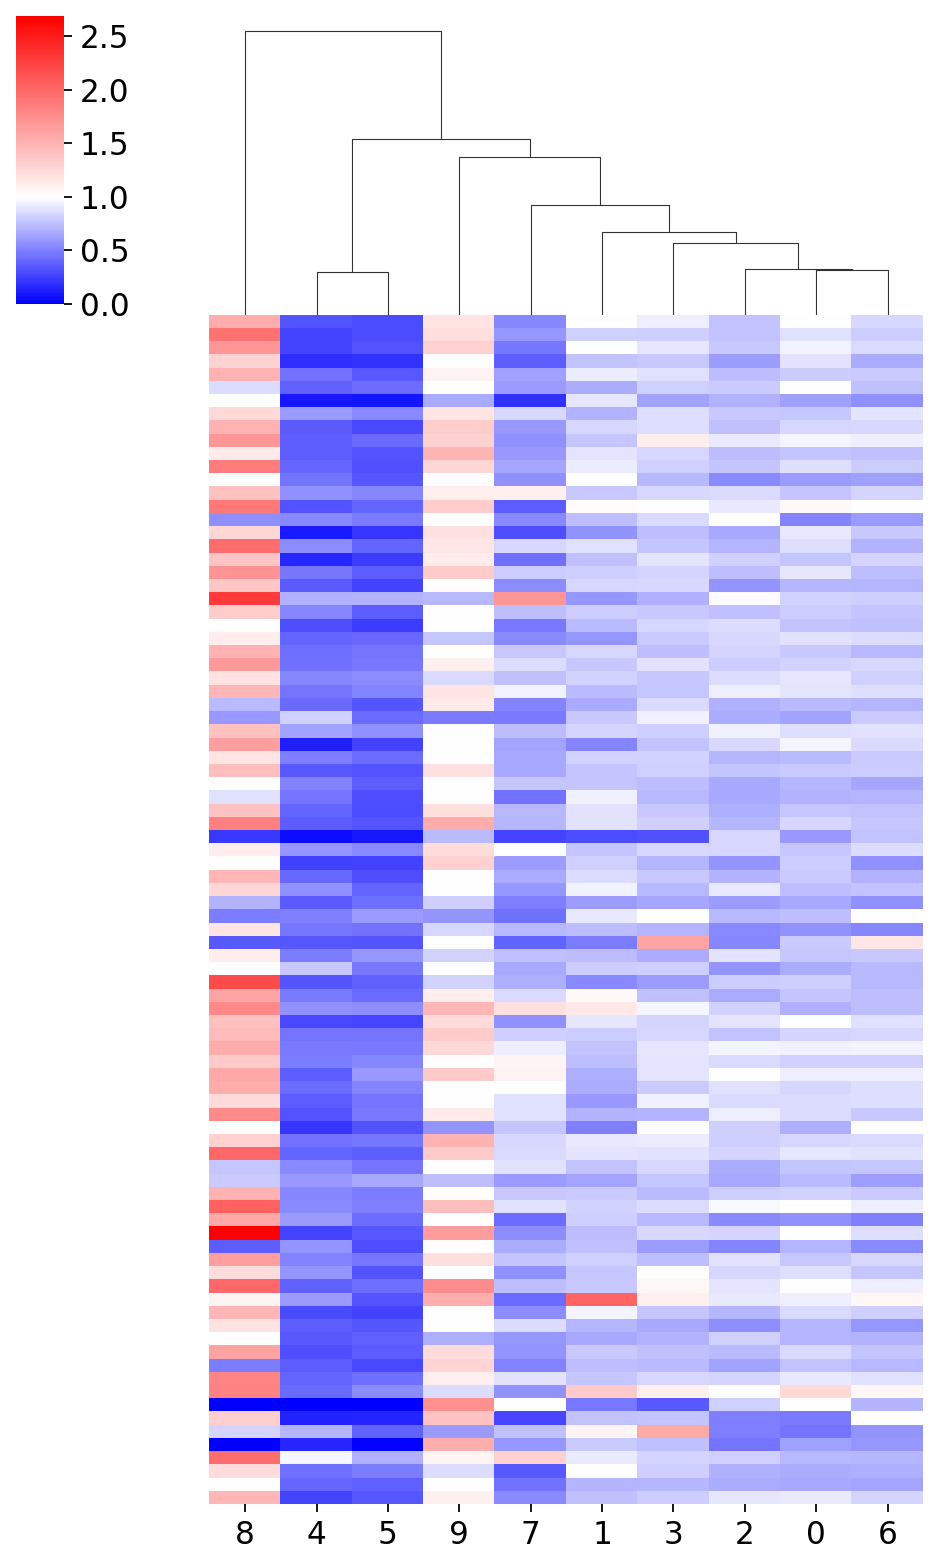

In [24]:
# Heatmap of pathway activities
# Need to double check best clustering parameters
fig = sns.clustermap(df_p, cmap='bwr', yticklabels=[], #yticklabels=metab_genes.index, 
                     norm=DivergingNorm(1.0), row_cluster=False, figsize=(6, 10))

#fig = plt.title('CD8 T cell metabolomics by Leiden cluster')
#fig = plt.xlabel('Leiden cluster')

### Metabolic clusters instead of overall clusters

In [11]:
adata.obs['louvain_metab'] = adata_metab.obs['louvain']

In [12]:
p = pathway_activity(adata, adata_metab, 'louvain_metab', print_labels=True)

0
1
2
3
4
5


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [13]:
# Statistical significance of higher or lower pathway activity in a specific cell type
# Random permutation test
enriched = (p > 1)
decreased = (p < 1)

# Shuffle cell cluster labels 5000x
n = 1000
compares = np.zeros((len(p), len(p[0])))
for i in range(n):
    if i % 100 == 0:
        print(i)
    clusters_shuffled = np.random.permutation(adata.obs['louvain_metab'])
    adata.obs['louvain_metab_shuffle'] = clusters_shuffled
    adata_metab.obs['louvain_metab_shuffle'] = clusters_shuffled
    
    # Compare new pathway activity scores to original dataset pathway activity scores
    p_shuffle = pathway_activity(adata, adata_metab, 'louvain_metab_shuffle')
    compares += enriched * (p_shuffle > p) + decreased * (p_shuffle < p)

compares /= n

# Non-significantly changed activity scores are reverted to 1 (no activity change)
significant = (compares < 0.01)
p_sig = p ** significant

0
100
200
300
400
500
600
700
800
900


In [14]:
# Save pathway activity scores
df_p = pd.DataFrame(p_sig)
df_p.to_csv(master_dir + 'output/pathway_activity/' + celltype + '-metab-metab_cluster-pathway_activity.tabular', 
                       sep='\t', header=None, index=None)
# Read saved pathway activity scores
#df_p = pd.read_csv(master_dir + 'output/pathway_activity/' + celltype + '-metab-metab_cluster-pathway_activity.tabular', 
#                   sep='\t', header=None)
#df_p.head()

<ipython-input-15-d0ad4632f9ee>:5: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(1.0), row_cluster=False, figsize=(3.5, 10))


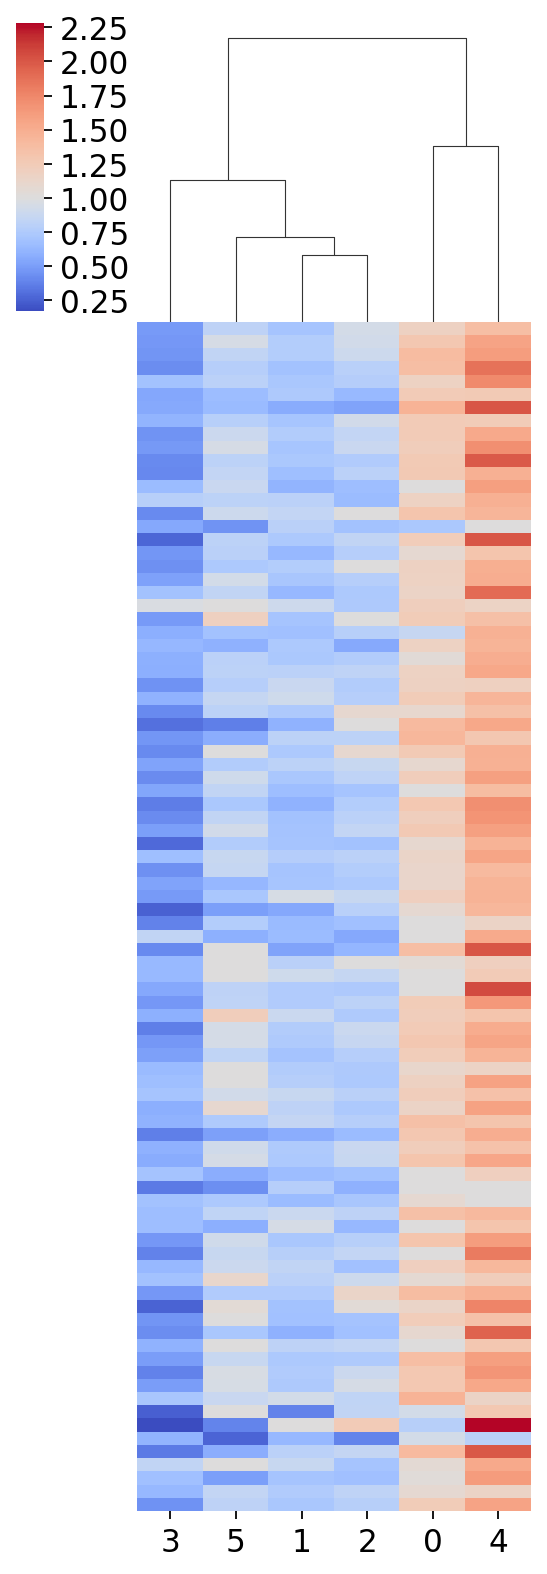

In [15]:
# Heatmap of pathway activities
# Need to double check best clustering parameters
df_p = pd.DataFrame(p_sig)
fig = sns.clustermap(df_p, cmap='coolwarm', yticklabels=[], #yticklabels=metab_genes.index, 
                     norm=DivergingNorm(1.0), row_cluster=False, figsize=(3.5, 10))

#fig = plt.title('CD8 T cell metabolomics by Leiden cluster')
#fig = plt.xlabel('Leiden cluster')

Same as above, now excluding clusters 0 and 4

In [16]:
p = pathway_activity(adata, adata_metab, 'louvain_metab', print_labels=True, exclude_clusters=['0', '4'])

1
2
3
5


In [17]:
# Statistical significance of higher or lower pathway activity in a specific cell type
# Random permutation test
enriched = (p > 1)
decreased = (p < 1)

# Shuffle cell cluster labels 5000x
n = 1000
compares = np.zeros((len(p), len(p[0])))
for i in range(n):
    if i % 100 == 0:
        print(i)
    clusters_shuffled = np.random.permutation(adata.obs['louvain_metab'])
    adata.obs['louvain_metab_shuffle'] = clusters_shuffled
    adata_metab.obs['louvain_metab_shuffle'] = clusters_shuffled
    
    # Compare new pathway activity scores to original dataset pathway activity scores
    p_shuffle = pathway_activity(adata, adata_metab, 'louvain_metab_shuffle', exclude_clusters=['0', '4'])
    compares += enriched * (p_shuffle > p) + decreased * (p_shuffle < p)

compares /= n

# Non-significantly changed activity scores are reverted to 1 (no activity change)
significant = (compares < 0.01)
p_sig = p ** significant

0
100
200
300
400
500
600
700
800
900


In [18]:
# Save pathway activity scores
df_p = pd.DataFrame(p_sig)
df_p.to_csv(master_dir + 'output/pathway_activity/' + celltype + '-metab-metab_cluster_1_2_3_5-pathway_activity.tabular', 
                       sep='\t', header=None, index=None)
# Read saved pathway activity scores
#df_p = pd.read_csv(master_dir + 'output/pathway_activity/' + celltype + '-metab-metab_cluster-pathway_activity.tabular', 
#                   sep='\t', header=None)
#df_p.head()

<ipython-input-19-632f0528c719>:6: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(1.0), row_cluster=False, figsize=(2, 10))


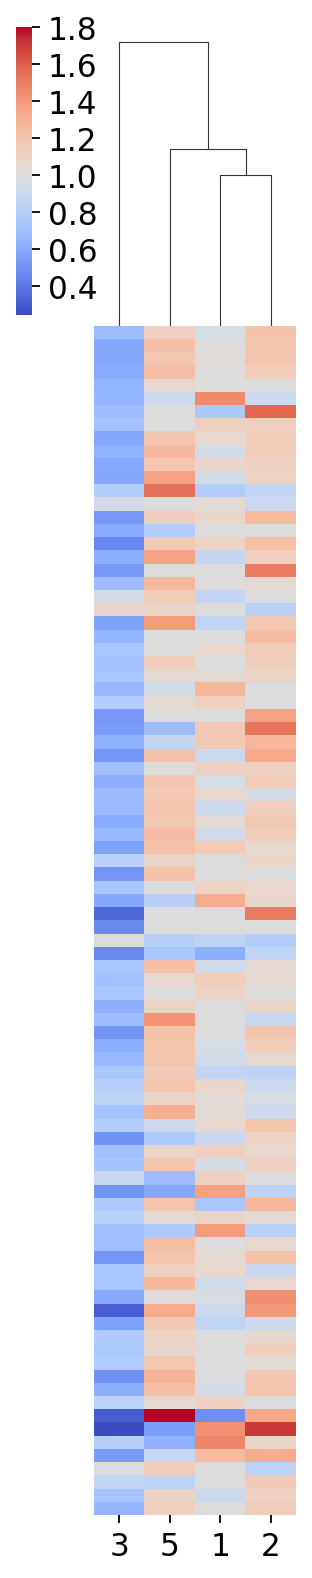

In [19]:
# Heatmap of pathway activities
# Need to double check best clustering parameters
df_p = pd.DataFrame(p_sig)
fig = sns.clustermap(df_p, cmap='coolwarm', yticklabels=[], #yticklabels=metab_genes.index,
                     xticklabels=['1', '2', '3', '5'],  
                     norm=DivergingNorm(1.0), row_cluster=False, figsize=(2, 10))

## Pathway activity based on treatment status


In [20]:
adata.obs['no_IL6i_time'] = adata.obs['no_IL6i'].astype(str) + '.' + adata.obs['Blood_draw_time'].astype(str)

In [21]:
# Here, cell type is defined as individual clusters ('louvain')
# within a given group of immune cells (B cells, T cells, etc.)
# Clusters calculated from all genes rather than just metabolic genes
# in order to associate the metabolic gene set enrichment with the non-metabolic analyses
p = pathway_activity(adata, adata_metab, 'no_IL6i_time', print_labels=True)

Healthy.Healthy
after.T2
before.T1
no.T1
no.T2


In [13]:
# Statistical significance of higher or lower pathway activity in a specific cell type
# Random permutation test
enriched = (p > 1)
decreased = (p < 1)

# Shuffle cell cluster labels 5000x
n = 5000
compares = np.zeros((len(p), len(p[0])))
for i in range(n):
    if i % 100 == 0:
        print(i)
    clusters_shuffled = np.random.permutation(adata.obs['no_IL6i_time'])
    adata.obs['no_IL6i_time_shuffle'] = clusters_shuffled
    adata_metab.obs['no_IL6i_time_shuffle'] = clusters_shuffled
    
    # Compare new pathway activity scores to original dataset pathway activity scores
    p_shuffle = pathway_activity(adata, adata_metab, 'no_IL6i_time_shuffle');
    compares += enriched * (p_shuffle > p) + decreased * (p_shuffle < p)

compares /= n

# Non-significantly changed activity scores are reverted to 1 (no activity change)
significant = (compares < 0.01)
p_sig = p ** significant
#p_sig

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


In [56]:
# Save pathway activity scores
df_p = pd.DataFrame(p_sig)
df_p.to_csv(master_dir + 'output/pathway_activity/' + celltype + '-metab-no_IL6i-pathway_activity.tabular', 
                       sep='\t', header=None, index=None)

<ipython-input-26-9ec73cca64d0>:6: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  row_cluster=None, norm=DivergingNorm(1.0), figsize=(3.5, 10))


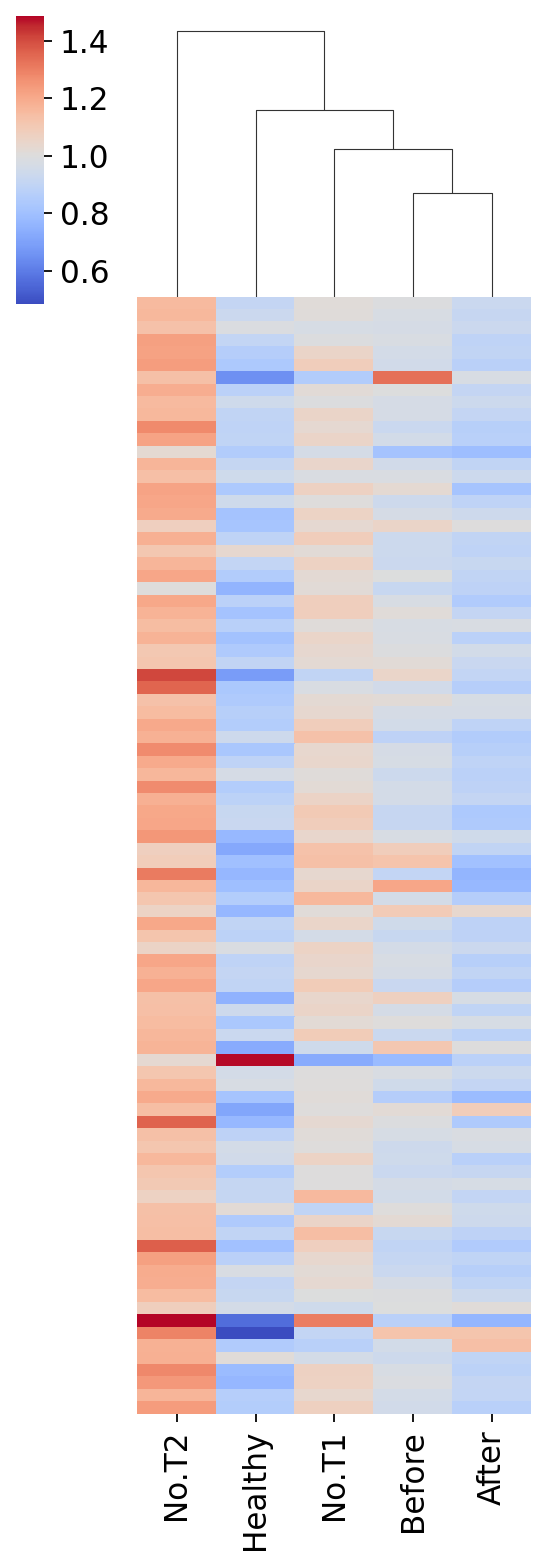

In [26]:
# Heatmap of pathway activities
#fig = plt.figure(figsize=(15, 20))
p_sig_reorder = p[:, [0, 2, 1, 3, 4]]
fig = sns.clustermap(p_sig_reorder, cmap='coolwarm', yticklabels=[], #metab_genes.index, 
                     xticklabels=['Healthy', 'Before', 'After', 'No.T1', 'No.T2'], 
                     row_cluster=None, norm=DivergingNorm(1.0), figsize=(3.5, 10))
#fig.set_xticklabels(adata.obs['no_IL6i'].unique())
#fig.set_xlabel('Patient IL6i status')
#fig = plt.title('CD8 T cell metabolomics by Leiden cluster')
#fig = plt.xlabel('Leiden cluster')

### Excluding the "before" and "no" states of IL6i treatment

In [10]:
# Here, cell type is defined as individual clusters ('louvain')
# within a given group of immune cells (B cells, T cells, etc.)
# Clusters calculated from all genes rather than just metabolic genes
# in order to associate the metabolic gene set enrichment with the non-metabolic analyses
data = adata[adata.obs['no_IL6i'].isin(['Healthy', 'before'])].copy()
data_metab = adata_metab[adata_metab.obs['no_IL6i'].isin(['Healthy', 'before'])].copy()
p = pathway_activity(data, data_metab, 'no_IL6i', print_labels=True)

Healthy
before


In [143]:
# Statistical significance of higher or lower pathway activity in a specific cell type
# Random permutation test
enriched = (p > 1)
decreased = (p < 1)

# Shuffle cell cluster labels 5000x
n = 5000
compares = np.zeros((len(p), len(p[0])))
for i in range(n):
    if i % 100 == 0:
        print(i)
    clusters_shuffled = np.random.permutation(data.obs['no_IL6i'])
    data.obs['no_IL6i_shuffle'] = clusters_shuffled
    data_metab.obs['no_IL6i_shuffle'] = clusters_shuffled
    
    # Compare new pathway activity scores to original dataset pathway activity scores
    p_shuffle = pathway_activity(data, data_metab, 'no_IL6i_shuffle');
    compares += enriched * (p_shuffle > p) + decreased * (p_shuffle < p)

compares /= n

# Non-significantly changed activity scores are reverted to 1 (no activity change)
significant = (compares < 0.01)
p_sig = p ** significant
#p_sig

0


/usr/lusers/jlee712/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/usr/lusers/jlee712/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in greater
/usr/lusers/jlee712/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in less


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


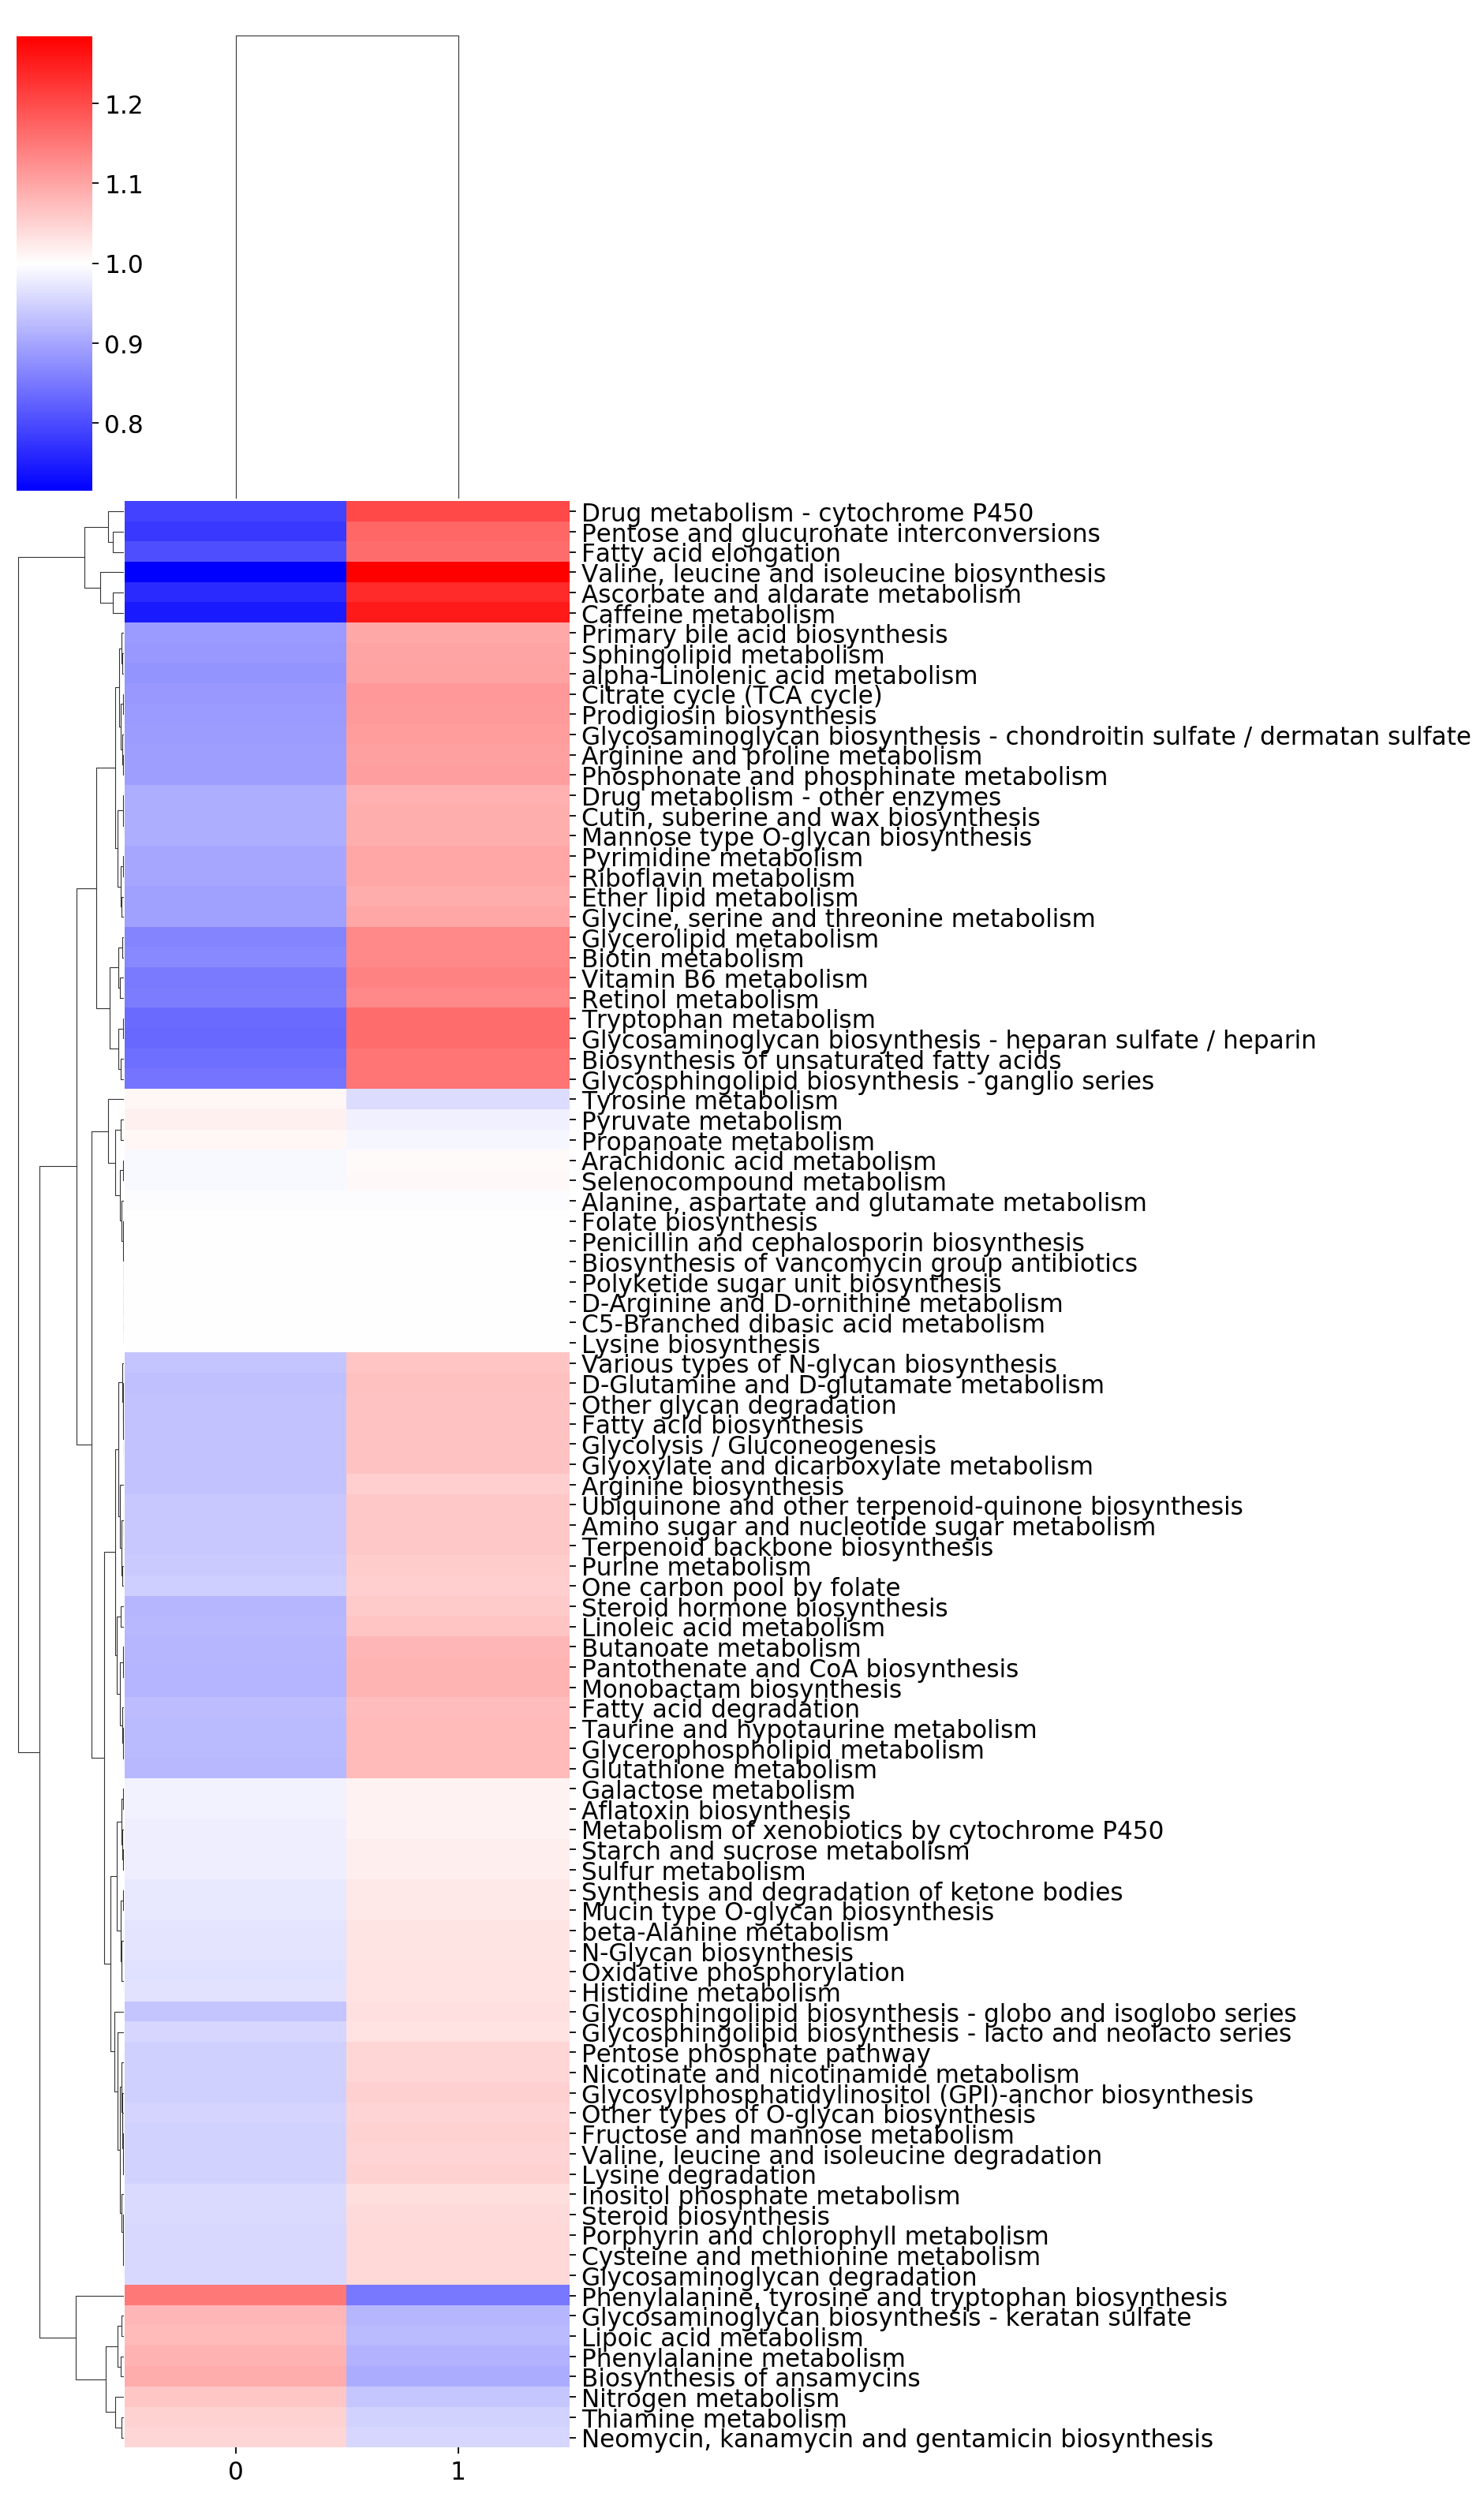

In [49]:
# Heatmap of pathway activities
# Need to double check best clustering parameters
#fig = plt.figure(figsize=(15, 20))
fig = sns.clustermap(p, cmap='bwr', yticklabels=metab_genes.index, 
                     norm=DivergingNorm(1.0), figsize=(12, 20))
#fig.set_xticklabels(adata.obs['no_IL6i'].unique())
#fig.set_xlabel('Patient IL6i status')
#fig = plt.title('CD8 T cell metabolomics by Leiden cluster')
#fig = plt.xlabel('Leiden cluster')

### Subset analysis (7/3/20)

In [59]:
p = pathway_activity(adata, adata_metab, 'louvain', print_labels=True, exclude_clusters=['8', '9'])

0
1
2
3
4
5
6
7


In [60]:
# Statistical significance of higher or lower pathway activity in a specific cell type
# Random permutation test
enriched = (p > 1)
decreased = (p < 1)

# Shuffle cell cluster labels 5000x
data = adata[adata.obs['louvain'] != '8']
data = data[data.obs['louvain'] != '9']

data_metab = adata_metab[data.obs['louvain'].index]

n = 5000
compares = np.zeros((len(p), len(p[0])))
for i in range(n):
    if i % 100 == 0:
        print(i)
    clusters_shuffled = np.random.permutation(data.obs['louvain'])
    data.obs['louvain_shuffle'] = clusters_shuffled
    data_metab.obs['louvain_shuffle'] = clusters_shuffled
    
    # Compare new pathway activity scores to original dataset pathway activity scores
    p_shuffle = pathway_activity(data, data_metab, 'louvain_shuffle')
    compares += enriched * (p_shuffle > p) + decreased * (p_shuffle < p)

compares /= n

0


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


In [26]:
# Non-significantly changed activity scores are reverted to 1 (no activity change)
#significant = (compares < 0.01)
#p_sig = p ** significant

# Save pathway activity scores
#df_p = pd.DataFrame(p_sig)
#df_p.to_csv(master_dir + 'output/pathway_activity/' + celltype + '-metab-cluster_wo_8_9-pathway_activity.tabular', 
#                       sep='\t', header=None, index=None)

# Read previously saved file
df_p = pd.read_csv(master_dir + 'output/pathway_activity/' + celltype + '-metab-cluster_wo_8_9-pathway_activity.tabular', 
                       sep='\t', header=None)
df_p.head()

0         1         2         3         4         5         6  \
0  1.269933  1.245714  1.161151  1.168757  0.405865  0.391888  1.095304   
1  1.253939  1.188719  1.000000  1.157423  0.385891  0.439595  1.173798   
2  1.332024  1.264875  1.082460  1.286228  0.354537  0.404020  1.163273   
3  1.187085  1.166651  1.000000  1.390074  0.291137  0.380995  1.143976   
4  1.211042  1.285650  1.093694  1.238251  0.644359  0.480916  1.163528   

          7  
0  0.711510  
1  0.836356  
2  0.615205  
3  0.721394  
4  0.852729

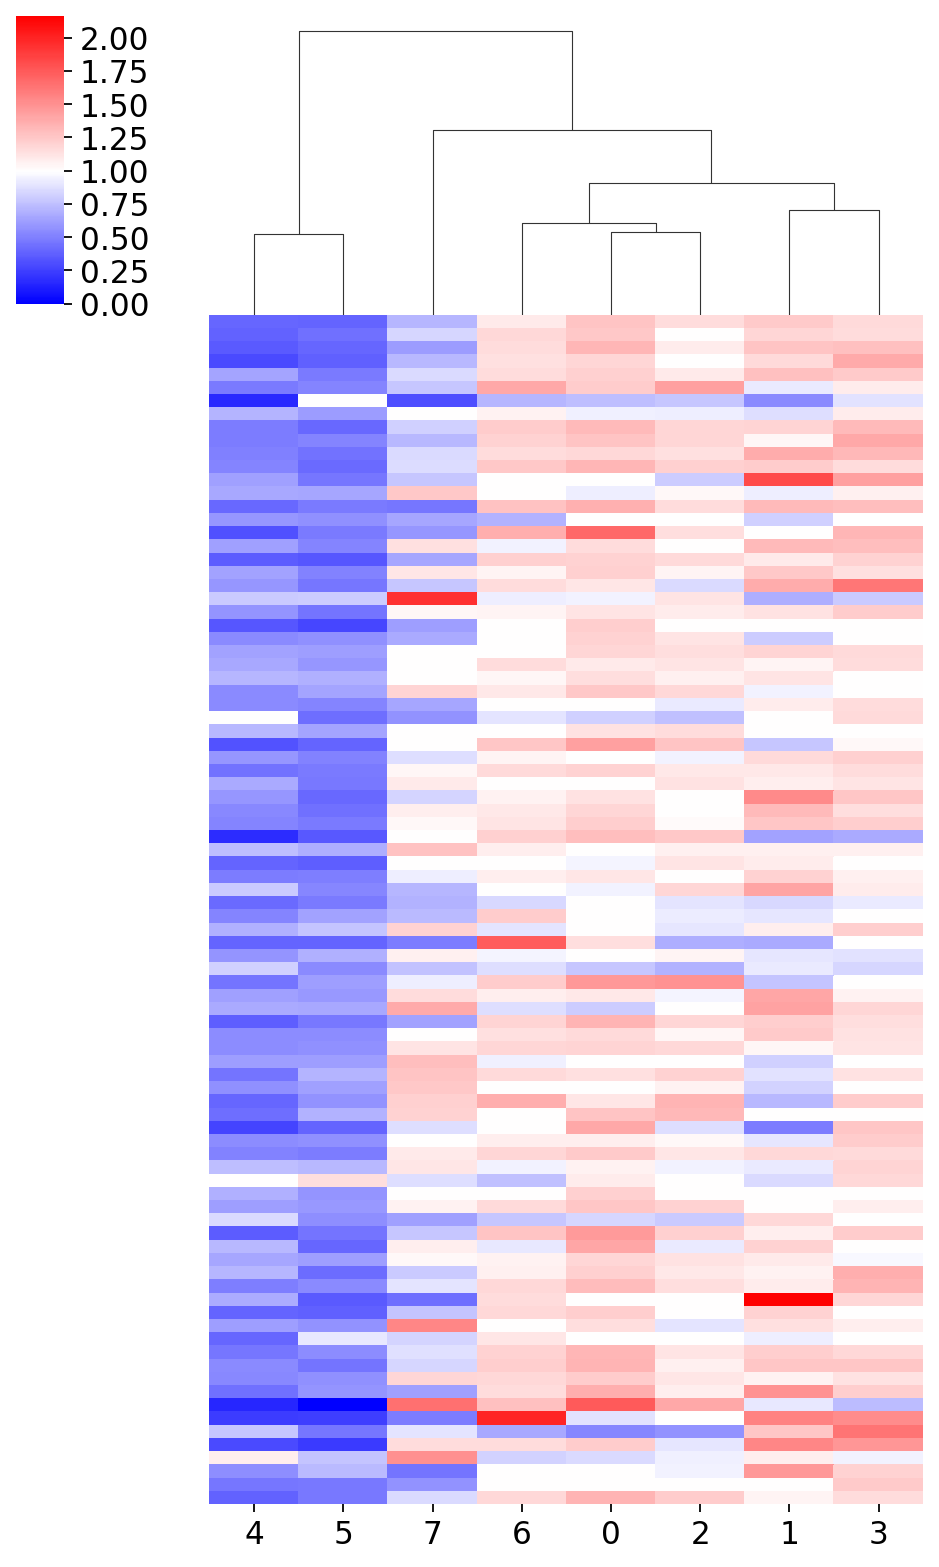

In [27]:
# Heatmap of pathway activities
# Need to double check best clustering parameters
fig = sns.clustermap(df_p, cmap='bwr', yticklabels=[], #metab_genes.index, 
                     row_cluster=False, norm=DivergingNorm(1.0), figsize=(6, 10))
#fig = plt.title('CD8 T cell metabolomics by Leiden cluster')
#fig = plt.xlabel('Leiden cluster')

In [63]:
# Now without clusters 4, 5, 8, 9
p = pathway_activity(adata, adata_metab, 'louvain', print_labels=True, exclude_clusters=['4', '5', '8', '9'],
                    nanval=1)

0
1
2
3
6
7


In [70]:
p_healthy = pathway_activity(adata[adata.obs['WHO_scale']==0], 
                            adata_metab[adata.obs['WHO_scale']==0], 'louvain', 
                             print_labels=True, exclude_clusters=['4', '5', '8', '9'],
                            nanval=1)

0
1
2
3
6
7


In [71]:
p_nonICU = pathway_activity(adata[adata.obs['ICU_status']=='Non-ICU'], 
                            adata_metab[adata.obs['ICU_status']=='Non-ICU'], 'louvain', 
                             print_labels=True, exclude_clusters=['4', '5', '8', '9'],
                            nanval=1)

0
1
2
3
6
7


In [72]:
p_ICU = pathway_activity(adata[adata.obs['ICU_status']=='ICU'], 
                            adata_metab[adata.obs['ICU_status']=='ICU'], 'louvain', 
                             print_labels=True, exclude_clusters=['4', '5', '8', '9'],
                            nanval=1)

0
1
2
3
6
7


In [66]:
# Statistical significance of higher or lower pathway activity in a specific cell type
# Random permutation test
enriched = (p > 1)
decreased = (p < 1)

# Shuffle cell cluster labels 5000x
data = adata[adata.obs['louvain'].isin(['0', '1', '2', '3', '6', '7'])]

data_metab = adata_metab[data.obs['louvain'].index]

n = 5000
compares = np.zeros((len(p), len(p[0])))
for i in range(n):
    if i % 100 == 0:
        print(i)
    clusters_shuffled = np.random.permutation(data.obs['louvain'])
    data.obs['louvain_shuffle'] = clusters_shuffled
    data_metab.obs['louvain_shuffle'] = clusters_shuffled
    
    # Compare new pathway activity scores to original dataset pathway activity scores
    p_shuffle = pathway_activity(data, data_metab, 'louvain_shuffle')
    compares += enriched * (p_shuffle > p) + decreased * (p_shuffle < p)

compares /= n

0


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


In [28]:
# Non-significantly changed activity scores are reverted to 1 (no activity change)
#significant = (compares < 0.01)
#p_sig = p ** significant
#p_sig

# Save pathway activity scores
#df_p = pd.DataFrame(p_sig)
#df_p.to_csv(master_dir + 'output/pathway_activity/' + celltype + '-metab-cluster_wo_4_5_8_9-pathway_activity.tabular', 
#                       sep='\t', header=None, index=None)
df_p = pd.read_csv(master_dir + 'output/pathway_activity/' + celltype + '-metab-cluster_wo_4_5_8_9-pathway_activity.tabular', 
                       sep='\t', header=None)
df_p.head()

0         1         2         3         4         5
0  1.000000  1.000000  1.000000  1.000000  0.921849  0.596736
1  1.000000  1.000000  0.917541  1.000000  1.000000  0.713411
2  1.106028  1.053556  0.904311  1.060293  1.000000  0.495121
3  1.390660  1.000000  0.853480  1.166655  1.000000  0.649370
4  1.058167  1.114285  0.963604  1.076078  1.000000  0.742756

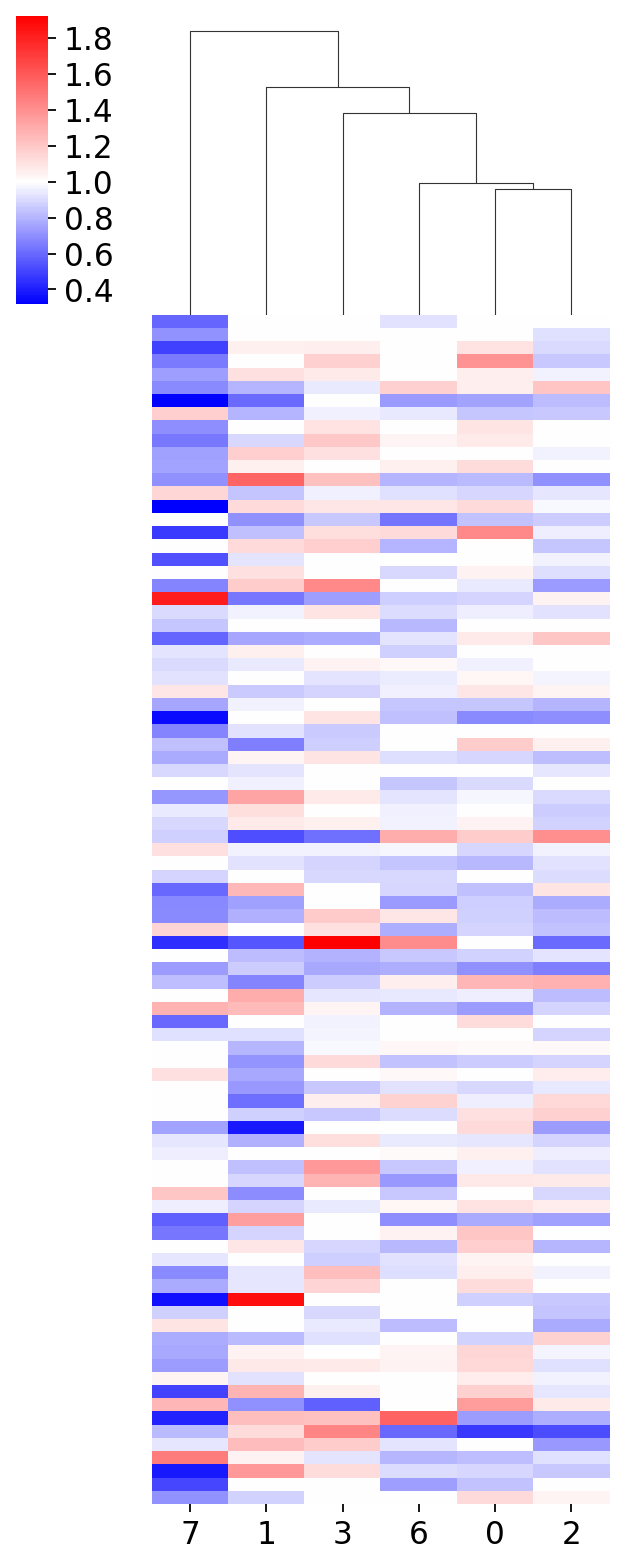

In [30]:
# Heatmap of pathway activities
# Need to double check best clustering parameters
fig = sns.clustermap(df_p, cmap='bwr', yticklabels=[], #metab_genes.index, 
                     row_cluster=False,
                     xticklabels=['0', '1', '2', '3', '6', '7'], 
                     norm=DivergingNorm(1.0), figsize=(4, 10))
#fig = plt.title('CD8 T cell metabolomics by Leiden cluster')
#fig = plt.xlabel('Leiden cluster')

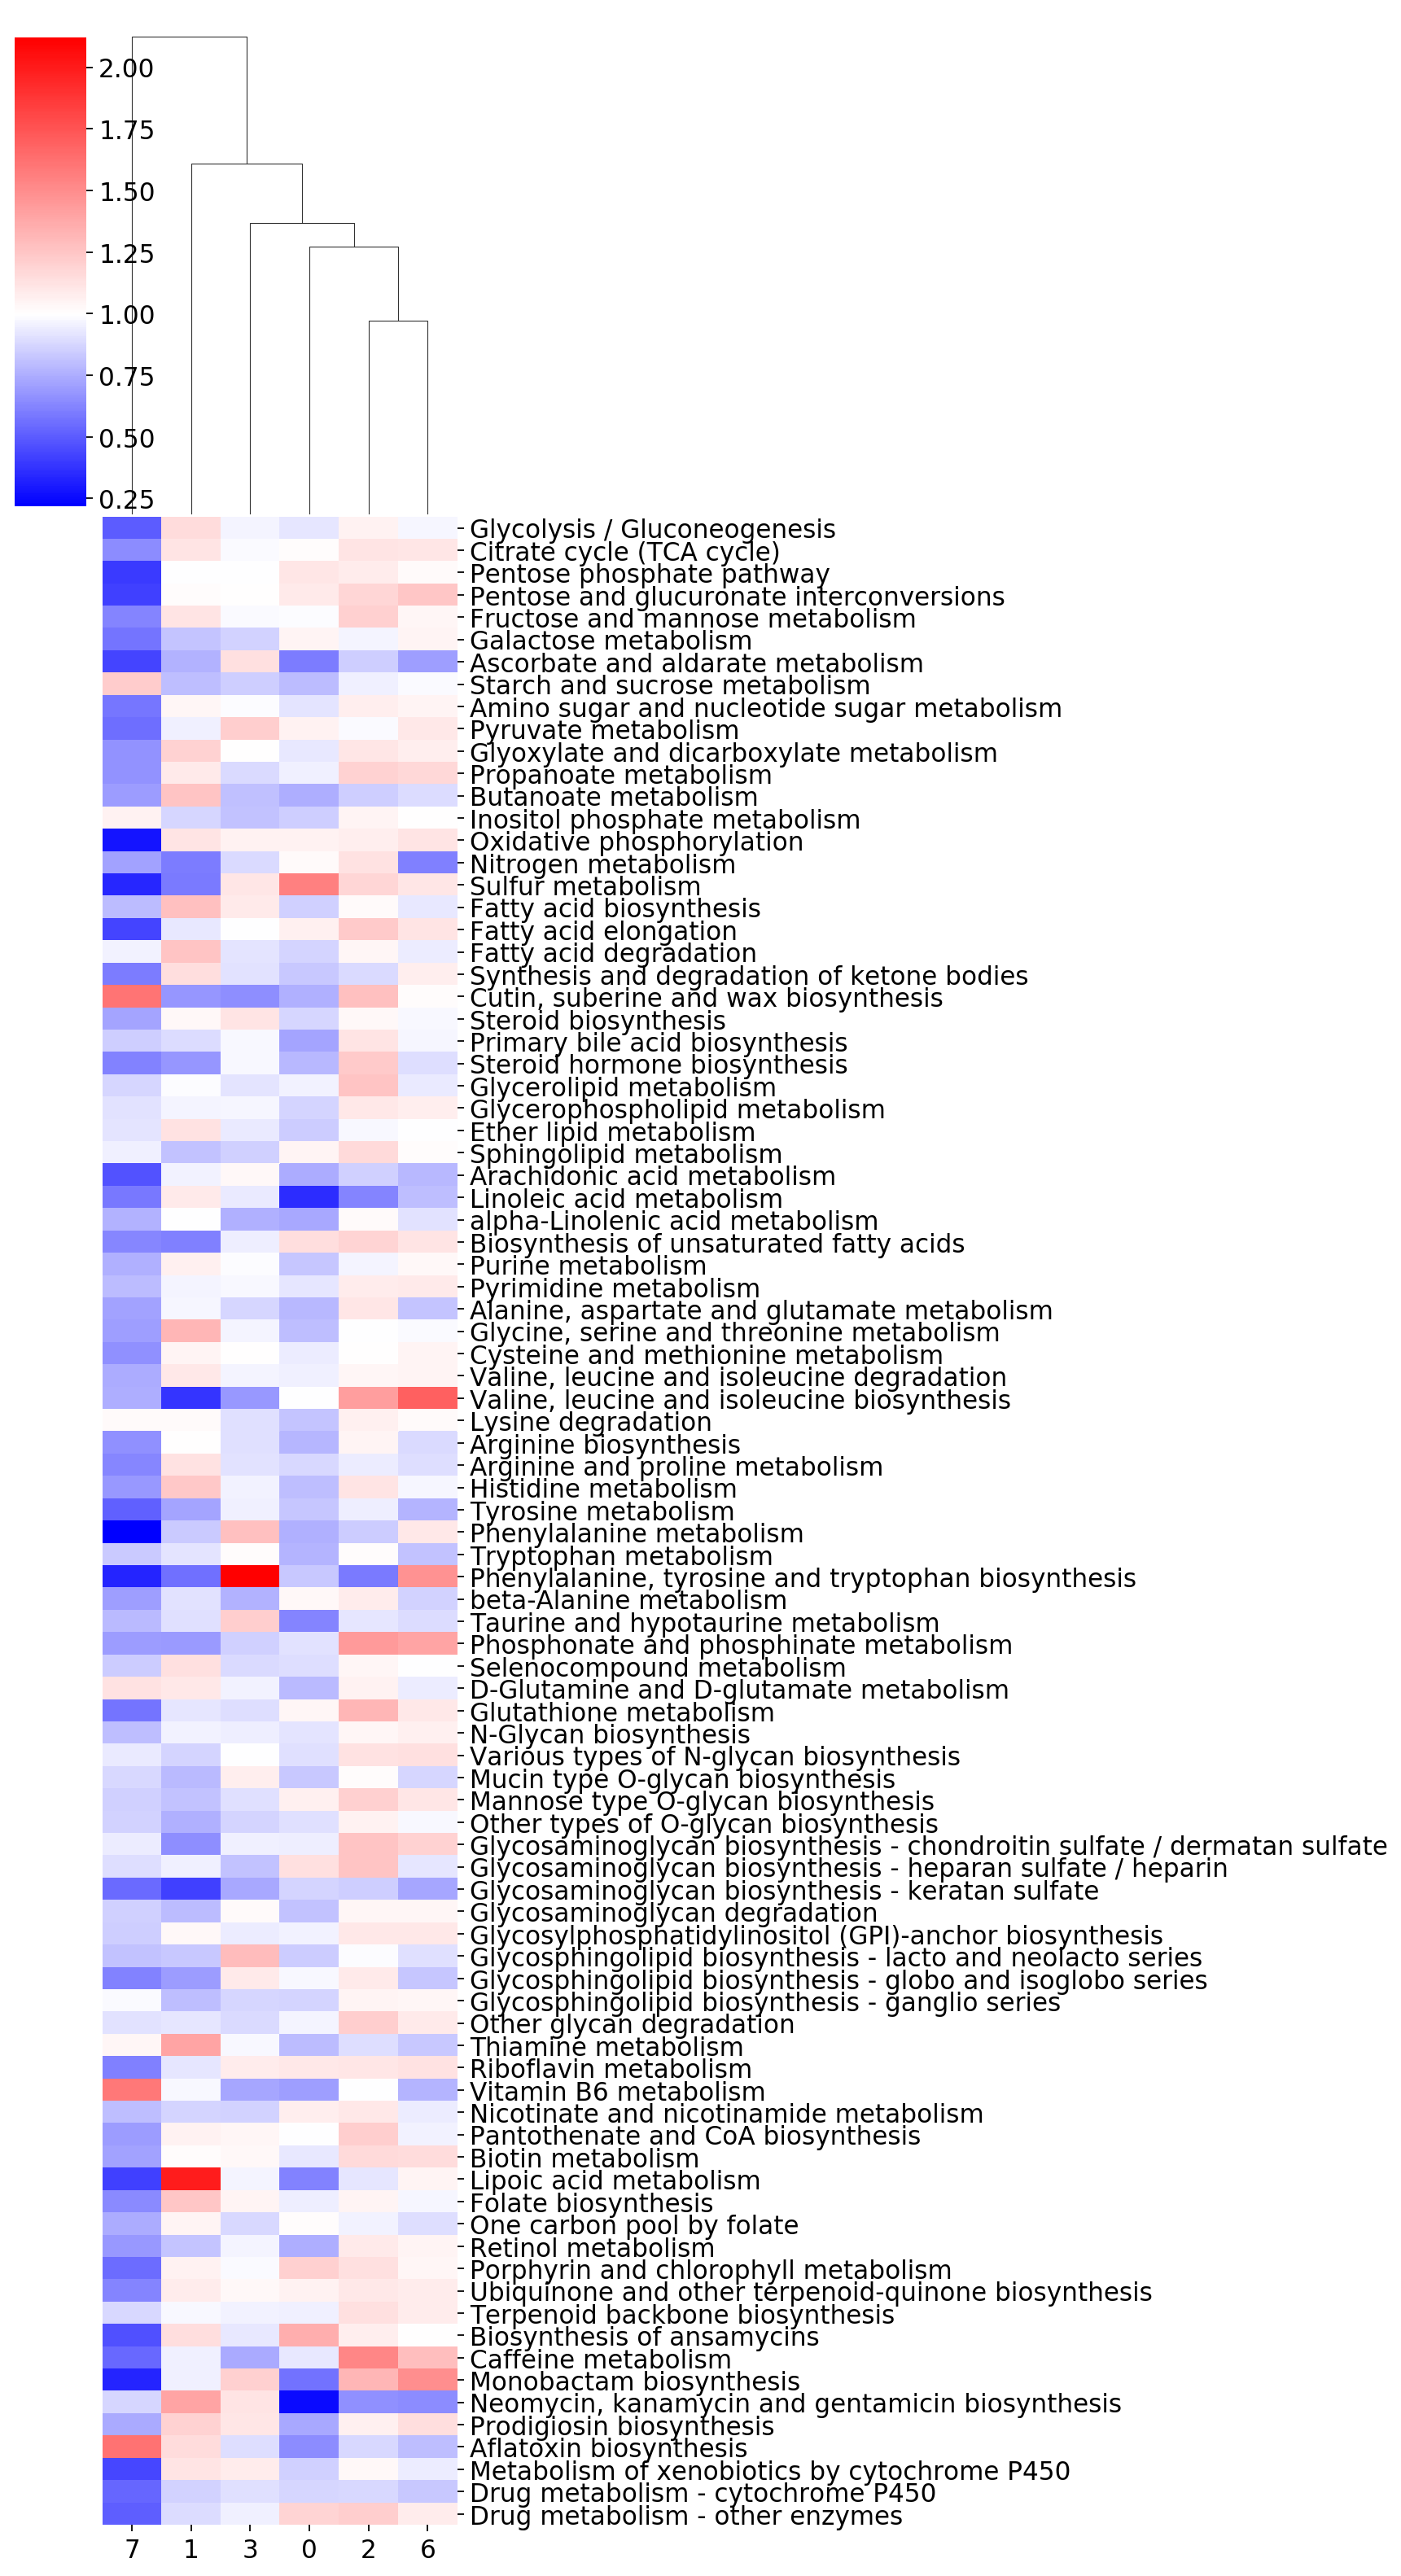

In [73]:
fig = sns.clustermap(p_healthy, cmap='bwr', yticklabels=metab_genes.index, row_cluster=False,
                     xticklabels=['0', '1', '2', '3', '6', '7'], figsize=(11, 20),
                     norm=DivergingNorm(1.0))

In [74]:
# Non-significantly changed activity scores are reverted to 1 (no activity change)
#significant = (compares < 0.01)
#p_sig = p ** significant
#p_sig

# Save pathway activity scores
df_p = pd.DataFrame(p_healthy)
df_p.to_csv(master_dir + 'output/pathway_activity/' + celltype + 
            '-healthy-metab-cluster_wo_4_5_8_9-pathway_activity.tabular', 
                       sep='\t', header=None, index=None)

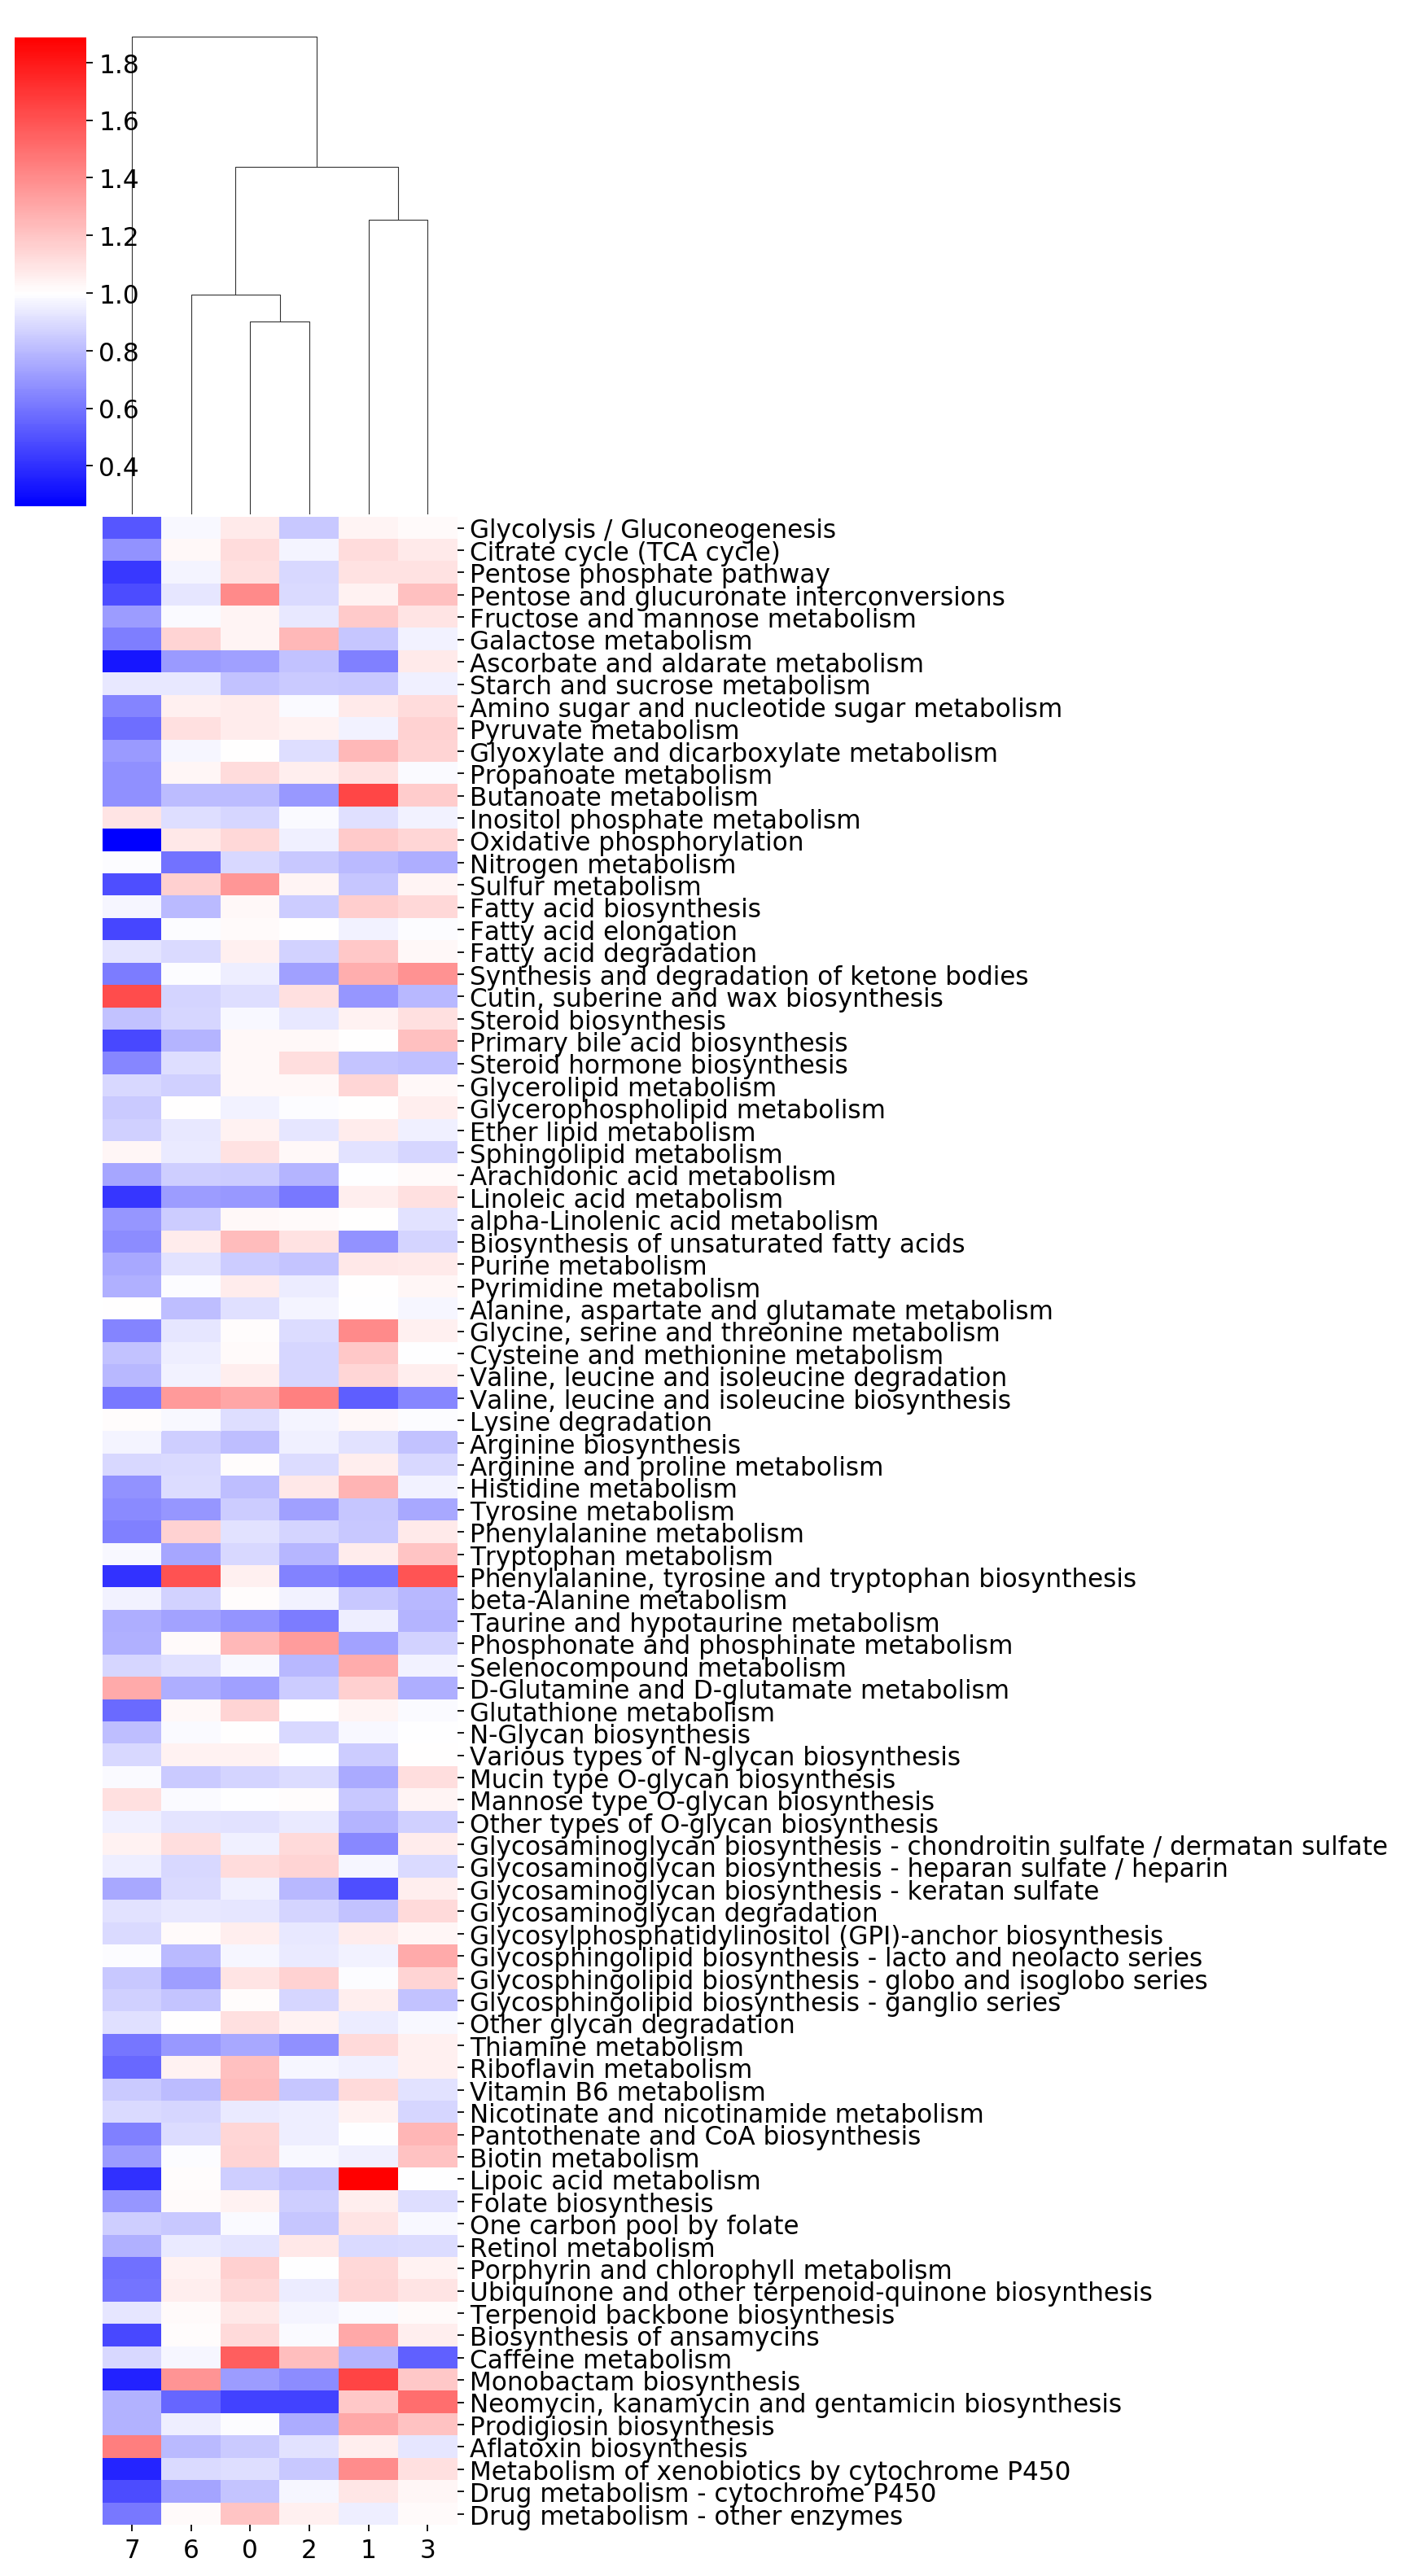

In [75]:
fig = sns.clustermap(p_nonICU, cmap='bwr', yticklabels=metab_genes.index, row_cluster=False,
                     xticklabels=['0', '1', '2', '3', '6', '7'], figsize=(11, 20),
                     norm=DivergingNorm(1.0))

In [76]:
# Non-significantly changed activity scores are reverted to 1 (no activity change)
#significant = (compares < 0.01)
#p_sig = p ** significant
#p_sig

# Save pathway activity scores
df_p = pd.DataFrame(p_nonICU)
df_p.to_csv(master_dir + 'output/pathway_activity/' + celltype + 
            '-nonICU-metab-cluster_wo_4_5_8_9-pathway_activity.tabular', 
                       sep='\t', header=None, index=None)

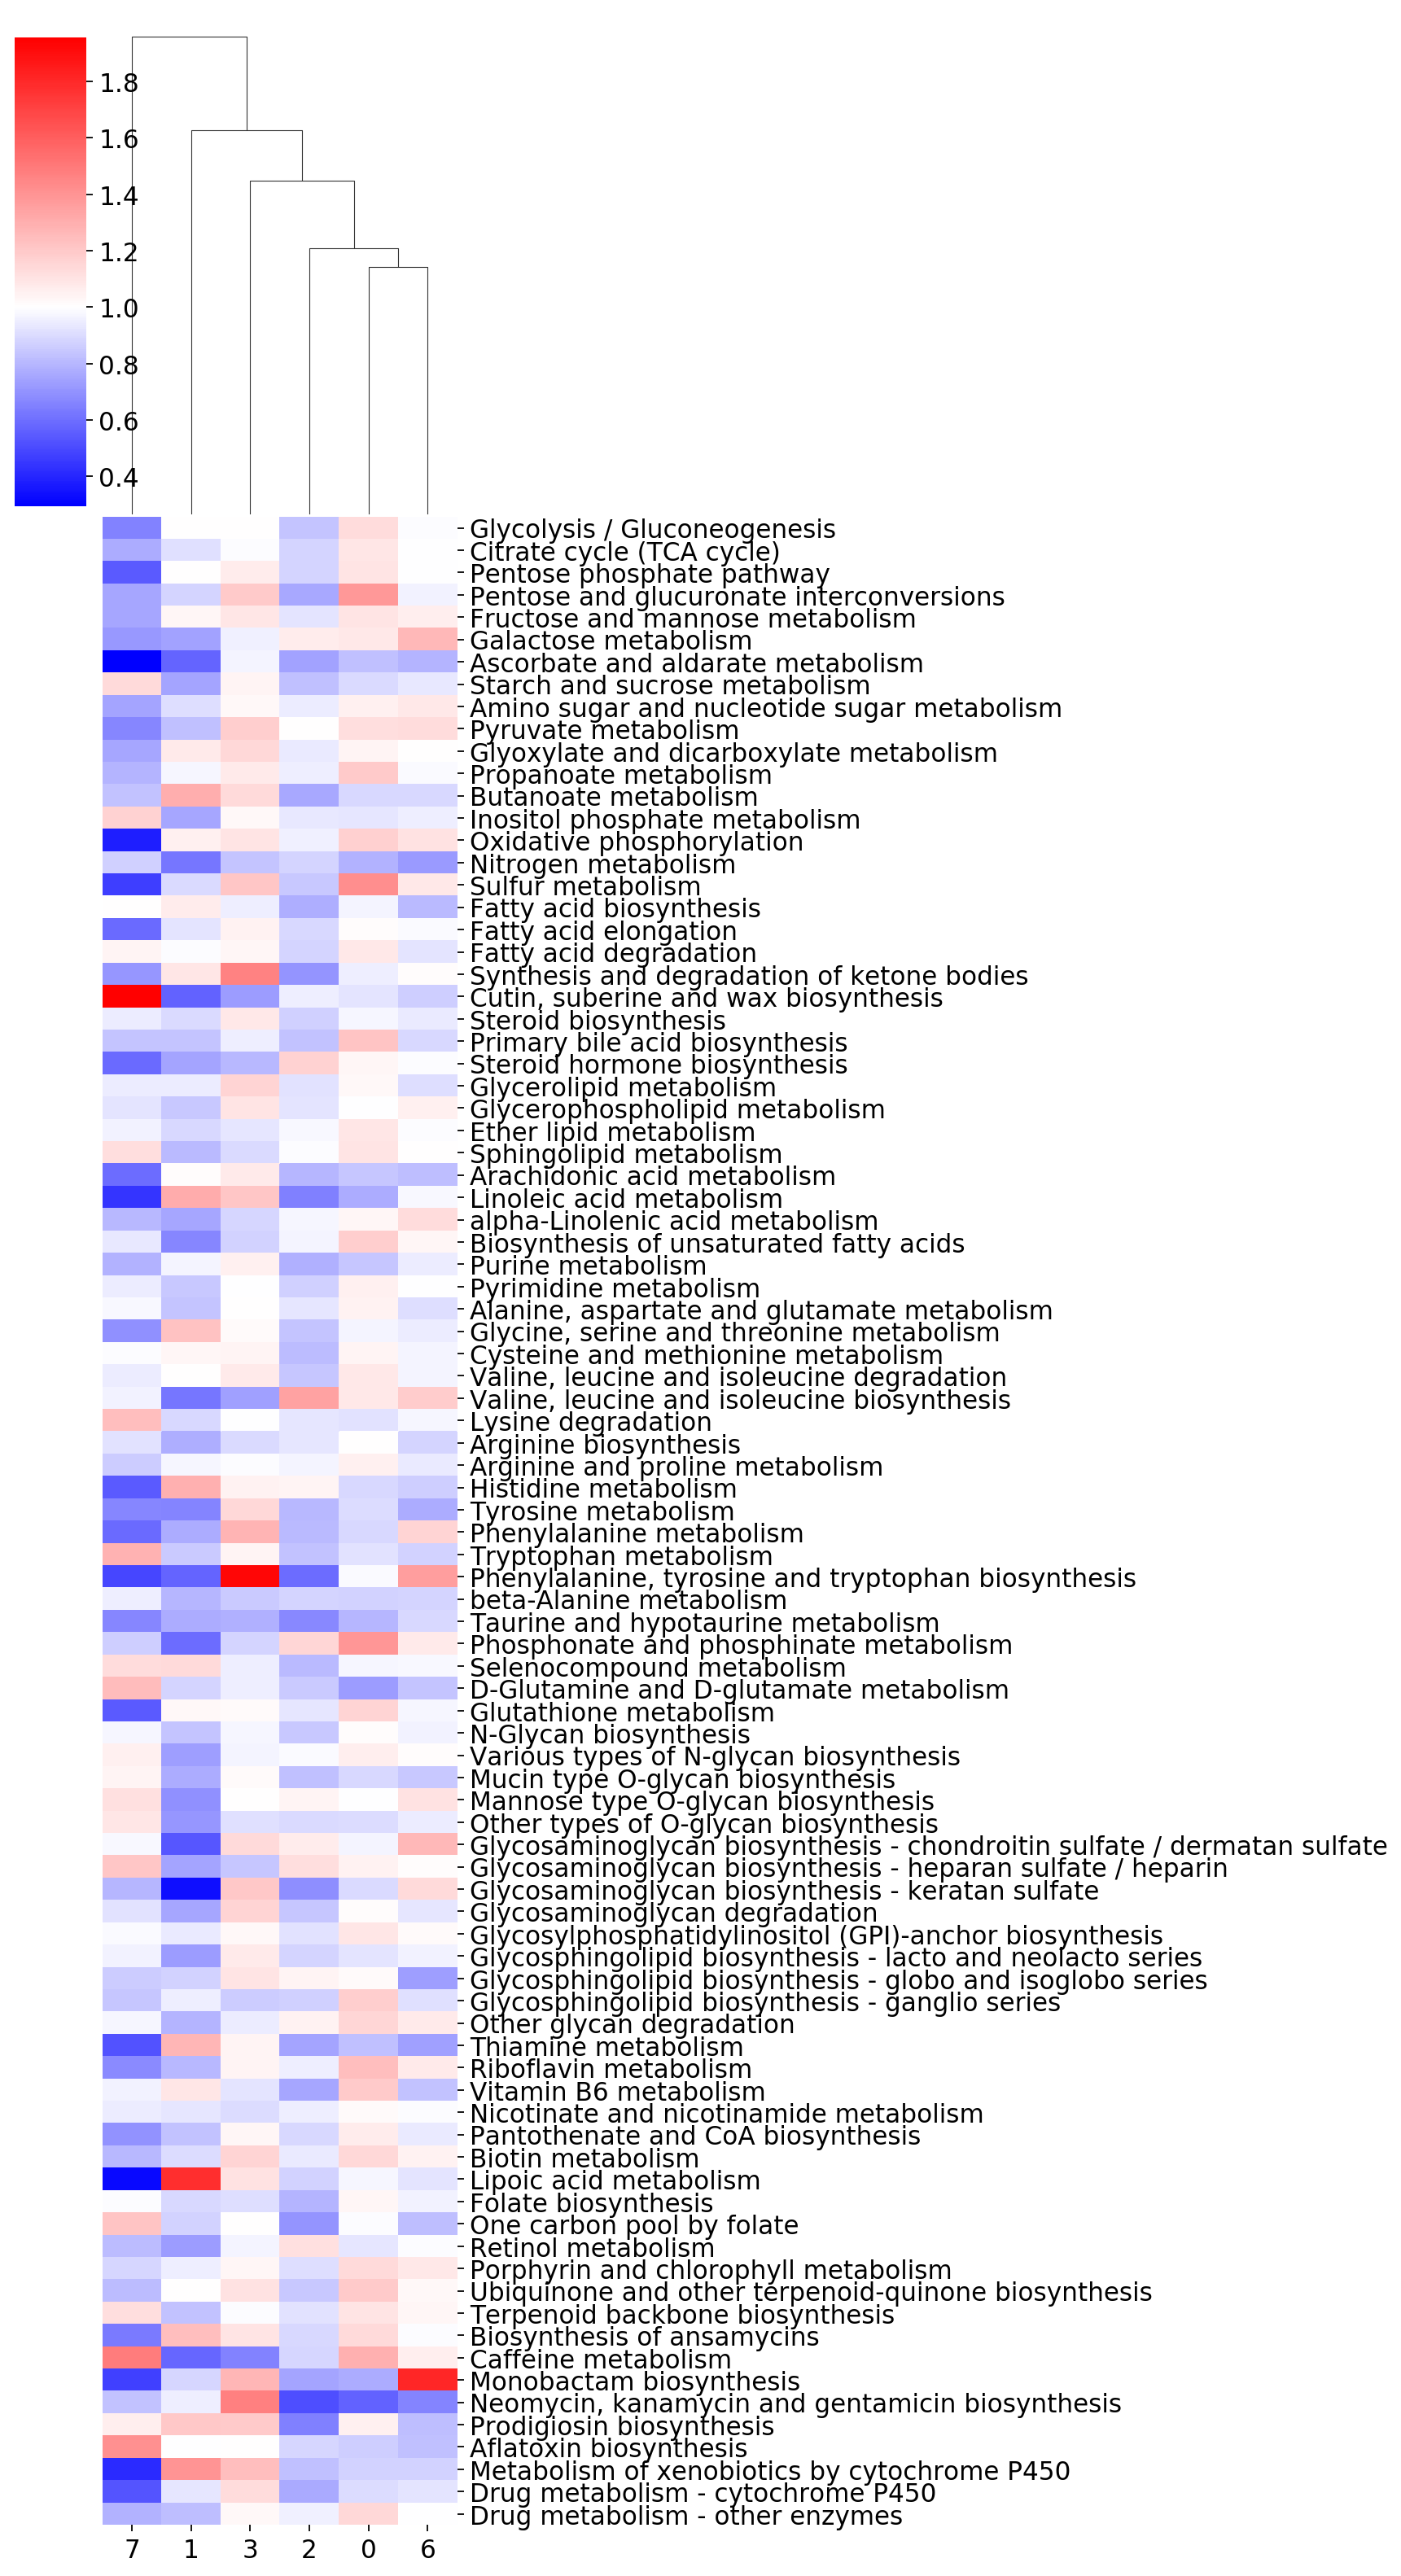

In [77]:
fig = sns.clustermap(p_ICU, cmap='bwr', yticklabels=metab_genes.index, row_cluster=False,
                     xticklabels=['0', '1', '2', '3', '6', '7'], figsize=(11, 20),
                     norm=DivergingNorm(1.0))

In [78]:
# Non-significantly changed activity scores are reverted to 1 (no activity change)
#significant = (compares < 0.01)
#p_sig = p ** significant
#p_sig

# Save pathway activity scores
df_p = pd.DataFrame(p_ICU)
df_p.to_csv(master_dir + 'output/pathway_activity/' + celltype + 
            '-ICU-metab-cluster_wo_4_5_8_9-pathway_activity.tabular', 
                       sep='\t', header=None, index=None)

### Analysis per patient

#### All cells

In [61]:
# Not using subpopulations here for now
p = pathway_activity(adata, adata_metab, 'patient', print_labels=True)

1-1
1-2
10-1
10-2
11-1
11-2
12-1
12-2
13-1
13-2
14-1
15-1
15-2
16-1
16-2
17-1
17-2
19-1
19-2
2-1
2-2
20-1
20-2
22-1
22-2
23-1


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


23-2
24-1
24-2
25-1
25-2
3-1
3-2
31-1
31-2
33-1
33-2
36-1
36-2
4-1
4-2
5-1
5-2
6-1
6-2
7-1
7-2
8-1
9-1
9-2
BP0219101
BP0319250
BP05191345
BP08191115
CL2
Mix_donor1


<ipython-input-62-722fed5ff44e>:16: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(1.0))


Text(0.5, 92.00000000000001, '')

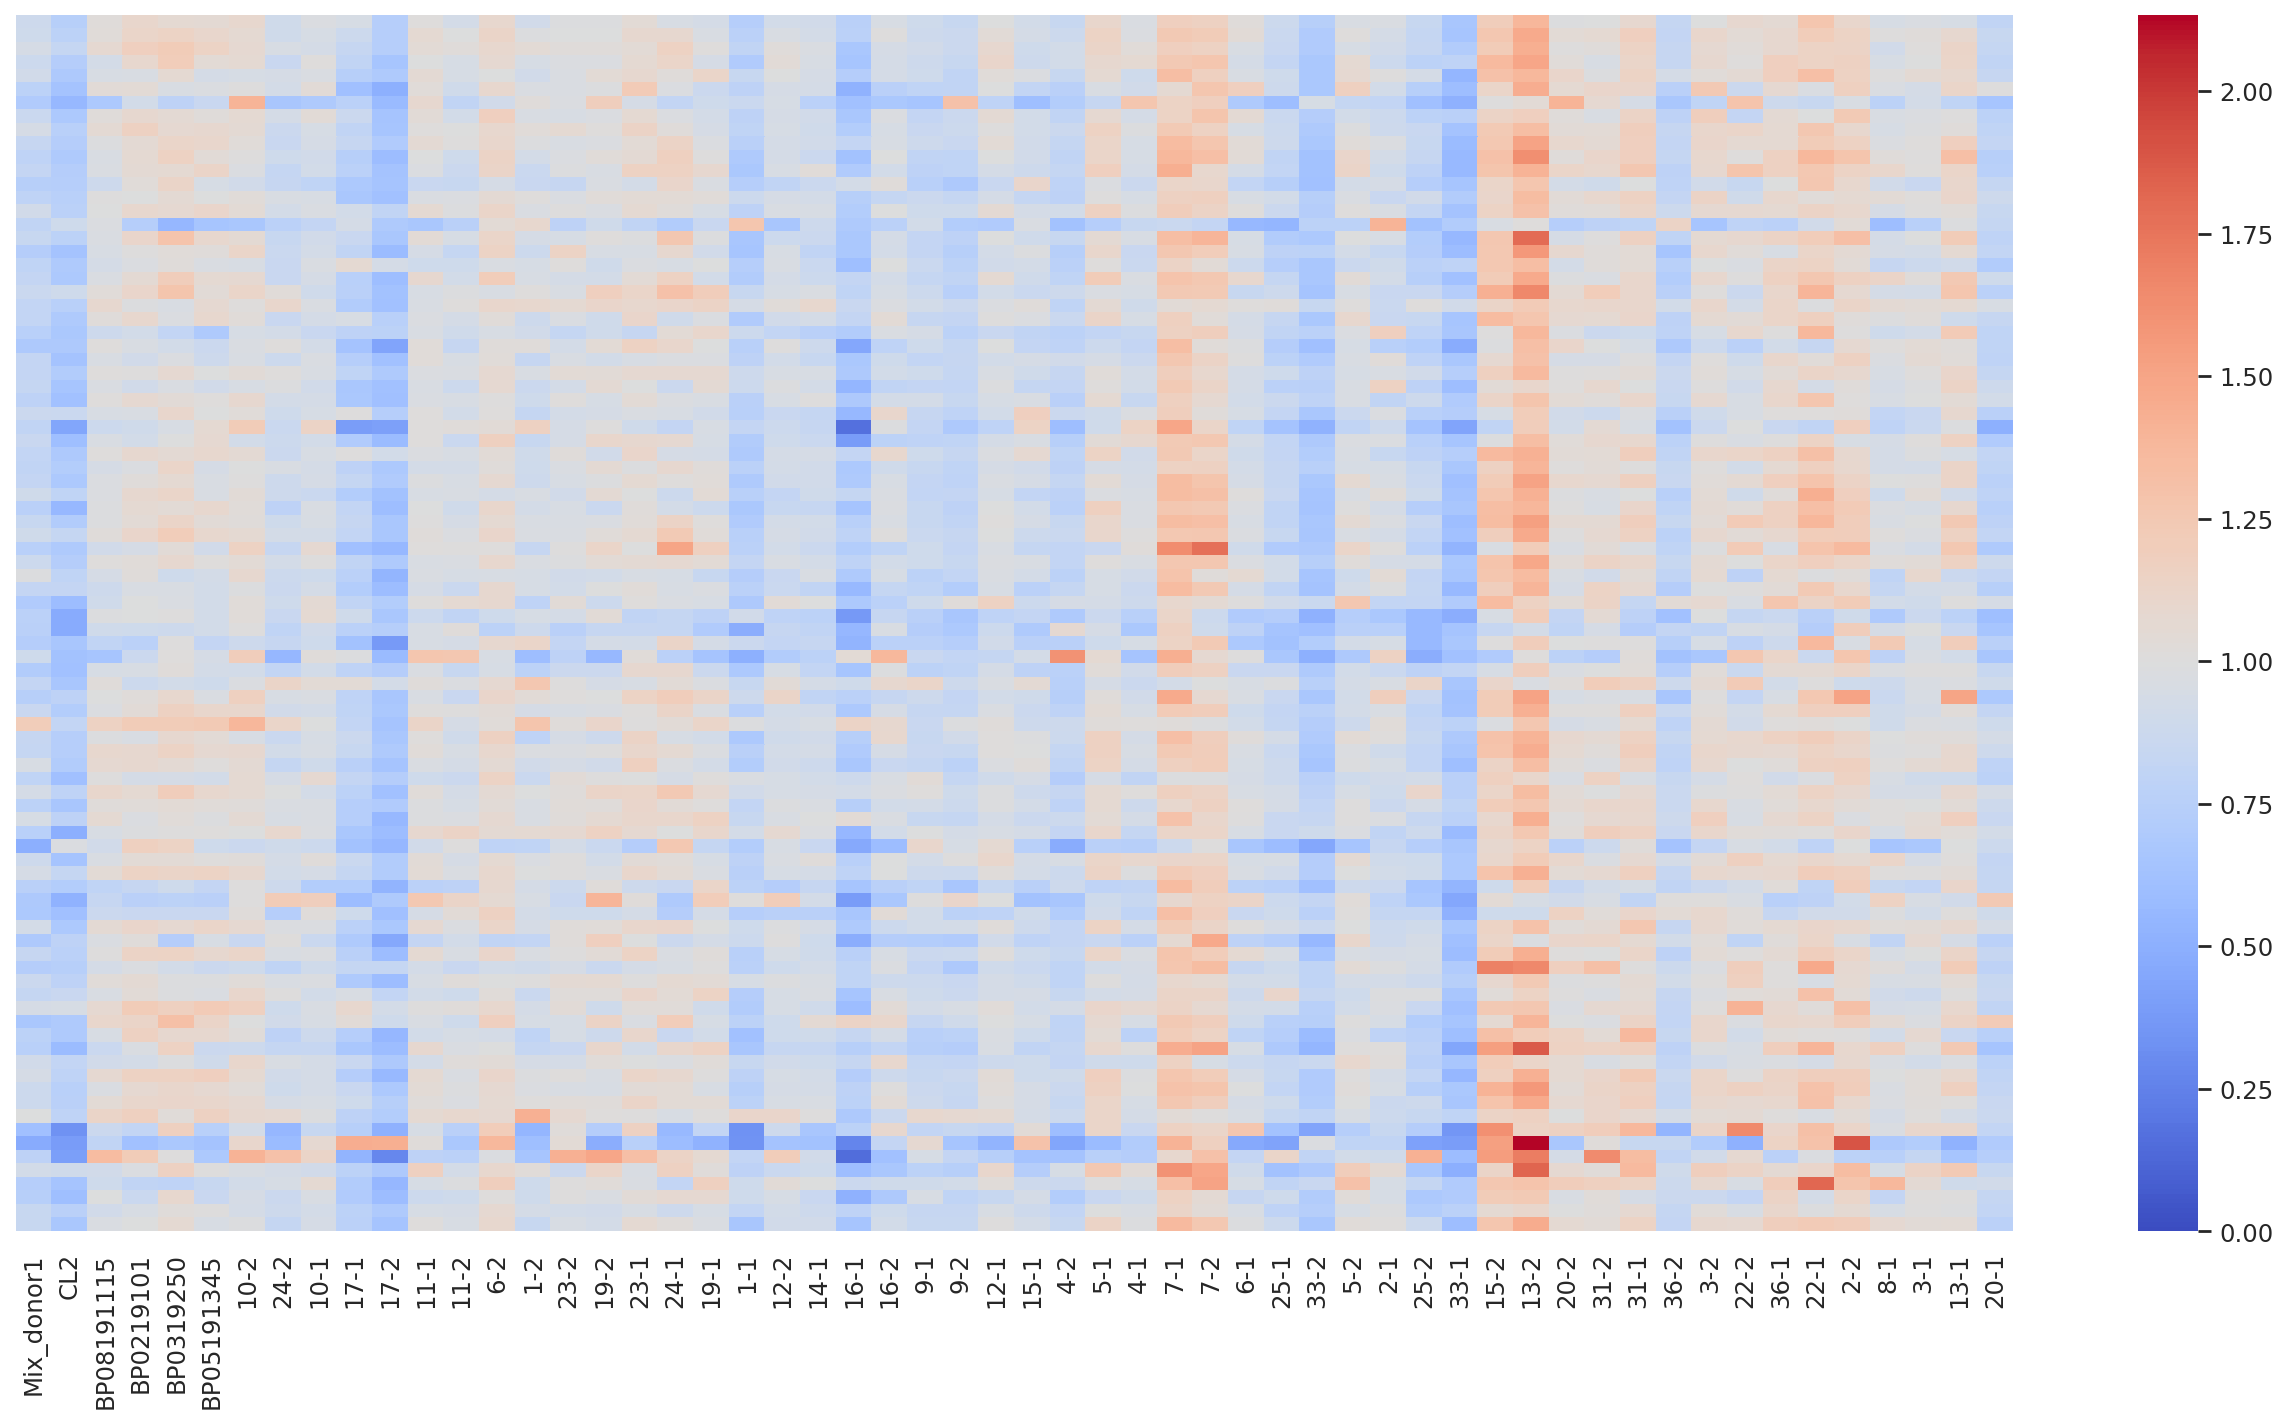

In [62]:
df_p = pd.DataFrame(p)
df_p.index = metab_genes.index
patients = adata.obs['patient'].unique().astype(str)
patients.sort()
df_p.columns = patients

# Plot in order of increasing WHO score
patients_WHO = adata.obs.sort_values(by='WHO_scale', axis=0)['patient'].unique()
#patients_ICU = adata.obs.sort_values(by='ICU_status', axis=0)['patient'].unique()
#patients_age = adata.obs.sort_values(by='Age_at_baseline', axis=0)['patient'].unique()
#patients_days = adata.obs.sort_values(by='Days_since_onset_of_symptoms', axis=0)['patient'].unique()
df_p = df_p.loc[:, patients_WHO]

ax = plt.figure(figsize=(20, 10))
ax = sns.heatmap(df_p, cmap='coolwarm', yticklabels=metab_genes.index, vmin=0,
                     norm=DivergingNorm(1.0))
ax.set_yticks([])
ax.set_ylabel('')
ax.set_xlabel('')

In [63]:
# Statistical significance of higher or lower pathway activity in a specific cell type
# Random permutation test
enriched = (p > 1)
decreased = (p < 1)

# Shuffle cell cluster labels 5000x

n = 5000
compares = np.zeros((len(p), len(p[0])))
for i in range(n):
    if i % 100 == 0:
        print(i)
    clusters_shuffled = np.random.permutation(adata.obs['patient'])
    adata.obs['patient_shuffled'] = clusters_shuffled
    adata_metab.obs['patient_shuffled'] = clusters_shuffled
    
    # Compare new pathway activity scores to original dataset pathway activity scores
    p_shuffle = pathway_activity(adata, adata_metab, 'patient_shuffled')
    compares += enriched * (p_shuffle > p) + decreased * (p_shuffle < p)

compares /= n

# Non-significantly changed activity scores are reverted to 1 (no activity change)
significant = (compares < 0.01)
p_sig = p ** significant

# Save pathway activity scores
df_p = pd.DataFrame(p_sig)
df_p.to_csv(master_dir + 'output/pathway_activity/' + celltype + 
            '-metab-patient-pathway_activity.tabular', 
                       sep='\t', header=None, index=None)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


Text(0.5, 67.5746527777778, '')

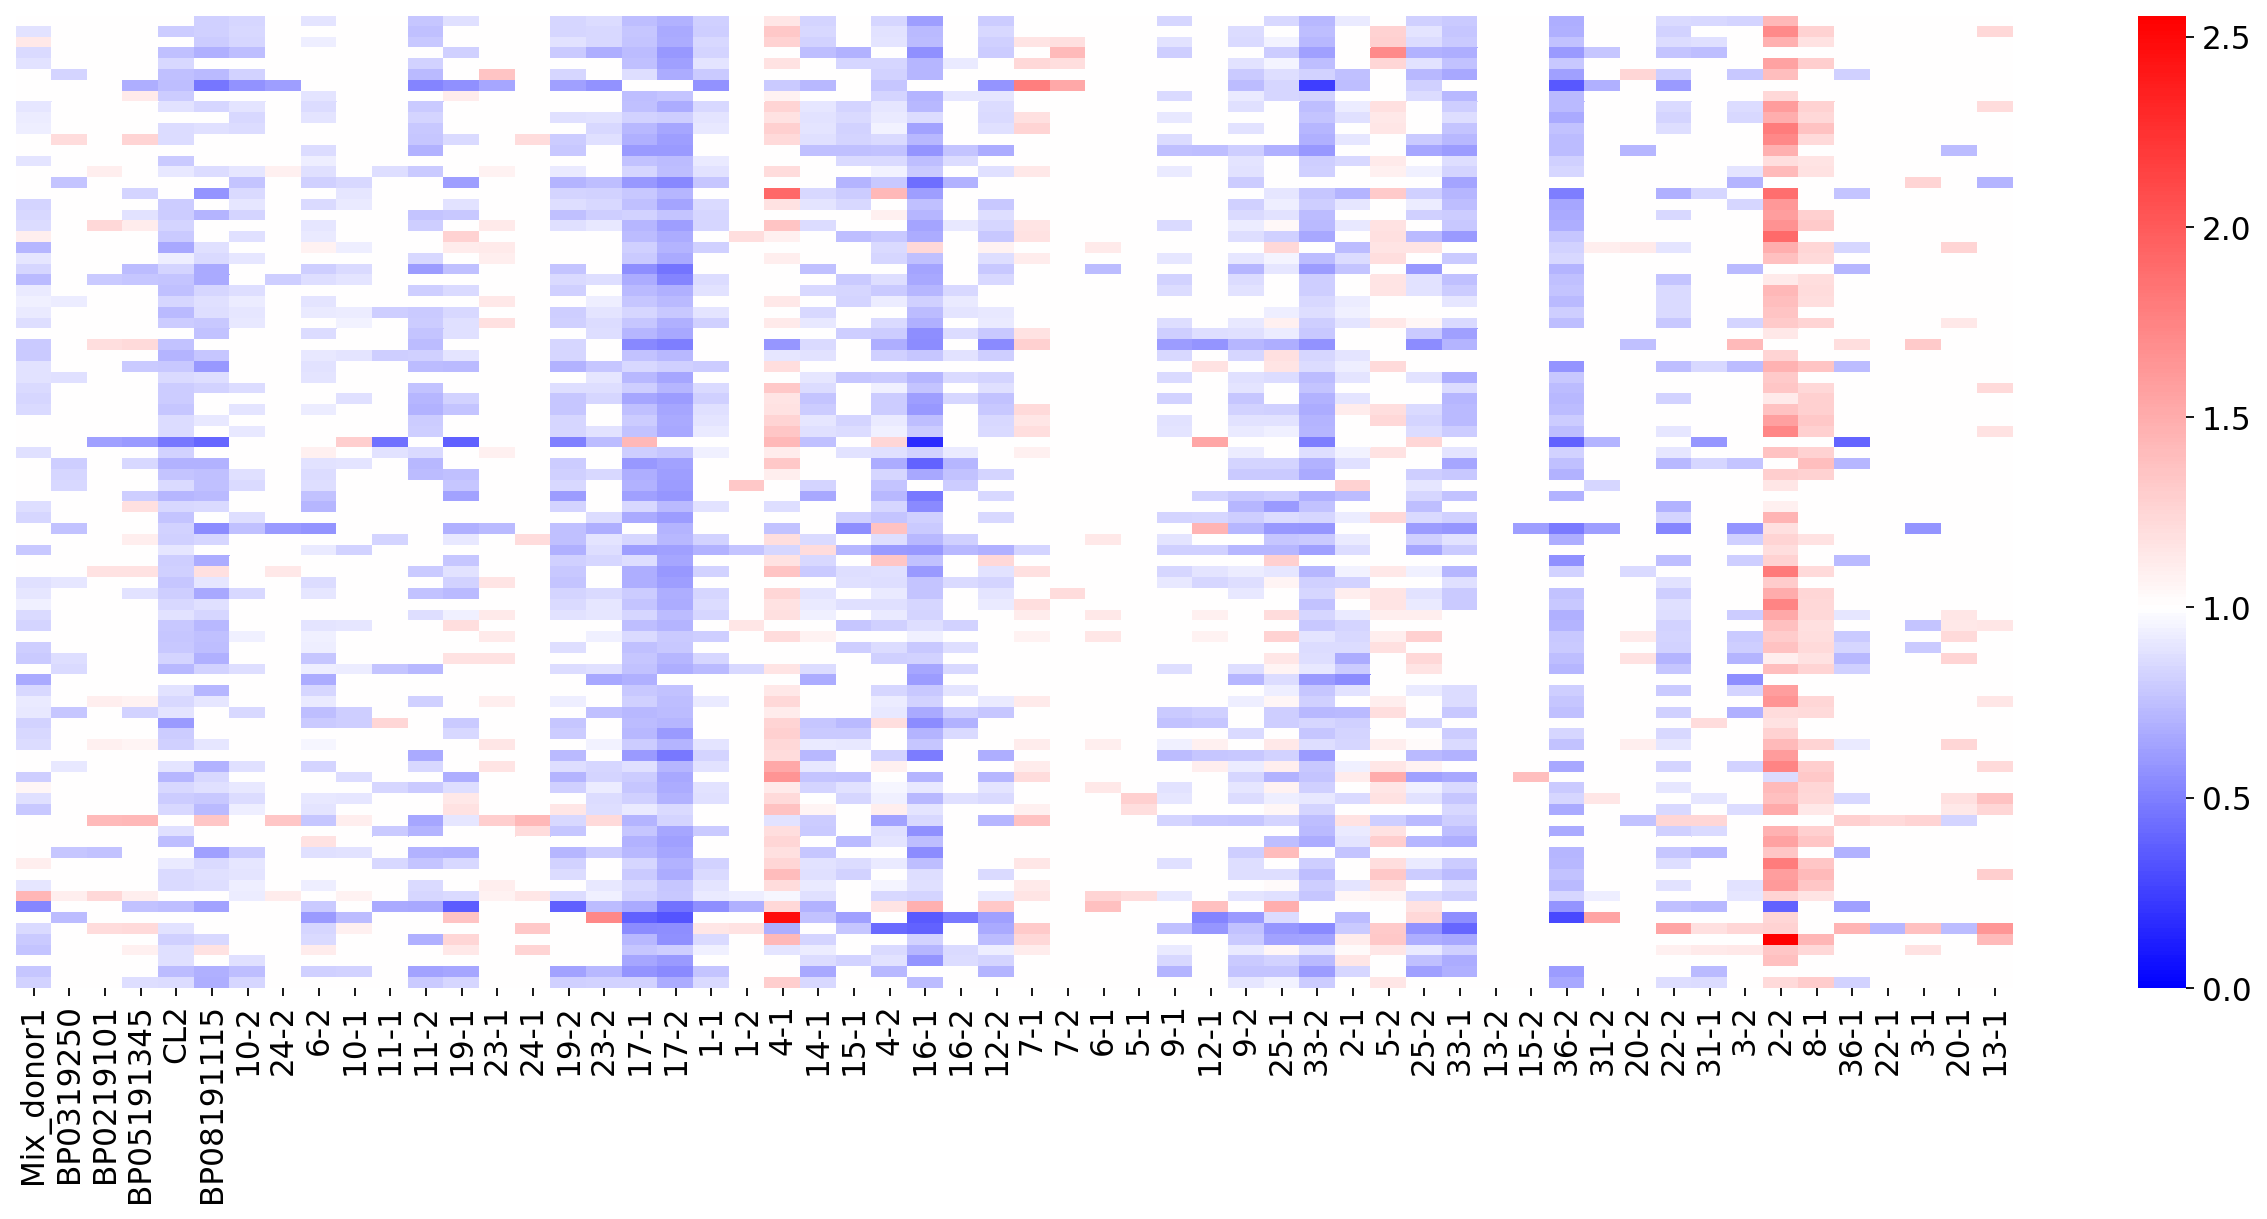

In [35]:
df_p = pd.read_csv(master_dir + 'output/pathway_activity/' + celltype + 
            '-metab-patient-pathway_activity.tabular', 
                       sep='\t', header=None)

#df_p = pd.DataFrame(p_sig)
df_p.index = metab_genes.index
patients = adata.obs['patient'].unique().astype(str)
patients.sort()
df_p.columns = patients

# Plot in order of increasing WHO score
patients_WHO = adata.obs.sort_values(by='WHO_scale', axis=0)['patient'].unique()
#patients_ICU = adata.obs.sort_values(by='ICU_status', axis=0)['patient'].unique()
#patients_age = adata.obs.sort_values(by='Age_at_baseline', axis=0)['patient'].unique()
#patients_days = adata.obs.sort_values(by='Days_since_onset_of_symptoms', axis=0)['patient'].unique()
df_p = df_p.loc[:, patients_WHO]

ax = plt.figure(figsize=(20, 8))
ax = sns.heatmap(df_p, cmap='bwr', yticklabels=metab_genes.index, vmin=0,
                     norm=DivergingNorm(1.0))
ax.set_yticks([])
ax.set_ylabel('')
ax.set_xlabel('')

<Figure size 320x320 with 0 Axes>

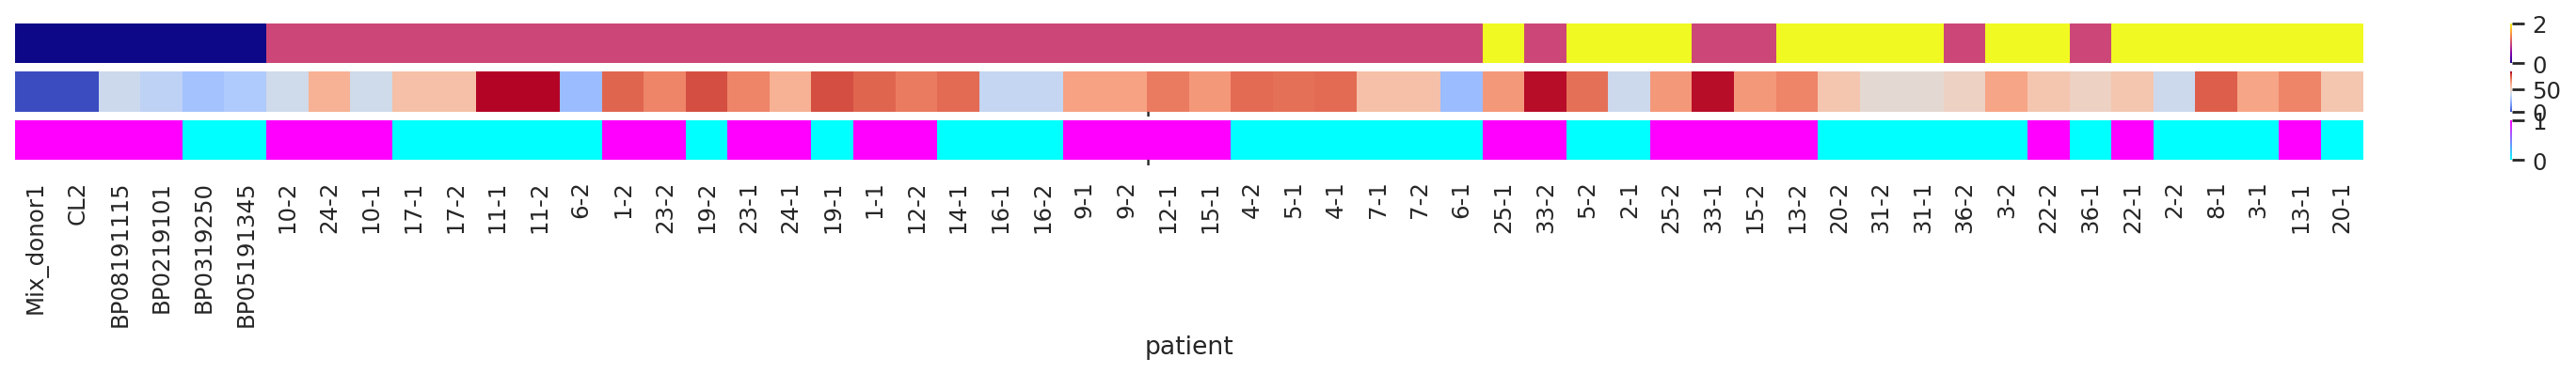

<Figure size 1280x24 with 0 Axes>

<Figure size 1280x24 with 0 Axes>

<Figure size 1280x24 with 0 Axes>

In [29]:
# Other patient attributes
adata_obs_by_patient = adata.obs.copy()
adata_obs_by_patient.index = adata_obs_by_patient['patient']
#adata_obs_by_patient.groupby(by='patient').first()
adata_obs_by_patient = adata_obs_by_patient.reset_index(drop=True)
adata_obs_by_patient = adata_obs_by_patient.groupby(by='patient').first() # All characteristics except clustering should be the same
adata_obs_by_patient['WHO_scale'] = adata_obs_by_patient['WHO_scale'].astype(int)
adata_obs_by_patient['Age_at_baseline'] = adata_obs_by_patient['Age_at_baseline'].str.replace('Not Recorded', 
                                                                                              '0').astype(int)
adata_obs_by_patient['Age_at_baseline'] = adata_obs_by_patient['Age_at_baseline'].astype(int)

# Plotting the other patient attributes
sns.set(style='white')
#sns.set(style='ticks')
sns.despine()

f, axes = plt.subplots(3, 1, figsize=(25, 1.2), sharex=False, sharey=False)

#df = adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']]
#fig = plt.figure(figsize=(16, 0.3))
#fig = sns.heatmap(df.transpose(), xticklabels=[''], yticklabels=[''],
#                 cmap='Oranges', ax=axes[0])

df = adata_obs_by_patient.loc[patients_WHO, ['ICU_status']]
df['ICU_status'] = df['ICU_status'].map({'Healthy': 0, 'Non-ICU': 1, 'ICU': 2}).astype(int)
fig = plt.figure(figsize=(16, 0.3))
fig = sns.heatmap(df.transpose(), xticklabels=[''], yticklabels=[''],
                 cmap='plasma', ax=axes[0])

#df = adata_obs_by_patient.loc[patients_WHO, ['no_IL6i']]
#df['no_IL6i'] = df['no_IL6i'].map({'Healthy': 0, 'before': 1, 'after': 2, 'no': 3}).astype(int)
#fig = plt.figure(figsize=(16, 0.3))
#fig = sns.heatmap(df.transpose(), xticklabels=[''], yticklabels=[''],
#                 cmap='viridis', ax=axes[2])

df = adata_obs_by_patient.loc[patients_WHO, ['Age_at_baseline']]
fig = plt.figure(figsize=(16, 0.3))
fig = sns.heatmap(df.transpose(), xticklabels=[''], yticklabels=[''], vmin=0,
                 cmap='coolwarm', ax=axes[1])

df = adata_obs_by_patient.loc[patients_WHO, ['Sex']]
df['Sex'] = df['Sex'].map({'Female': 1, 'Male': 0}).astype(int)
fig = plt.figure(figsize=(16, 0.3))
fig = sns.heatmap(df.transpose(), xticklabels=patients_WHO, yticklabels=[''],
                 cmap='cool', ax=axes[2])

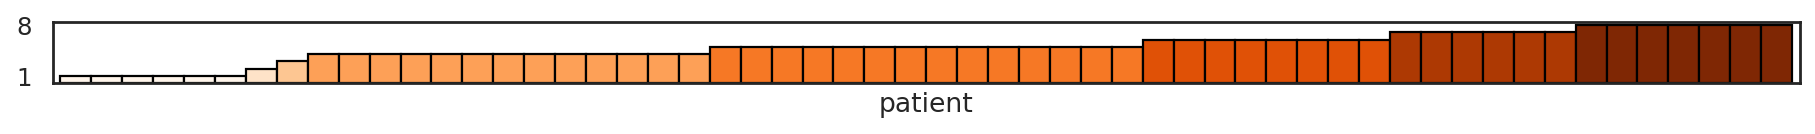

In [30]:
df = adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']]
df['WHO_scale'] += 1 # Add 1 to all values in order to make all bars visible
fig = plt.figure(figsize=(14, 0.5))
oranges = cm.get_cmap('Oranges', 8)
df['c'] = [oranges(s - 1) for s in df['WHO_scale']]
fig = df['WHO_scale'].plot(kind='bar', color=df['c'], edgecolor='black', width=1)
#fig = plt.bar(x=df.index, height=df['WHO_scale'] + 1, color='brown')
                  #cmap='Oranges')
fig = plt.yticks([1, 8])
fig = plt.xticks([])

In [31]:
# For correlation, not using the statistically deleted values (need raw values)
df_p = pd.DataFrame(p)
df_p.index = metab_genes.index
patients = adata.obs['patient'].unique().astype(str)
patients.sort()
df_p.columns = patients

# Plot in order of increasing WHO score
patients_WHO = adata.obs.sort_values(by='WHO_scale', axis=0)['patient'].unique()
#patients_ICU = adata.obs.sort_values(by='ICU_status', axis=0)['patient'].unique()
#patients_age = adata.obs.sort_values(by='Age_at_baseline', axis=0)['patient'].unique()
#patients_days = adata.obs.sort_values(by='Days_since_onset_of_symptoms', axis=0)['patient'].unique()
df_p = df_p.loc[:, patients_WHO]

spr_corr = df_p.apply(lambda col: spearmanr(col, adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']])[0], 
                      axis=1)
spr_pvalues = df_p.apply(lambda col: spearmanr(col, adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']])[1], 
                         axis=1)

sig_pathways = pd.DataFrame([spr_corr, spr_pvalues]).transpose()
sig_pathways = sig_pathways[sig_pathways.loc[:, 1]<0.05]
sig_pathways.columns = ['Spearman', 'p-value']
sig_pathways['Spearman_abs'] = abs(sig_pathways['Spearman'])
sig_pathways['-log10(p)'] = -np.log10(sig_pathways['p-value'])
sig_pathways = sig_pathways.sort_values(by='Spearman_abs', ascending=False)
pd.DataFrame(sig_pathways).to_csv(master_dir + 'output/pathway_activity/pathway_activity_trends/' + 
                                 celltype + '-all_cells' + '.csv')
sig_pathways

Spearman   p-value  \
0                                                                     
Aflatoxin biosynthesis                           0.447202  0.000549   
Vitamin B6 metabolism                            0.431859  0.000889   
D-Glutamine and D-glutamate metabolism          -0.407294  0.001837   
Caffeine metabolism                              0.349850  0.008215   
Drug metabolism - other enzymes                  0.332418  0.012311   
Glutathione metabolism                           0.330365  0.012893   
Fructose and mannose metabolism                  0.312412  0.019070   
Tyrosine metabolism                             -0.293797  0.027967   
Histidine metabolism                             0.291605  0.029214   
Primary bile acid biosynthesis                   0.284125  0.033822   
Glycosphingolipid biosynthesis - ganglio series  0.280924  0.035970   
One carbon pool by folate                        0.274487  0.040634   
Pyrimidine metabolism                            0.271286  0.043132   

                                                 Spearman_abs  -log10(p)  
0                                                                         
Aflatoxin biosynthesis                               0.447202   3.260125  
Vitamin B6 metabolism                                0.431859   3.051032  
D-Glutamine and D-glutamate metabolism               0.407294   2.735984  
Caffeine metabolism                                  0.349850   2.085370  
Drug metabolism - other enzymes                      0.332418   1.909722  
Glutathione metabolism                               0.330365   1.889661  
Fructose and mannose metabolism                      0.312412   1.719644  
Tyrosine metabolism                                  0.293797   1.553348  
Histidine metabolism                                 0.291605   1.534414  
Primary bile acid biosynthesis                       0.284125   1.470804  
Glycosphingolipid biosynthesis - ganglio series      0.280924   1.444057  
One carbon pool by folate                            0.274487   1.391114  
Pyrimidine metabolism                                0.271286   1.365201

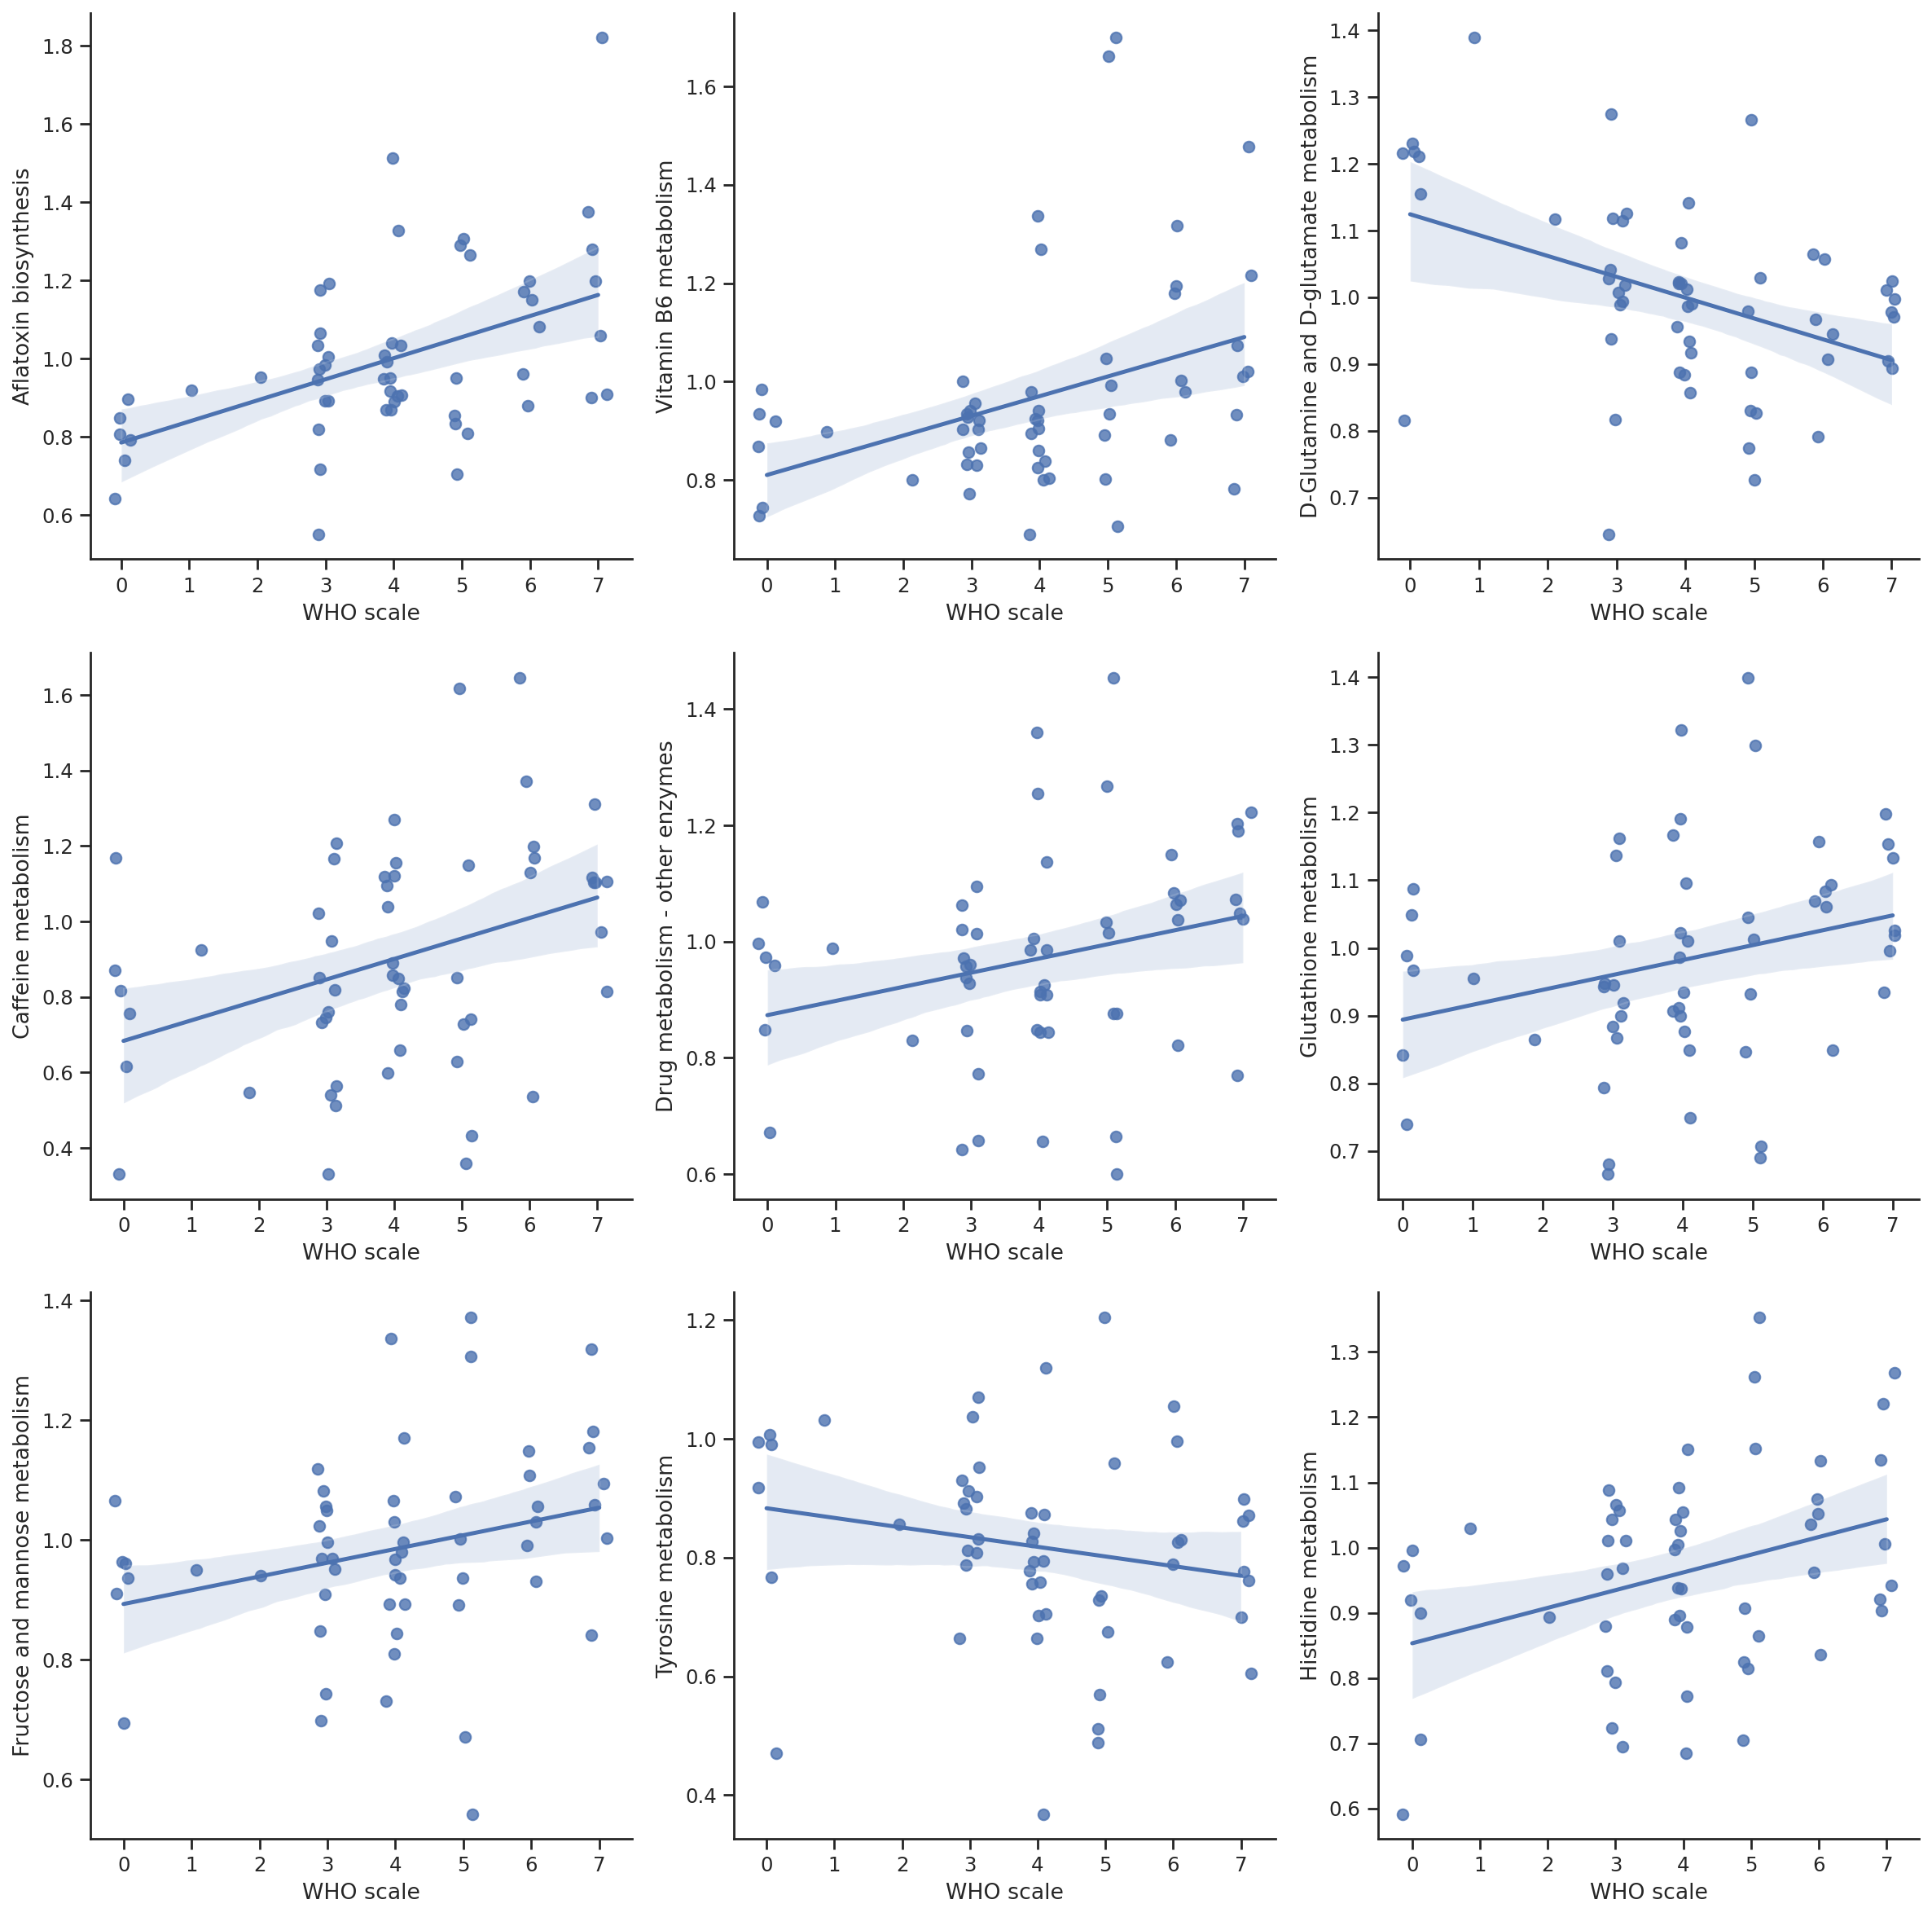

In [32]:
# Plot the top corresponding ones
sns.set_style('white')
sns.set_style('ticks')
f, axes = plt.subplots(3, 3, figsize=(15, 15), sharex=False, sharey=False)
sns.despine()

k = 0
x = adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']]
for i in range(3):
    for j in range(3):
        f = sns.regplot(x=x, y=df_p.loc[sig_pathways.index[k]], x_jitter=0.15, ax=axes[i, j])
        f.set_ylabel(sig_pathways.index[k])
        f.set_xlabel('WHO scale')
        f.set_xticks(range(8))
        k += 1

plt.tight_layout()

#### Correlating pathway activity plotting functions

In [33]:
def plot_corresponding(df_all, sig_pathways, orig_adata, figsize=(15, 3), cmap='coolwarm'):
    # Plot the top corresponding ones
    df_p_corresponding = pd.DataFrame(df_all)
    df_p_corresponding.index = metab_genes.index
    patients = orig_adata.obs['patient'].unique().astype(str)
    patients.sort()
    df_p_corresponding.columns = patients

    patients_WHO = orig_adata.obs.sort_values(by='WHO_scale', axis=0)['patient'].unique()
    #patients_ICU = adata.obs.sort_values(by='ICU_status', axis=0)['patient'].unique()
    #patients_age = adata.obs.sort_values(by='Age_at_baseline', axis=0)['patient'].unique()
    #patients_days = adata.obs.sort_values(by='Days_since_onset_of_symptoms', axis=0)['patient'].unique()
    df_p_corresponding = df_p_corresponding.loc[sig_pathways.index, patients_WHO]

    # When plotting, sort by metabolic pathway group first, then by spearman r
    df_p_corresponding['category'] = df_p_corresponding.index.map(classifications)
    df_p_corresponding['Spearman'] = sig_pathways['Spearman']
    df_p_corresponding = df_p_corresponding.sort_values(by=['category', 'Spearman'], ascending=[True, False])
    print(df_p_corresponding['category'])
    df_p_corresponding = df_p_corresponding.drop(columns=['category', 'Spearman'])

    ax = plt.figure(figsize=figsize)
    ax = sns.heatmap(df_p_corresponding, cmap=cmap, yticklabels=[], vmin=0,
                         norm=DivergingNorm(1.0))
    #ax.set_yticks([])
    ax.set_ylabel('')
    ax.set_xlabel('')
    
    return df_p_corresponding

def plot_spearman_dots(sig_pathways, df_corresponding, figsize=(5, 3)):
    # Dot plot for the significant ones
    sns.set_style('white')
    sns.set_style('ticks')
    fig = plt.figure(figsize=figsize)
    fig = sns.scatterplot(x=np.zeros(len(sig_pathways)), y=np.arange(0, len(sig_pathways), 1)[::-1], 
                          hue='Spearman', size='-log10(p)', hue_order=np.arange(0, 0.5, 0.1), 
                          sizes=(10, 40), data=sig_pathways.loc[df_corresponding.index])
    fig.legend(loc='right', bbox_to_anchor=(1.25, 0.5), ncol=1, fontsize=6)
    sns.despine()

0
Histidine metabolism                                                     Amino acid metabolism
Tyrosine metabolism                                                      Amino acid metabolism
Aflatoxin biosynthesis                             Biosynthesis of other secondary metabolites
Caffeine metabolism                                Biosynthesis of other secondary metabolites
Fructose and mannose metabolism                                        Carbohydrate metabolism
Glycosphingolipid biosynthesis - ganglio series             Glycan biosynthesis and metabolism
Primary bile acid biosynthesis                                                Lipid metabolism
Vitamin B6 metabolism                                     Metabolism of cofactors and vitamins
One carbon pool by folate                                 Metabolism of cofactors and vitamins
Glutathione metabolism                                         Metabolism of other amino acids
D-Glutamine and D-glutamate metabolism          

<ipython-input-33-bfdb14604942>:24: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(1.0))


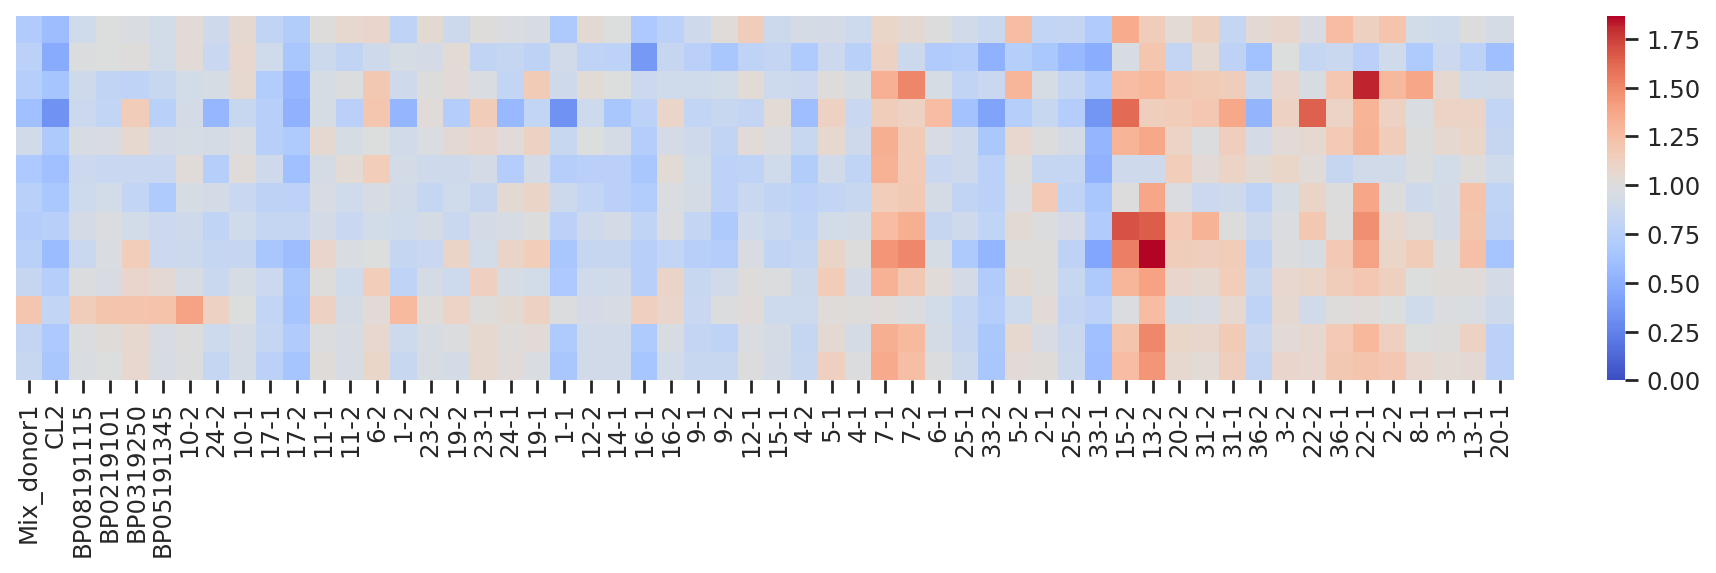

In [34]:
df_corresponding = plot_corresponding(p, sig_pathways, adata)

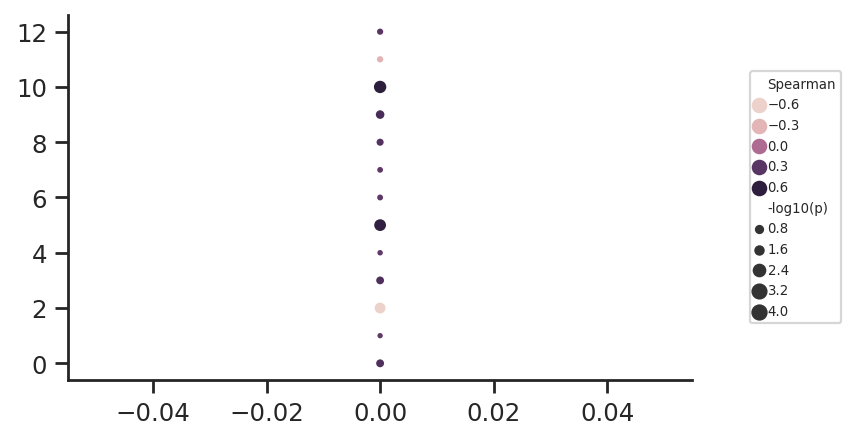

In [36]:
plot_spearman_dots(sig_pathways, df_corresponding)

#### Proliferative only (metabolic cluster 4)

In [37]:
prolif = ['4']
adata_prolif = adata[adata.obs['louvain_metab'].isin(prolif)].copy()
adata_metab_prolif = adata_metab[adata.obs['louvain_metab'].isin(prolif)].copy()
# Not using subpopulations here for now
p = pathway_activity(adata_prolif, adata_metab_prolif, 'patient', print_labels=True)

/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


1-1
1-2
10-1
10-2
11-1
11-2
12-1
12-2
13-1
13-2
14-1
15-1
15-2
16-1
16-2
17-1
17-2
19-1
19-2
2-1
2-2
20-1
20-2
22-1
22-2
23-1
23-2
24-1
24-2
25-1
25-2
3-1
3-2
31-1
31-2
33-2
36-1
36-2
4-1
4-2
5-1
5-2
6-1
6-2
7-1
7-2
8-1
9-1
9-2
BP0219101
BP0319250
BP05191345
BP08191115
CL2
Mix_donor1


<ipython-input-39-b07acb08315b>:16: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(1.0))


Text(0.5, 92.00000000000001, '')

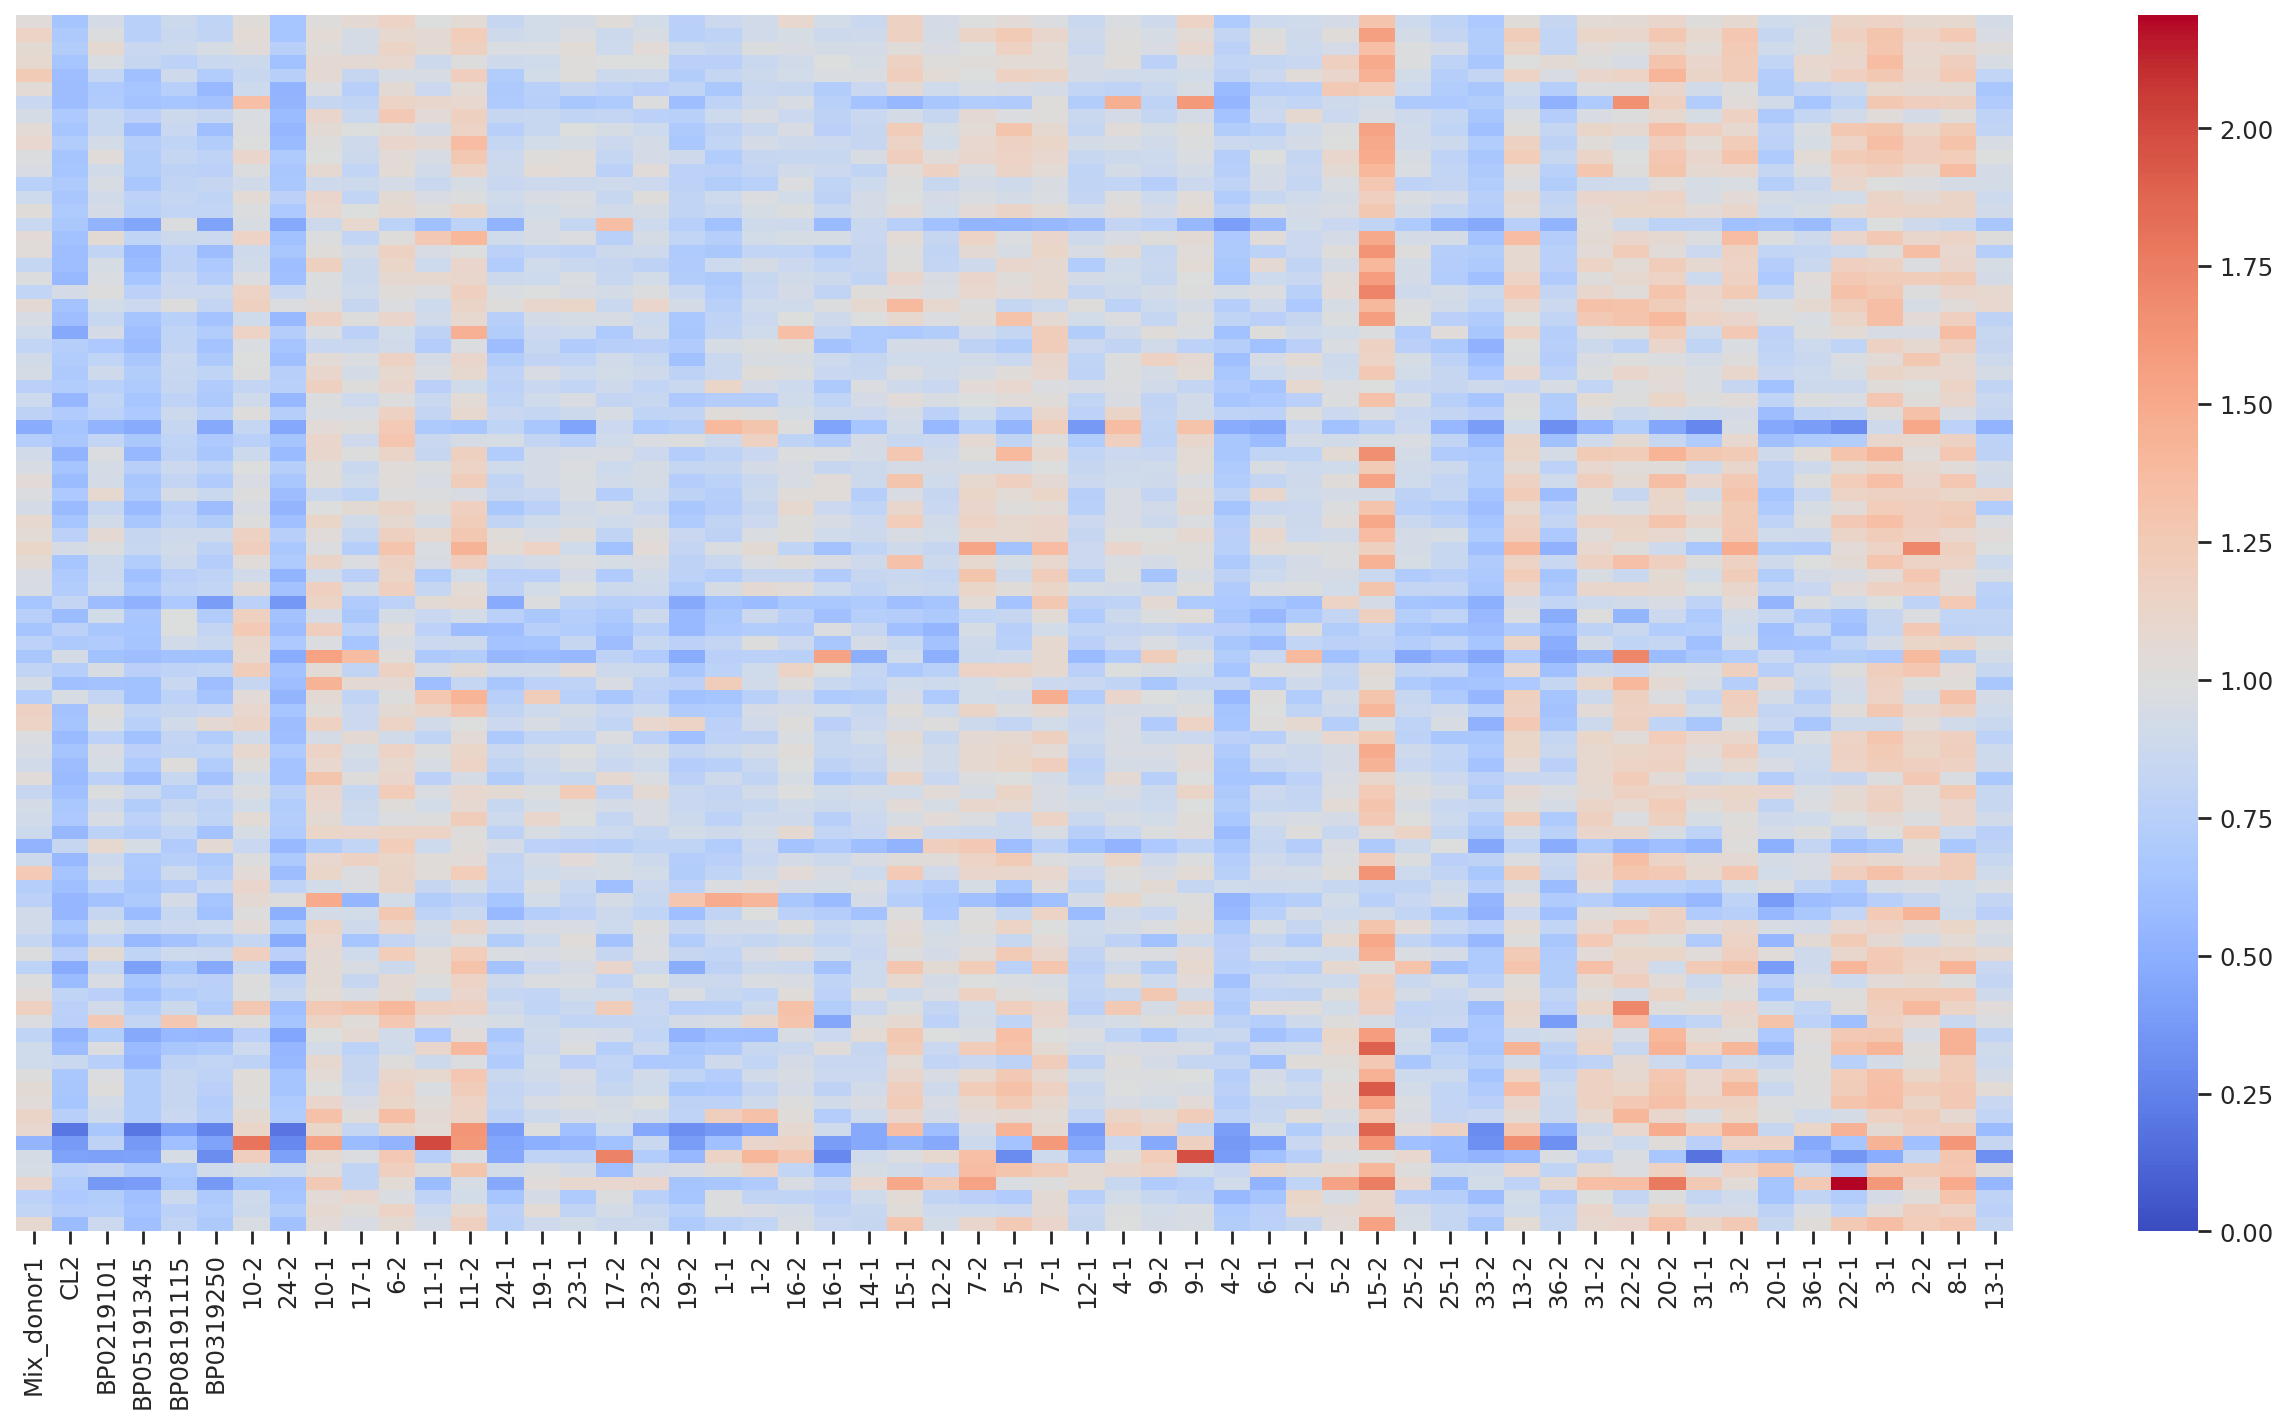

In [39]:
df_p = pd.DataFrame(p)
df_p.index = metab_genes.index
patients = adata_prolif.obs['patient'].unique().astype(str)
patients.sort()
df_p.columns = patients

# Plot in order of increasing WHO score
patients_WHO = adata_prolif.obs.sort_values(by='WHO_scale', axis=0)['patient'].unique()
#patients_ICU = adata.obs.sort_values(by='ICU_status', axis=0)['patient'].unique()
#patients_age = adata.obs.sort_values(by='Age_at_baseline', axis=0)['patient'].unique()
#patients_days = adata.obs.sort_values(by='Days_since_onset_of_symptoms', axis=0)['patient'].unique()
df_p = df_p.loc[:, patients_WHO]

ax = plt.figure(figsize=(20, 10))
ax = sns.heatmap(df_p, cmap='coolwarm', yticklabels=metab_genes.index, vmin=0,
                     norm=DivergingNorm(1.0))
ax.set_yticks([])
ax.set_ylabel('')
ax.set_xlabel('')

In [ ]:
# Statistical significance of higher or lower pathway activity in a specific cell type
# Random permutation test
enriched = (p > 1)
decreased = (p < 1)

# Shuffle cell cluster labels 5000x

n = 5000
compares = np.zeros((len(p), len(p[0])))
for i in range(n):
    if i % 100 == 0:
        print(i)
    clusters_shuffled = np.random.permutation(adata_effectors.obs['patient'])
    adata_effectors.obs['patient_shuffled'] = clusters_shuffled
    adata_metab_effectors.obs['patient_shuffled'] = clusters_shuffled
    
    # Compare new pathway activity scores to original dataset pathway activity scores
    p_shuffle = pathway_activity(adata_effectors, adata_metab_effectors, 'patient_shuffled')
    compares += enriched * (p_shuffle > p) + decreased * (p_shuffle < p)

compares /= n

# Non-significantly changed activity scores are reverted to 1 (no activity change)
significant = (compares < 0.01)
p_sig = p ** significant

# Save pathway activity scores
df_p = pd.DataFrame(p_sig)
df_p.to_csv(master_dir + 'output/pathway_activity/' + celltype + 
            '-metab-patient-cluster_0_2_8-pathway_activity.tabular', 
                       sep='\t', header=None, index=None)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


In [ ]:
df_p = pd.DataFrame(p_sig)
df_p.index = metab_genes.index
patients = adata.obs['patient'].unique().astype(str)
patients.sort()
df_p.columns = patients

# Plot in order of increasing WHO score
patients_WHO = adata.obs.sort_values(by='WHO_scale', axis=0)['patient'].unique()
#patients_ICU = adata.obs.sort_values(by='ICU_status', axis=0)['patient'].unique()
#patients_age = adata.obs.sort_values(by='Age_at_baseline', axis=0)['patient'].unique()
#patients_days = adata.obs.sort_values(by='Days_since_onset_of_symptoms', axis=0)['patient'].unique()
df_p = df_p.loc[:, patients_WHO]

ax = plt.figure(figsize=(20, 10))
ax = sns.heatmap(df_p, cmap='bwr', yticklabels=metab_genes.index, vmin=0,
                     norm=DivergingNorm(1.0))
ax.set_yticks([])
ax.set_ylabel('')
ax.set_xlabel('')

In [41]:
df_p = pd.DataFrame(p)
df_p.index = metab_genes.index
patients = adata_prolif.obs['patient'].unique().astype(str)
patients.sort()
df_p.columns = patients

# Plot in order of increasing WHO score
patients_WHO = adata_prolif.obs.sort_values(by='WHO_scale', axis=0)['patient'].unique()
#patients_ICU = adata.obs.sort_values(by='ICU_status', axis=0)['patient'].unique()
#patients_age = adata.obs.sort_values(by='Age_at_baseline', axis=0)['patient'].unique()
#patients_days = adata.obs.sort_values(by='Days_since_onset_of_symptoms', axis=0)['patient'].unique()
df_p = df_p.loc[:, patients_WHO]

spr_corr = df_p.apply(lambda col: spearmanr(col, adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']])[0], 
                      axis=1)
spr_pvalues = df_p.apply(lambda col: spearmanr(col, adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']])[1], 
                         axis=1)

sig_pathways = pd.DataFrame([spr_corr, spr_pvalues]).transpose()
sig_pathways = sig_pathways[sig_pathways.loc[:, 1]<0.05]
sig_pathways.columns = ['Spearman', 'p-value']
sig_pathways['Spearman_abs'] = abs(sig_pathways['Spearman'])
sig_pathways = sig_pathways.sort_values(by='Spearman_abs', ascending=False)
sig_pathways['-log10(p)'] = -np.log10(sig_pathways['p-value'])
pd.DataFrame(sig_pathways).to_csv(master_dir + 'output/pathway_activity/pathway_activity_trends/' + 
                                 celltype + '-metab_cluster_3' + '.csv')
sig_pathways

Spearman   p-value  \
0                                                                        
Folate biosynthesis                                 0.531474  0.000030   
Steroid biosynthesis                                0.508912  0.000073   
Aflatoxin biosynthesis                              0.502886  0.000091   
Ubiquinone and other terpenoid-quinone biosynth...  0.489144  0.000151   
Glutathione metabolism                              0.486682  0.000165   
...                                                      ...       ...   
Retinol metabolism                                  0.282750  0.036470   
Alanine, aspartate and glutamate metabolism         0.278965  0.039162   
Glycosaminoglycan biosynthesis - chondroitin su...  0.275621  0.041675   
Purine metabolism                                   0.274813  0.042302   
Arginine and proline metabolism                     0.266766  0.048978   

                                                    Spearman_abs  -log10(p)  
0                                                                            
Folate biosynthesis                                     0.531474   4.526079  
Steroid biosynthesis                                    0.508912   4.138867  
Aflatoxin biosynthesis                                  0.502886   4.039980  
Ubiquinone and other terpenoid-quinone biosynth...      0.489144   3.821260  
Glutathione metabolism                                  0.486682   3.783048  
...                                                          ...        ...  
Retinol metabolism                                      0.282750   1.438070  
Alanine, aspartate and glutamate metabolism             0.278965   1.407135  
Glycosaminoglycan biosynthesis - chondroitin su...      0.275621   1.380121  
Purine metabolism                                       0.274813   1.373634  
Arginine and proline metabolism                         0.266766   1.310000  

[61 rows x 4 columns]

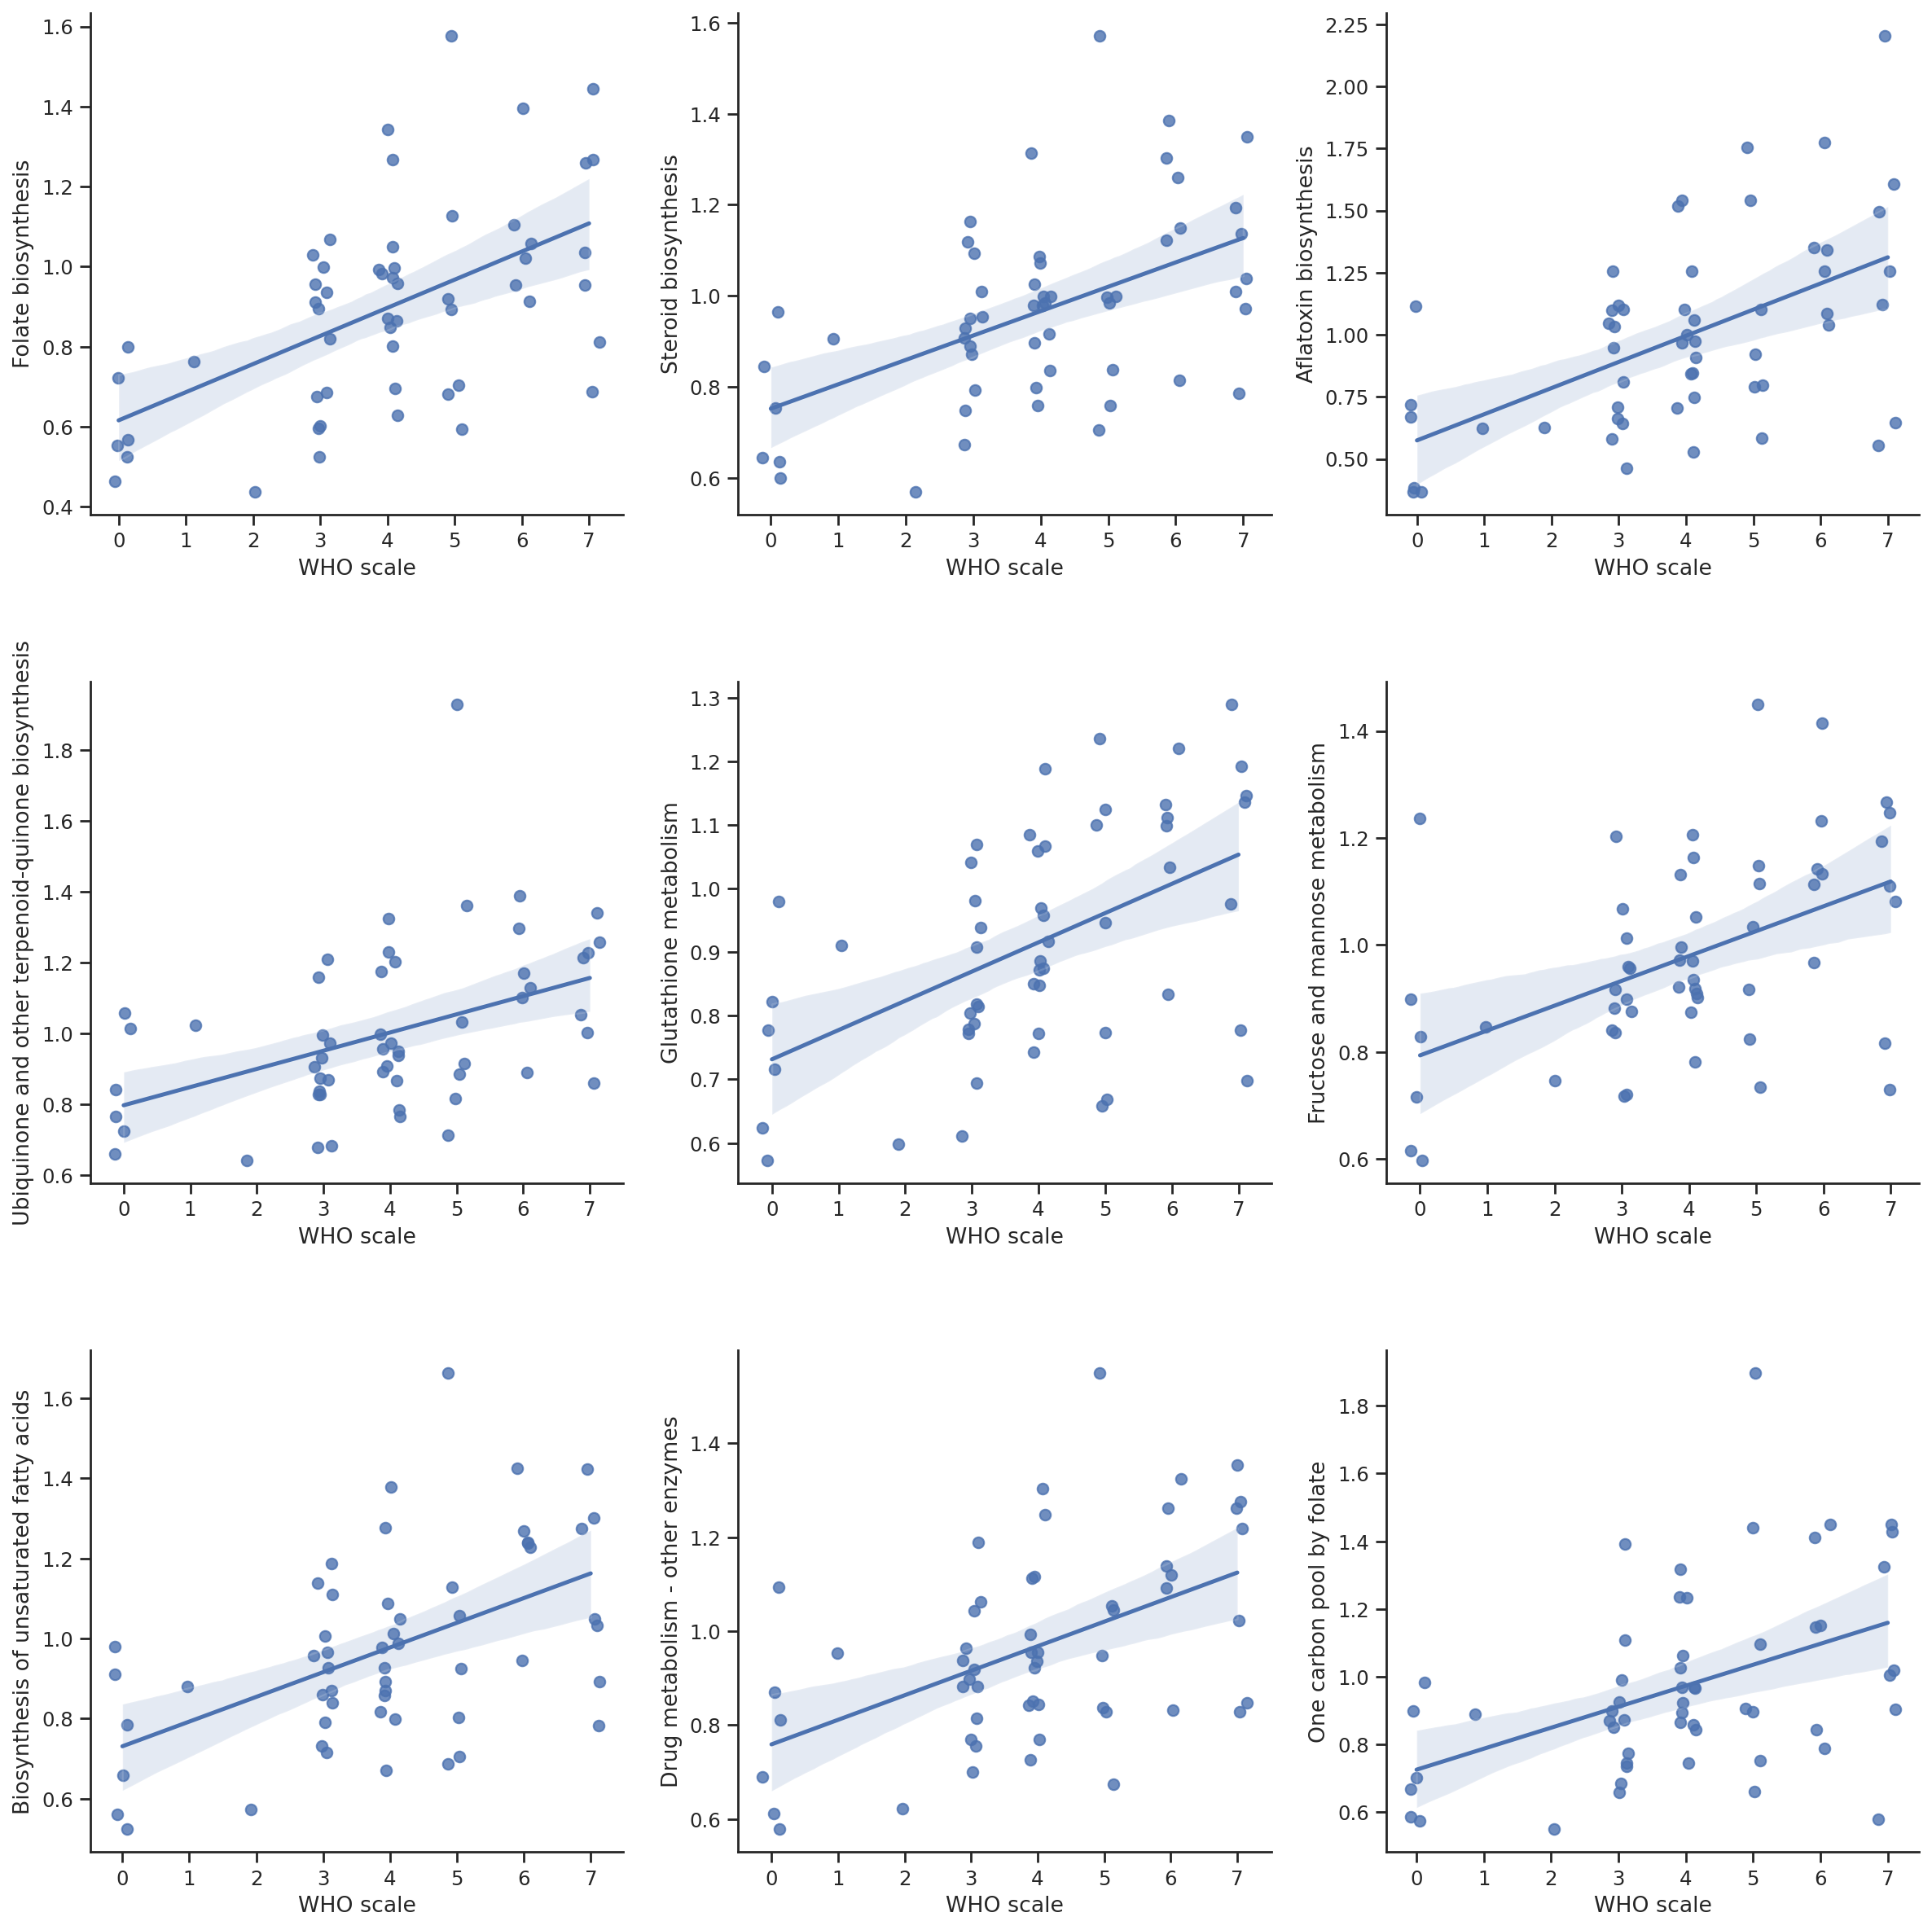

In [42]:
# Plot the top corresponding ones
sns.set_style('white')
sns.set_style('ticks')
f, axes = plt.subplots(3, 3, figsize=(15, 15), sharex=False, sharey=False)
sns.despine()

k = 0
x = adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']]
for i in range(3):
    for j in range(3):
        f = sns.regplot(x=x, y=df_p.loc[sig_pathways.index[k]], x_jitter=0.15, ax=axes[i, j])
        f.set_ylabel(sig_pathways.index[k])
        f.set_xlabel('WHO scale')
        f.set_xticks(range(8))
        k += 1

plt.tight_layout()

0
Cysteine and methionine metabolism                           Amino acid metabolism
Glycine, serine and threonine metabolism                     Amino acid metabolism
Lysine degradation                                           Amino acid metabolism
Arginine biosynthesis                                        Amino acid metabolism
Histidine metabolism                                         Amino acid metabolism
                                                             ...                  
Taurine and hypotaurine metabolism                 Metabolism of other amino acids
Pyrimidine metabolism                                        Nucleotide metabolism
Purine metabolism                                            Nucleotide metabolism
Drug metabolism - other enzymes             Xenobiotics degradation and metabolism
Drug metabolism - cytochrome P450           Xenobiotics degradation and metabolism
Name: category, Length: 61, dtype: object


<ipython-input-33-bfdb14604942>:24: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(1.0))


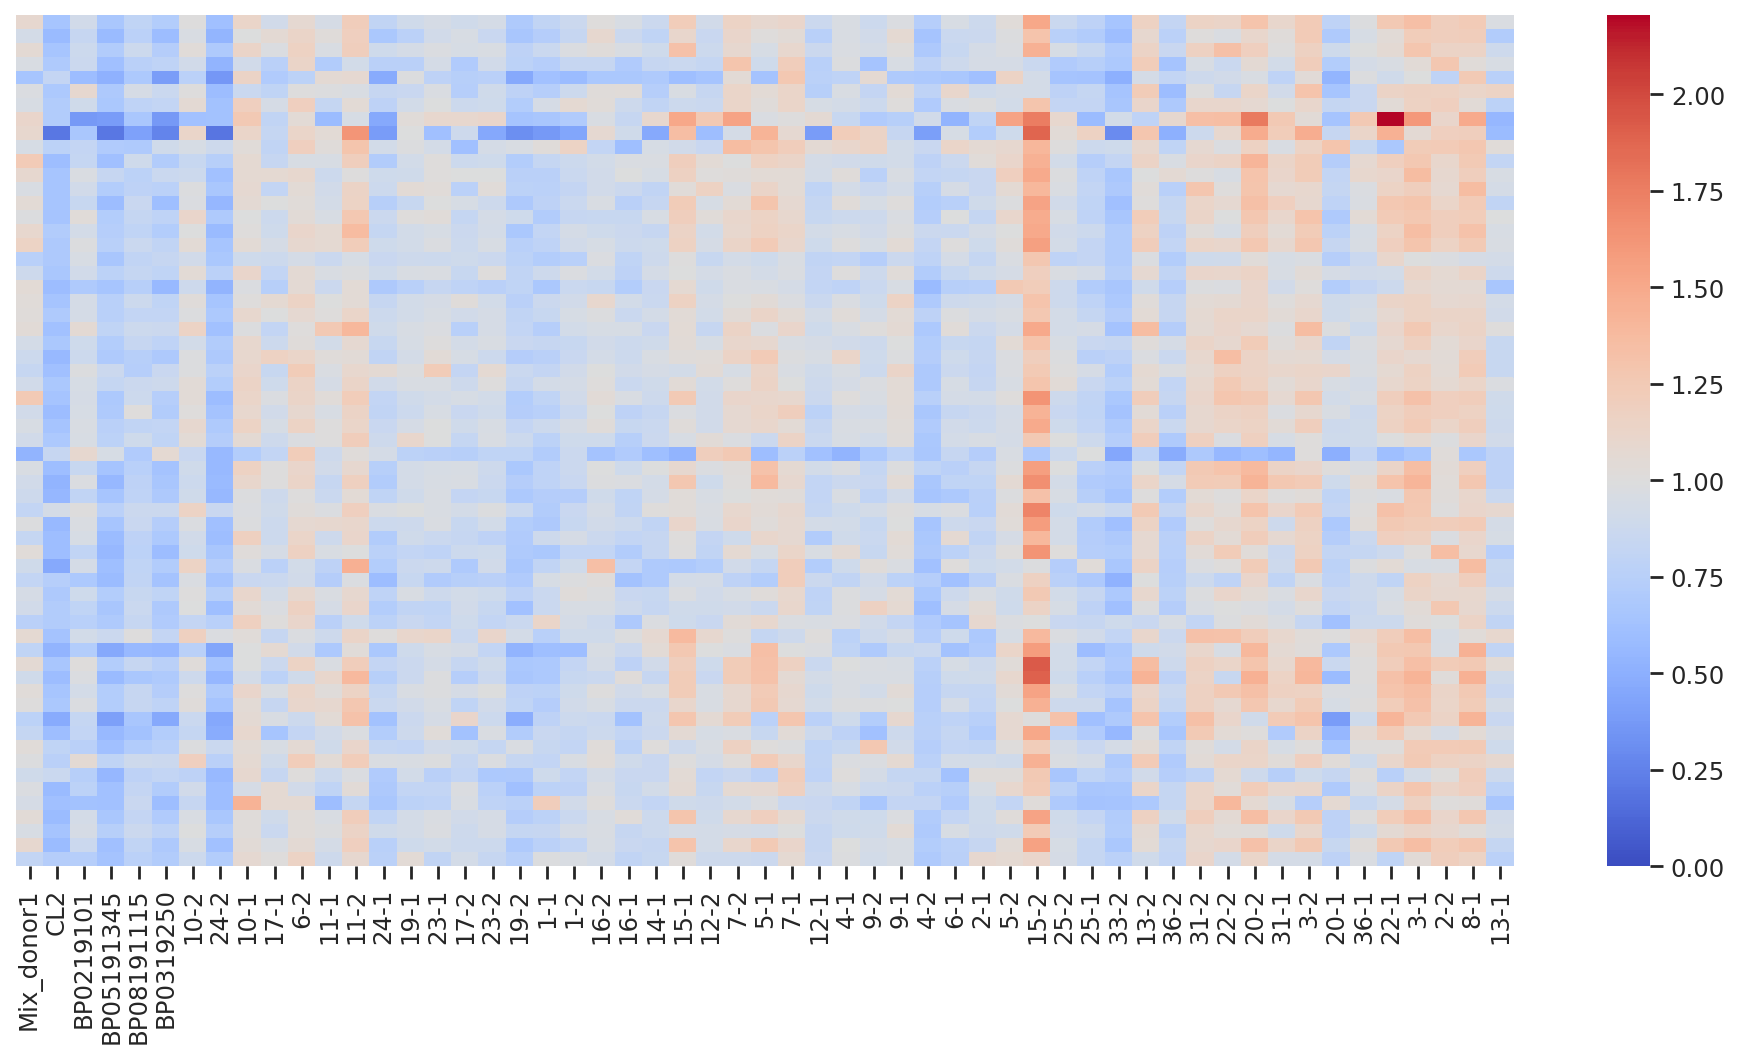

In [43]:
df_corresponding = plot_corresponding(p, sig_pathways, adata_prolif, figsize=(15, 7))

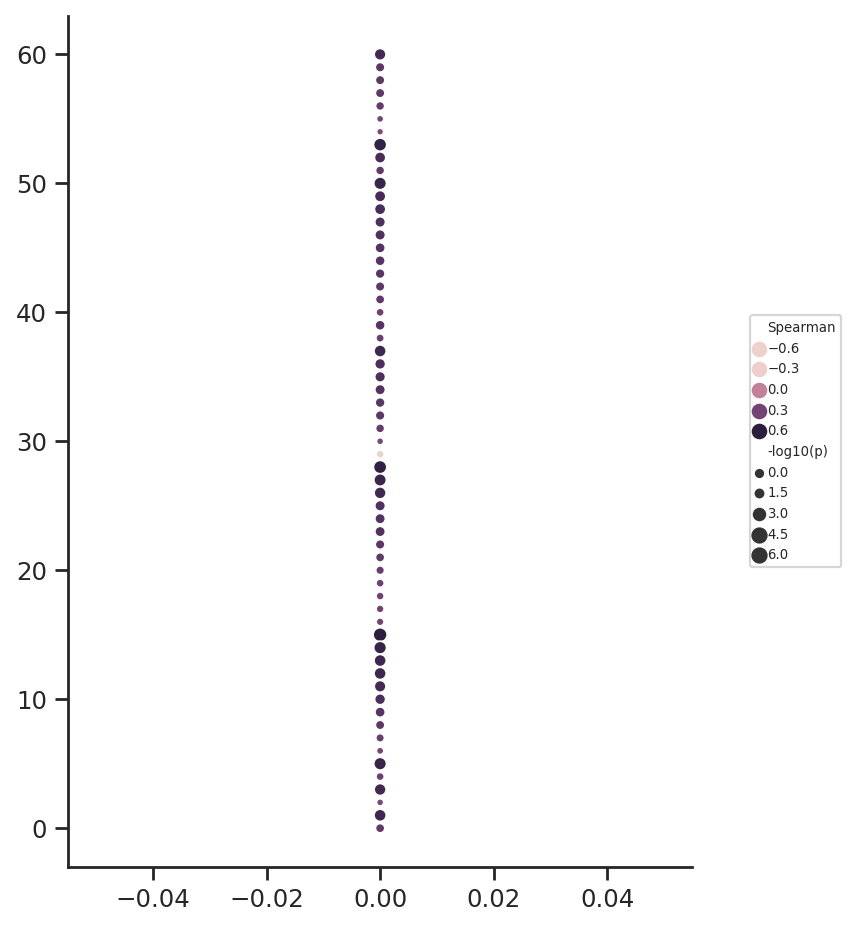

In [44]:
plot_spearman_dots(sig_pathways, df_corresponding, figsize=(5, 7))

In [45]:
df_corresponding.index.map(classifications)

Index(['Amino acid metabolism', 'Amino acid metabolism',
       'Amino acid metabolism', 'Amino acid metabolism',
       'Amino acid metabolism', 'Amino acid metabolism',
       'Amino acid metabolism', 'Biosynthesis of other secondary metabolites',
       'Biosynthesis of other secondary metabolites',
       'Biosynthesis of other secondary metabolites',
       'Carbohydrate metabolism', 'Carbohydrate metabolism',
       'Carbohydrate metabolism', 'Carbohydrate metabolism',
       'Carbohydrate metabolism', 'Carbohydrate metabolism',
       'Carbohydrate metabolism', 'Carbohydrate metabolism',
       'Carbohydrate metabolism', 'Carbohydrate metabolism',
       'Carbohydrate metabolism', 'Energy metabolism', 'Energy metabolism',
       'Glycan biosynthesis and metabolism',
       'Glycan biosynthesis and metabolism',
       'Glycan biosynthesis and metabolism',
       'Glycan biosynthesis and metabolism',
       'Glycan biosynthesis and metabolism',
       'Glycan biosynthesis and meta

<Figure size 320x320 with 0 Axes>

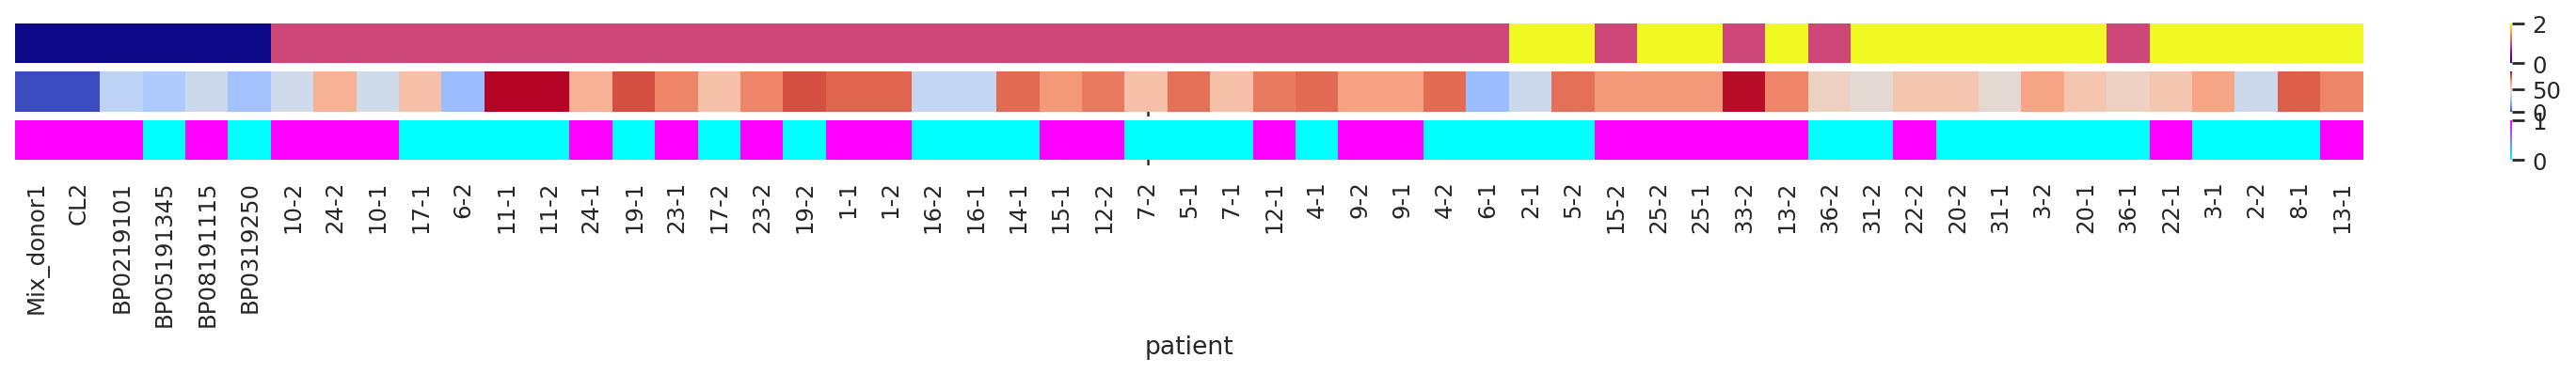

<Figure size 1280x24 with 0 Axes>

<Figure size 1280x24 with 0 Axes>

<Figure size 1280x24 with 0 Axes>

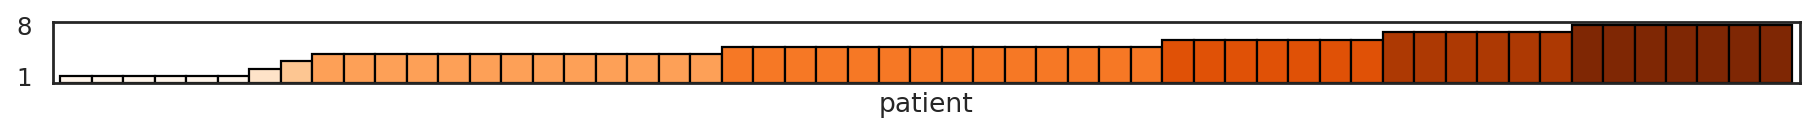

In [46]:
# Other patient attributes
adata_obs_by_patient = adata_prolif.obs.copy()
adata_obs_by_patient.index = adata_obs_by_patient['patient']
#adata_obs_by_patient.groupby(by='patient').first()
adata_obs_by_patient = adata_obs_by_patient.reset_index(drop=True)
adata_obs_by_patient = adata_obs_by_patient.groupby(by='patient').first() # All characteristics except clustering should be the same
adata_obs_by_patient['WHO_scale'] = adata_obs_by_patient['WHO_scale'].astype(int)
adata_obs_by_patient['Age_at_baseline'] = adata_obs_by_patient['Age_at_baseline'].str.replace('Not Recorded', 
                                                                                              '0').astype(int)
adata_obs_by_patient['Age_at_baseline'] = adata_obs_by_patient['Age_at_baseline'].astype(int)

# Plotting the other patient attributes
sns.set(style='white')
#sns.set(style='ticks')
sns.despine()

f, axes = plt.subplots(3, 1, figsize=(25, 1.2), sharex=False, sharey=False)

#df = adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']]
#fig = plt.figure(figsize=(16, 0.3))
#fig = sns.heatmap(df.transpose(), xticklabels=[''], yticklabels=[''],
#                 cmap='Oranges', ax=axes[0])

df = adata_obs_by_patient.loc[patients_WHO, ['ICU_status']]
df['ICU_status'] = df['ICU_status'].map({'Healthy': 0, 'Non-ICU': 1, 'ICU': 2}).astype(int)
fig = plt.figure(figsize=(16, 0.3))
fig = sns.heatmap(df.transpose(), xticklabels=[''], yticklabels=[''],
                 cmap='plasma', ax=axes[0])

#df = adata_obs_by_patient.loc[patients_WHO, ['no_IL6i']]
#df['no_IL6i'] = df['no_IL6i'].map({'Healthy': 0, 'before': 1, 'after': 2, 'no': 3}).astype(int)
#fig = plt.figure(figsize=(16, 0.3))
#fig = sns.heatmap(df.transpose(), xticklabels=[''], yticklabels=[''],
#                 cmap='viridis', ax=axes[2])

df = adata_obs_by_patient.loc[patients_WHO, ['Age_at_baseline']]
fig = plt.figure(figsize=(16, 0.3))
fig = sns.heatmap(df.transpose(), xticklabels=[''], yticklabels=[''], vmin=0,
                 cmap='coolwarm', ax=axes[1])

df = adata_obs_by_patient.loc[patients_WHO, ['Sex']]
df['Sex'] = df['Sex'].map({'Female': 1, 'Male': 0}).astype(int)
fig = plt.figure(figsize=(16, 0.3))
fig = sns.heatmap(df.transpose(), xticklabels=patients_WHO, yticklabels=[''],
                 cmap='cool', ax=axes[2])


df = adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']]
df['WHO_scale'] += 1 # Add 1 to all values in order to make all bars visible
fig = plt.figure(figsize=(14, 0.5))
oranges = cm.get_cmap('Oranges', 8)
df['c'] = [oranges(s - 1) for s in df['WHO_scale']]
fig = df['WHO_scale'].plot(kind='bar', color=df['c'], edgecolor='black', width=1)
#fig = plt.bar(x=df.index, height=df['WHO_scale'] + 1, color='brown')
                  #cmap='Oranges')
fig = plt.yticks([1, 8])
fig = plt.xticks([])

#### Type I IFN clusters only (METABOLIC cluster 5)

In [47]:
mem_metab = ['5']
adata_mem_metab = adata[adata.obs['louvain_metab'].isin(mem_metab)].copy()
adata_metab_mem_metab = adata_metab[adata.obs['louvain_metab'].isin(mem_metab)].copy()
# Not using subpopulations here for now
p = pathway_activity(adata_mem_metab, adata_metab_mem_metab, 'patient', print_labels=True)

/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


14-1
15-1
15-2
16-1
16-2
17-1
2-1
22-1
25-1
33-1
33-2


In [ ]:
# Statistical significance of higher or lower pathway activity in a specific cell type
# Random permutation test
enriched = (p > 1)
decreased = (p < 1)

# Shuffle cell cluster labels 5000x

n = 5000
compares = np.zeros((len(p), len(p[0])))
for i in range(n):
    if i % 100 == 0:
        print(i)
    clusters_shuffled = np.random.permutation(adata_mem.obs['patient'])
    adata_mem.obs['patient_shuffled'] = clusters_shuffled
    adata_metab_mem.obs['patient_shuffled'] = clusters_shuffled
    
    # Compare new pathway activity scores to original dataset pathway activity scores
    p_shuffle = pathway_activity(adata_mem, adata_metab_mem, 'patient_shuffled')
    compares += enriched * (p_shuffle > p) + decreased * (p_shuffle < p)

compares /= n

# Non-significantly changed activity scores are reverted to 1 (no activity change)
significant = (compares < 0.01)
p_sig = p ** significant

# Save pathway activity scores
df_p = pd.DataFrame(p_sig)
df_p.to_csv(master_dir + 'output/pathway_activity/' + celltype + 
            '-metab-patient-cluster_3_6-pathway_activity.tabular', 
                       sep='\t', header=None, index=None)

In [48]:
df_p = pd.DataFrame(p_sig)
df_p.index = metab_genes.index
patients = adata.obs['patient'].unique().astype(str)
patients.sort()
df_p.columns = patients

# Plot in order of increasing WHO score
patients_WHO = adata.obs.sort_values(by='WHO_scale', axis=0)['patient'].unique()
#patients_ICU = adata.obs.sort_values(by='ICU_status', axis=0)['patient'].unique()
#patients_age = adata.obs.sort_values(by='Age_at_baseline', axis=0)['patient'].unique()
#patients_days = adata.obs.sort_values(by='Days_since_onset_of_symptoms', axis=0)['patient'].unique()
df_p = df_p.loc[:, patients_WHO]

ax = plt.figure(figsize=(20, 25))
ax = sns.heatmap(df_p, cmap='bwr', yticklabels=metab_genes.index, vmin=0,
                     norm=DivergingNorm(1.0))

NameError: name 'p_sig' is not defined

<ipython-input-50-93280a25229a>:16: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(1.0))


Text(0.5, 92.00000000000001, '')

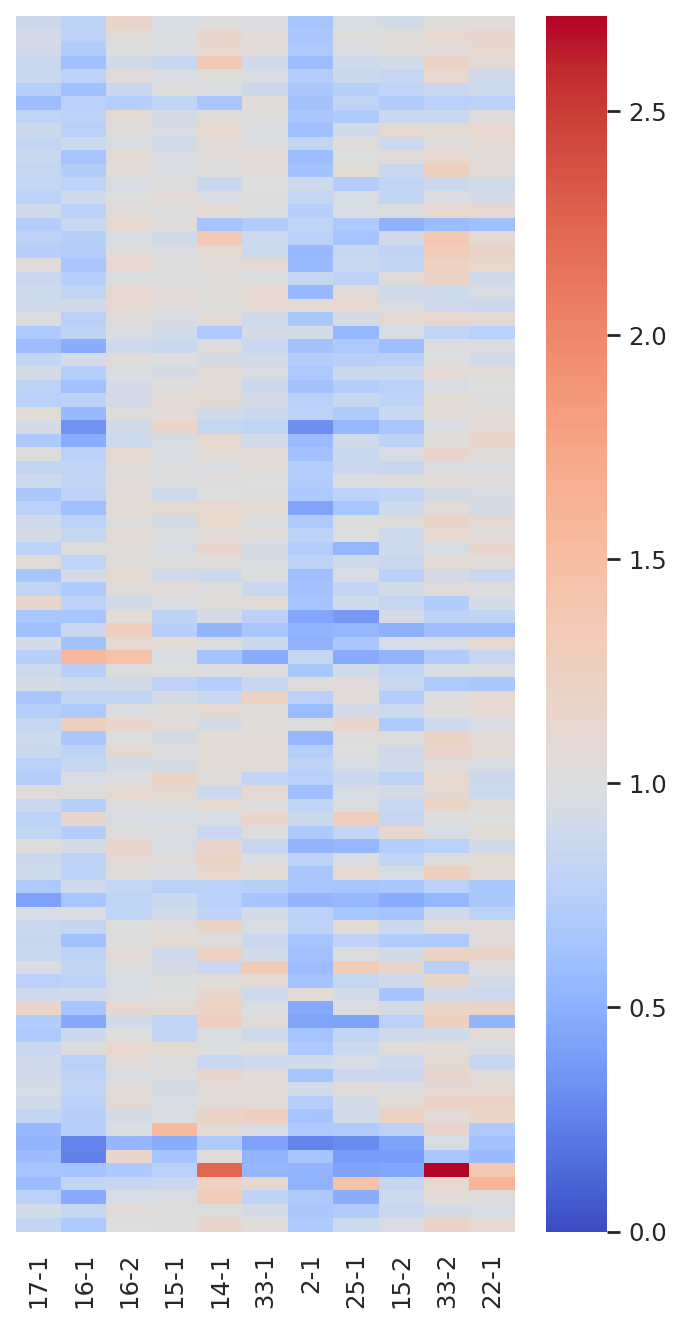

In [50]:
df_p = pd.DataFrame(p)
df_p.index = metab_genes.index
patients = adata_mem_metab.obs['patient'].unique().astype(str)
patients.sort()
df_p.columns = patients

# Plot in order of increasing WHO score
patients_WHO = adata_mem_metab.obs.sort_values(by='WHO_scale', axis=0)['patient'].unique()
#patients_ICU = adata.obs.sort_values(by='ICU_status', axis=0)['patient'].unique()
#patients_age = adata.obs.sort_values(by='Age_at_baseline', axis=0)['patient'].unique()
#patients_days = adata.obs.sort_values(by='Days_since_onset_of_symptoms', axis=0)['patient'].unique()
df_p = df_p.loc[:, patients_WHO]

ax = plt.figure(figsize=(5, 10))
ax = sns.heatmap(df_p, cmap='coolwarm', yticklabels=[], vmin=0,
                     norm=DivergingNorm(1.0))
ax.set_yticks([])
ax.set_ylabel('')
ax.set_xlabel('')

In [51]:
df_p = pd.DataFrame(p)
df_p.index = metab_genes.index
patients = adata_mem_metab.obs['patient'].unique().astype(str)
patients.sort()
df_p.columns = patients

# Other patient attributes
adata_obs_by_patient = adata.obs.copy()
adata_obs_by_patient.index = adata_obs_by_patient['patient']
#adata_obs_by_patient.groupby(by='patient').first()
adata_obs_by_patient = adata_obs_by_patient.reset_index(drop=True)
adata_obs_by_patient = adata_obs_by_patient.groupby(by='patient').first() # All characteristics except clustering should be the same
adata_obs_by_patient['WHO_scale'] = adata_obs_by_patient['WHO_scale'].astype(int)
adata_obs_by_patient['Age_at_baseline'] = adata_obs_by_patient['Age_at_baseline'].str.replace('Not Recorded', 
                                                                                              '0').astype(int)
adata_obs_by_patient['Age_at_baseline'] = adata_obs_by_patient['Age_at_baseline'].astype(int)

# Plot in order of increasing WHO score
patients_WHO = adata_mem_metab.obs.sort_values(by='WHO_scale', axis=0)['patient'].unique()
#patients_ICU = adata.obs.sort_values(by='ICU_status', axis=0)['patient'].unique()
#patients_age = adata.obs.sort_values(by='Age_at_baseline', axis=0)['patient'].unique()
#patients_days = adata.obs.sort_values(by='Days_since_onset_of_symptoms', axis=0)['patient'].unique()
df_p = df_p.loc[:, patients_WHO]

spr_corr = df_p.apply(lambda col: spearmanr(col, adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']])[0], 
                      axis=1)
spr_pvalues = df_p.apply(lambda col: spearmanr(col, adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']])[1], 
                         axis=1)

sig_pathways = pd.DataFrame([spr_corr, spr_pvalues]).transpose()
sig_pathways = sig_pathways[sig_pathways.loc[:, 1]<0.05]
sig_pathways.columns = ['Spearman', 'p-value']
sig_pathways['Spearman_abs'] = abs(sig_pathways['Spearman'])
sig_pathways = sig_pathways.sort_values(by='Spearman_abs', ascending=False)
sig_pathways['-log10(p)'] = -np.log10(sig_pathways['p-value'])
pd.DataFrame(sig_pathways).to_csv(master_dir + 'output/pathway_activity/pathway_activity_trends/' + 
                                 celltype + '-metab_cluster_1_5' + '.csv')
sig_pathways

Spearman   p-value  \
0                                                                      
Glycosaminoglycan biosynthesis - keratan sulfate -0.733674  0.010172   

                                                  Spearman_abs  -log10(p)  
0                                                                          
Glycosaminoglycan biosynthesis - keratan sulfate      0.733674   1.992587

IndexError: index 1 is out of bounds for axis 0 with size 1

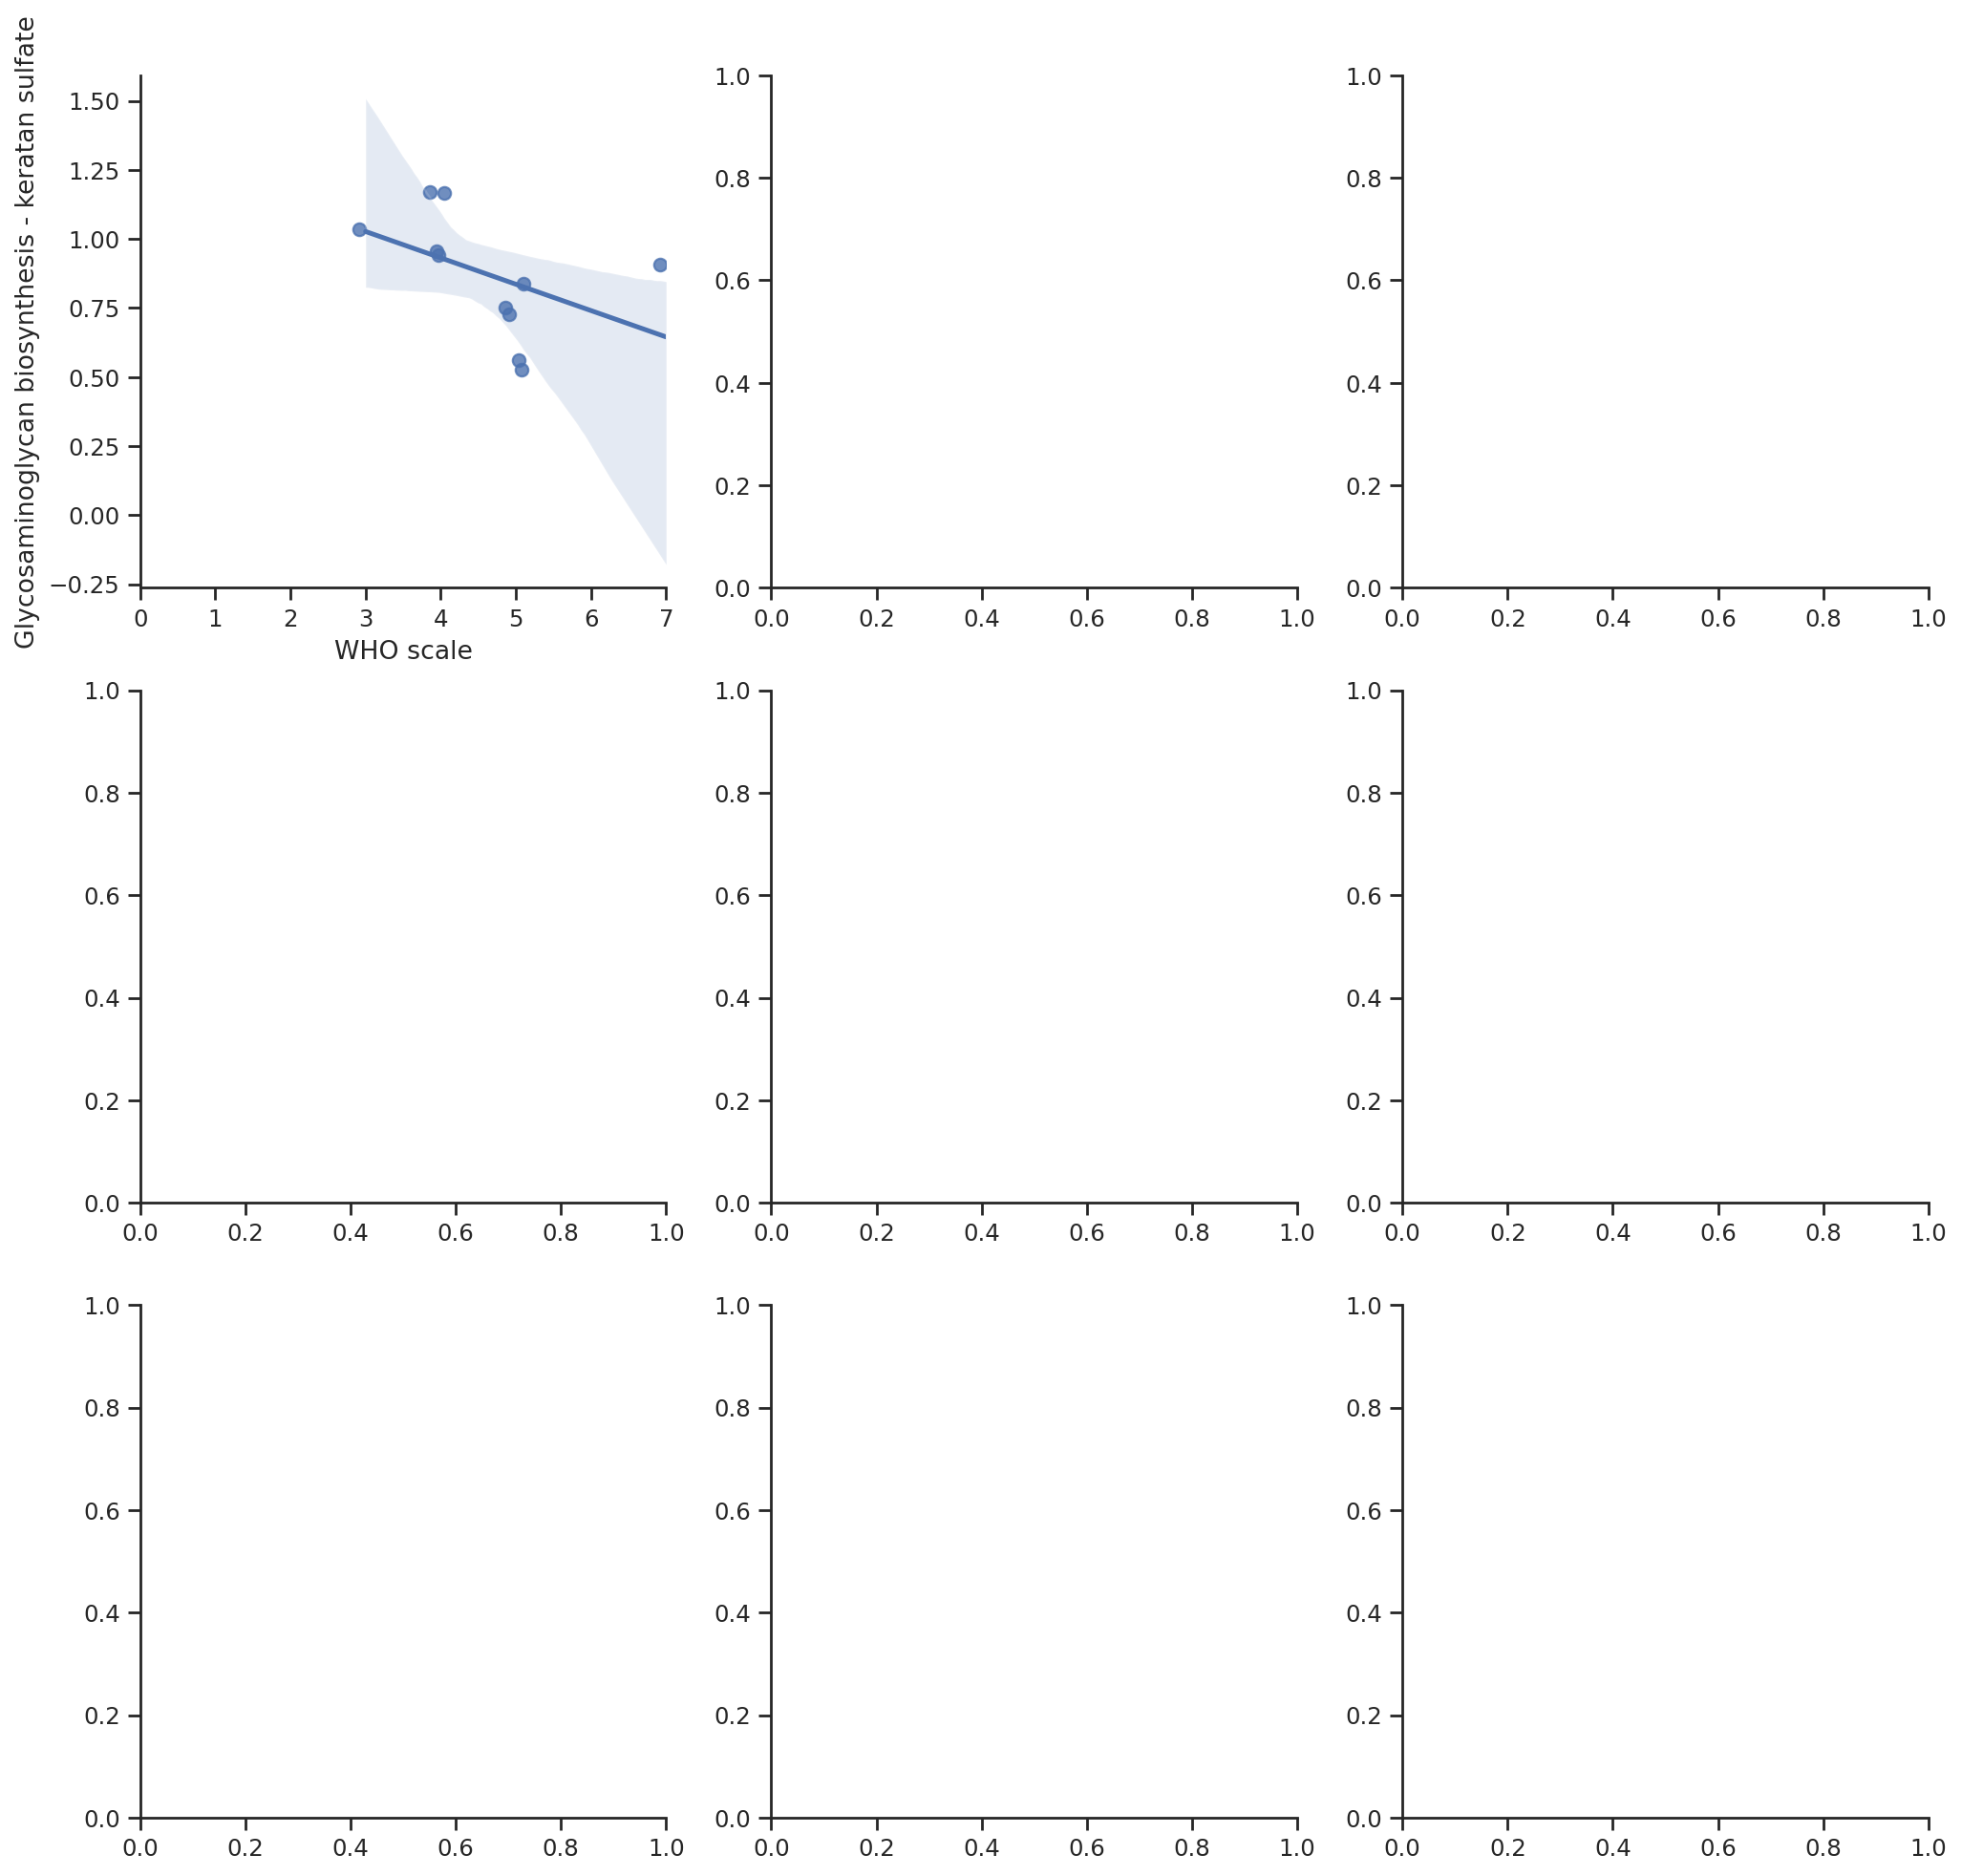

In [52]:
# Plot the top corresponding ones
sns.set_style('white')
sns.set_style('ticks')
f, axes = plt.subplots(3, 3, figsize=(15, 15), sharex=False, sharey=False)
sns.despine()

k = 0
x = adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']]
for i in range(3):
    for j in range(3):
        f = sns.regplot(x=x, y=df_p.loc[sig_pathways.index[k]], x_jitter=0.15, ax=axes[i, j])
        f.set_ylabel(sig_pathways.index[k])
        f.set_xlabel('WHO scale')
        f.set_xticks(range(8))
        k += 1

plt.tight_layout()

0
Glycosaminoglycan biosynthesis - keratan sulfate    Glycan biosynthesis and metabolism
Name: category, dtype: object


<ipython-input-33-bfdb14604942>:24: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(1.0))


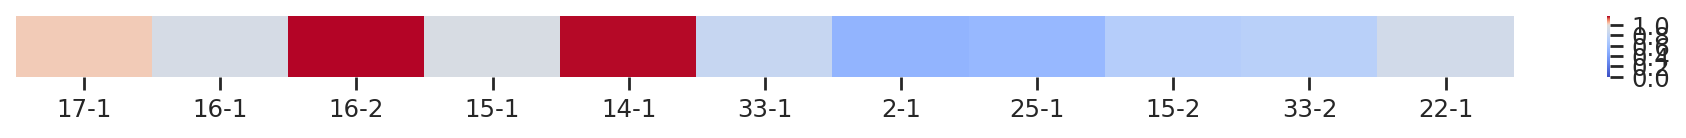

In [54]:
df_corresponding = plot_corresponding(p, sig_pathways, adata_mem_metab, figsize=(15, 0.5))

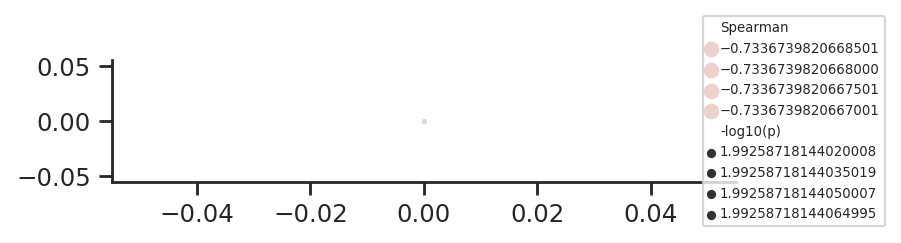

In [59]:
plot_spearman_dots(sig_pathways, df_corresponding, figsize=(5, 1))

<Figure size 320x320 with 0 Axes>

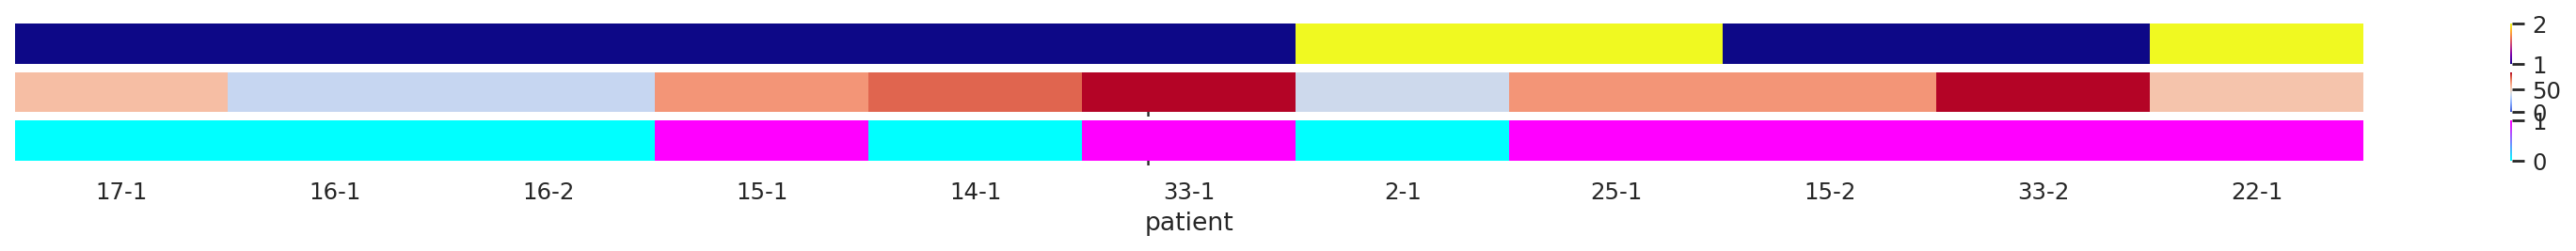

<Figure size 1280x24 with 0 Axes>

<Figure size 1280x24 with 0 Axes>

<Figure size 1280x24 with 0 Axes>

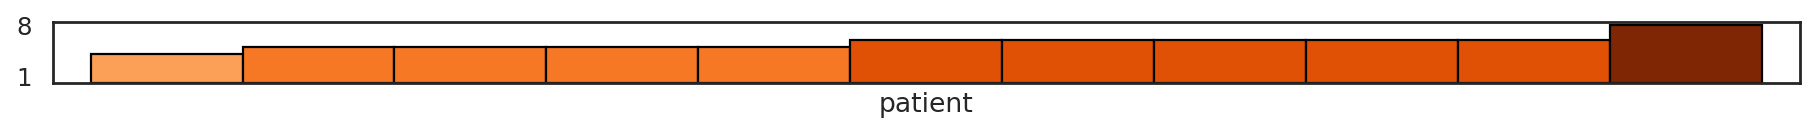

In [60]:
# Other patient attributes
adata_obs_by_patient = adata_mem_metab.obs.copy()
adata_obs_by_patient.index = adata_obs_by_patient['patient']
#adata_obs_by_patient.groupby(by='patient').first()
adata_obs_by_patient = adata_obs_by_patient.reset_index(drop=True)
adata_obs_by_patient = adata_obs_by_patient.groupby(by='patient').first() # All characteristics except clustering should be the same
adata_obs_by_patient['WHO_scale'] = adata_obs_by_patient['WHO_scale'].astype(int)
adata_obs_by_patient['Age_at_baseline'] = adata_obs_by_patient['Age_at_baseline'].str.replace('Not Recorded', 
                                                                                              '0').astype(int)
adata_obs_by_patient['Age_at_baseline'] = adata_obs_by_patient['Age_at_baseline'].astype(int)

# Plotting the other patient attributes
sns.set(style='white')
#sns.set(style='ticks')
sns.despine()

f, axes = plt.subplots(3, 1, figsize=(25, 1.2), sharex=False, sharey=False)

#df = adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']]
#fig = plt.figure(figsize=(16, 0.3))
#fig = sns.heatmap(df.transpose(), xticklabels=[''], yticklabels=[''],
#                 cmap='Oranges', ax=axes[0])

df = adata_obs_by_patient.loc[patients_WHO, ['ICU_status']]
df['ICU_status'] = df['ICU_status'].map({'Healthy': 0, 'Non-ICU': 1, 'ICU': 2}).astype(int)
fig = plt.figure(figsize=(16, 0.3))
fig = sns.heatmap(df.transpose(), xticklabels=[''], yticklabels=[''],
                 cmap='plasma', ax=axes[0])

#df = adata_obs_by_patient.loc[patients_WHO, ['no_IL6i']]
#df['no_IL6i'] = df['no_IL6i'].map({'Healthy': 0, 'before': 1, 'after': 2, 'no': 3}).astype(int)
#fig = plt.figure(figsize=(16, 0.3))
#fig = sns.heatmap(df.transpose(), xticklabels=[''], yticklabels=[''],
#                 cmap='viridis', ax=axes[2])

df = adata_obs_by_patient.loc[patients_WHO, ['Age_at_baseline']]
fig = plt.figure(figsize=(16, 0.3))
fig = sns.heatmap(df.transpose(), xticklabels=[''], yticklabels=[''], vmin=0,
                 cmap='coolwarm', ax=axes[1])

df = adata_obs_by_patient.loc[patients_WHO, ['Sex']]
df['Sex'] = df['Sex'].map({'Female': 1, 'Male': 0}).astype(int)
fig = plt.figure(figsize=(16, 0.3))
fig = sns.heatmap(df.transpose(), xticklabels=patients_WHO, yticklabels=[''],
                 cmap='cool', ax=axes[2])


df = adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']]
df['WHO_scale'] += 1 # Add 1 to all values in order to make all bars visible
fig = plt.figure(figsize=(14, 0.5))
oranges = cm.get_cmap('Oranges', 8)
df['c'] = [oranges(s - 1) for s in df['WHO_scale']]
fig = df['WHO_scale'].plot(kind='bar', color=df['c'], edgecolor='black', width=1)
#fig = plt.bar(x=df.index, height=df['WHO_scale'] + 1, color='brown')
                  #cmap='Oranges')
fig = plt.yticks([1, 8])
fig = plt.xticks([])

## Addendum 12/4/20

In [11]:
adata.obs['louvain_metab'] = adata_metab.obs['louvain']

adata_obs_by_patient = adata.obs.copy()
adata_obs_by_patient.index = adata_obs_by_patient['patient']
#adata_obs_by_patient.groupby(by='patient').first()
adata_obs_by_patient = adata_obs_by_patient.reset_index(drop=True)
adata_obs_by_patient = adata_obs_by_patient.groupby(by='patient').first() # All characteristics except clustering should be the same
adata_obs_by_patient['WHO_scale'] = adata_obs_by_patient['WHO_scale'].astype(int)
adata_obs_by_patient['Age_at_baseline'] = adata_obs_by_patient['Age_at_baseline'].str.replace('Not Recorded', 
                                                                                              '0').astype(int)
adata_obs_by_patient['Age_at_baseline'] = adata_obs_by_patient['Age_at_baseline'].astype(int)

eff_metab = ['4']
adata_eff_metab = adata[adata.obs['louvain_metab'].isin(eff_metab)].copy()
adata_metab_eff_metab = adata_metab[adata.obs['louvain_metab'].isin(eff_metab)].copy()
# Not using subpopulations here for now
p = pathway_activity(adata_eff_metab, adata_metab_eff_metab, 'patient')#, print_labels=True)

df_p = pd.DataFrame(p)
df_p.to_csv(master_dir + 'output/pathway_activity/' + celltype + '-metab_cluster_4'
            '-metab-patient-pathway_activity.tabular', 
                       sep='\t', header=None, index=None)

df_p.index = metab_genes.index
patients = adata_eff_metab.obs['patient'].unique().astype(str)
patients.sort()
df_p.columns = patients

# Plot in order of increasing WHO score
patients_WHO = adata.obs.sort_values(by='WHO_scale', axis=0)['patient'].unique()
df_p = df_p.reindex(columns=patients_WHO)#, fill_value=1)

spr_corr = df_p.apply(lambda col: spearmanr(col, adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']],
                                           nan_policy='omit')[0], axis=1)
spr_pvalues = df_p.apply(lambda col: spearmanr(col, adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']],
                                           nan_policy='omit')[1], axis=1)

sig_pathways = pd.DataFrame([spr_corr, spr_pvalues]).transpose()
sig_pathways = sig_pathways[sig_pathways.loc[:, 1]<0.05]
sig_pathways.columns = ['Spearman', 'p-value']
sig_pathways['Spearman_abs'] = abs(sig_pathways['Spearman'])
sig_pathways = sig_pathways.sort_values(by='Spearman_abs', ascending=False)
sig_pathways['-log10(p)'] = -np.log10(sig_pathways['p-value'])
pd.DataFrame(sig_pathways).to_csv(master_dir + 'output/pathway_activity/pathway_activity_trends/' + 
                                 celltype + '-metab_cluster_4' + '.csv')
sig_pathways

Spearman   p-value  \
0                                                                        
Folate biosynthesis                                 0.531474  0.000030   
Steroid biosynthesis                                0.508912  0.000073   
Aflatoxin biosynthesis                              0.502886  0.000091   
Ubiquinone and other terpenoid-quinone biosynth...  0.489144  0.000151   
Glutathione metabolism                              0.486682  0.000165   
...                                                      ...       ...   
Retinol metabolism                                  0.282750  0.036470   
Alanine, aspartate and glutamate metabolism         0.278965  0.039162   
Glycosaminoglycan biosynthesis - chondroitin su...  0.275621  0.041675   
Purine metabolism                                   0.274813  0.042302   
Arginine and proline metabolism                     0.266766  0.048978   

                                                    Spearman_abs  -log10(p)  
0                                                                            
Folate biosynthesis                                     0.531474   4.526079  
Steroid biosynthesis                                    0.508912   4.138867  
Aflatoxin biosynthesis                                  0.502886   4.039980  
Ubiquinone and other terpenoid-quinone biosynth...      0.489144   3.821260  
Glutathione metabolism                                  0.486682   3.783048  
...                                                          ...        ...  
Retinol metabolism                                      0.282750   1.438070  
Alanine, aspartate and glutamate metabolism             0.278965   1.407135  
Glycosaminoglycan biosynthesis - chondroitin su...      0.275621   1.380121  
Purine metabolism                                       0.274813   1.373634  
Arginine and proline metabolism                         0.266766   1.310000  

[61 rows x 4 columns]